# 📊 Análise Exploratória - Camada SILVER

**Objetivo:** Análise exploratória, identificação de padrões temporais e espaciais, suporte a decisões de modelagem.

Na camada Silver, os dados já estão:
- ✅ Limpos e padronizados
- ✅ Com tipos corretos
- ✅ Prontos para análise exploratória

**Aqui os gráficos são analíticos e interpretáveis.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

def find_project_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'Data Layer').exists():
            return p
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
SILVER_PATH = PROJECT_ROOT / 'Data Layer' / 'silver'

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"SILVER_PATH: {SILVER_PATH}")

In [ ]:
df = pd.read_csv(SILVER_PATH / 'data_silver.csv', low_memory=False)

date_cols = [c for c in df.columns if 'date' in c.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"Total de registros: {len(df):,}")
print(f"Total de colunas: {len(df.columns)}")

---
## 1. 📅 Gráficos Temporais

**Objetivo:** Identificar tendências gerais, sazonalidade e padrões ao longo do tempo.

### 1.1 Série Temporal Mensal de Crimes

**Descrição:** Gráfico de linha mostrando a evolução do número total de crimes mês a mês.

**Objetivo:** Identificar tendência geral (crescimento/queda) e padrões de sazonalidade.

**Como interpretar:**
- **Linha azul:** Volume mensal de crimes
- **Linha vermelha tracejada:** Média móvel de 3 meses (suaviza flutuações)
- **Área sombreada:** Representa magnitude do volume
- **Tendência ascendente:** Aumento na criminalidade
- **Picos sazonais:** Podem indicar padrões relacionados a estações do ano

In [ ]:
date_col = 'date_occurred' if 'date_occurred' in df.columns else [c for c in df.columns if 'date' in c.lower()][0]
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df['year_month'] = df[date_col].dt.to_period('M')
monthly = df['year_month'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(monthly))
ax.plot(x, monthly.values, color='steelblue', linewidth=2, marker='o', markersize=3)
ax.fill_between(x, monthly.values, alpha=0.3, color='steelblue')

if len(monthly) > 3:
    rolling = pd.Series(monthly.values).rolling(window=3, center=True).mean()
    ax.plot(x, rolling, color='red', linewidth=2, linestyle='--', label='Média Móvel (3m)')

step = max(1, len(monthly)//12)
ax.set_xticks(range(0, len(monthly), step))
ax.set_xticklabels([str(monthly.index[i]) for i in range(0, len(monthly), step)], rotation=45, ha='right')

ax.set_xlabel('Período')
ax.set_ylabel('Número de Crimes')
ax.set_title('Série Temporal Mensal de Crimes em Los Angeles', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

if len(monthly) >= 12:
    trend = (monthly.tail(12).mean() - monthly.head(12).mean()) / monthly.head(12).mean() * 100
    print(f"\nTendência: {trend:+.1f}% (último ano vs primeiro ano)")

### 1.2 Série Temporal por Tipo de Crime (Top 5)

**Descrição:** Múltiplas linhas mostrando a evolução temporal dos 5 tipos de crime mais frequentes.

**Objetivo:** Comparar comportamentos distintos ao longo do tempo entre diferentes categorias de crime.

**Como interpretar:**
- **Cada linha colorida:** Representa um tipo de crime específico
- **Cruzamentos entre linhas:** Indicam mudanças na predominância de tipos de crime
- **Picos isolados:** Podem indicar ondas de criminalidade específica
- **Tendências paralelas:** Tipos de crime com comportamento similar

In [ ]:
crime_col = 'crime_description' if 'crime_description' in df.columns else 'Crm Cd Desc'
if crime_col in df.columns:
    top_crimes = df[crime_col].value_counts().head(5).index.tolist()
    
    fig, ax = plt.subplots(figsize=(14, 7))
    colors = sns.color_palette('husl', n_colors=5)
    
    for i, crime in enumerate(top_crimes):
        crime_data = df[df[crime_col] == crime]
        monthly_crime = crime_data['year_month'].value_counts().sort_index()
        x = [list(monthly.index).index(m) for m in monthly_crime.index if m in monthly.index]
        y = [monthly_crime[monthly.index[idx]] for idx in x if monthly.index[idx] in monthly_crime.index]
        ax.plot(x, y, color=colors[i], linewidth=2, label=crime[:40], alpha=0.8)
    
    step = max(1, len(monthly)//10)
    ax.set_xticks(range(0, len(monthly), step))
    ax.set_xticklabels([str(monthly.index[i]) for i in range(0, len(monthly), step)], rotation=45, ha='right')
    
    ax.set_xlabel('Período')
    ax.set_ylabel('Número de Crimes')
    ax.set_title('Série Temporal por Tipo de Crime (Top 5)', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    plt.tight_layout()
    plt.show()

---
## 2. 📊 Gráficos de Distribuição

**Objetivo:** Identificar padrões em horários e dias da semana para apoiar estratégias de policiamento.

### 2.1 Distribuição de Crimes por Hora do Dia

**Descrição:** Gráfico de barras mostrando a quantidade de crimes por hora (0-23h), colorido por período do dia.

**Objetivo:** Identificar horários críticos para alocação de recursos policiais.

**Legenda de cores:**
- 🟡 **Amarelo (6h-12h):** Manhã
- 🟠 **Laranja (12h-18h):** Tarde
- 🔴 **Vermelho (18h-22h):** Noite
- ⚫ **Cinza (22h-6h):** Madrugada

**Como interpretar:**
- **Horário de pico:** Maior concentração de crimes
- **Linha tracejada:** Indica o horário de pico específico
- **Padrões comuns:** Crimes geralmente aumentam no fim da tarde/noite

In [ ]:
hour_col = 'hour' if 'hour' in df.columns else 'Hour'
if hour_col in df.columns:
    hourly = df[hour_col].value_counts().sort_index()
    hourly = hourly[(hourly.index >= 0) & (hourly.index < 24)]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = []
    for h in hourly.index:
        if 6 <= h < 12: colors.append('#ffc107')
        elif 12 <= h < 18: colors.append('#fd7e14')
        elif 18 <= h < 22: colors.append('#dc3545')
        else: colors.append('#6c757d')
    
    ax.bar(hourly.index, hourly.values, color=colors, edgecolor='black', alpha=0.8)
    
    peak = hourly.idxmax()
    ax.axvline(x=peak, color='red', linestyle='--', linewidth=2, label=f'Pico: {peak}:00 ({hourly[peak]:,})')
    
    from matplotlib.patches import Patch
    legend = [Patch(facecolor='#ffc107', label='Manhã (6-12h)'),
              Patch(facecolor='#fd7e14', label='Tarde (12-18h)'),
              Patch(facecolor='#dc3545', label='Noite (18-22h)'),
              Patch(facecolor='#6c757d', label='Madrugada')]
    
    ax.set_xlabel('Hora do Dia')
    ax.set_ylabel('Número de Crimes')
    ax.set_title('Distribuição de Crimes por Hora do Dia', fontsize=14, fontweight='bold')
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h}:00' for h in range(24)], rotation=45, ha='right')
    ax.legend(handles=legend, loc='upper left')
    plt.tight_layout()
    plt.show()
    
    morning = hourly[(hourly.index >= 6) & (hourly.index < 12)].sum()
    afternoon = hourly[(hourly.index >= 12) & (hourly.index < 18)].sum()
    evening = hourly[(hourly.index >= 18) & (hourly.index < 22)].sum()
    night = hourly[(hourly.index >= 22) | (hourly.index < 6)].sum()
    total = hourly.sum()
    
    print(f"\nDistribuição por Período:")
    print(f"   Manhã: {morning:,} ({morning/total*100:.1f}%)")
    print(f"   Tarde: {afternoon:,} ({afternoon/total*100:.1f}%)")
    print(f"   Noite: {evening:,} ({evening/total*100:.1f}%)")
    print(f"   Madrugada: {night:,} ({night/total*100:.1f}%)")

### 2.2 Distribuição de Crimes por Dia da Semana

**Descrição:** Gráfico de barras comparando o volume de crimes entre os dias da semana.

**Objetivo:** Diferenciar padrões entre dias úteis e fins de semana.

**Legenda de cores:**
- 🔵 **Azul:** Dias úteis (Segunda a Sexta)
- 🟠 **Coral:** Fins de semana (Sábado e Domingo)

**Como interpretar:**
- **Linha vermelha:** Média diária
- **Diferença entre dias:** Indica necessidade de ajuste na escala policial
- **Fins de semana:** Geralmente têm padrões diferentes de dias úteis

In [ ]:
df['day_of_week'] = df[date_col].dt.dayofweek
df['day_name'] = df[date_col].dt.day_name()

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = df['day_name'].value_counts().reindex(dow_order)

fig, ax = plt.subplots(figsize=(12, 6))
colors = ['steelblue']*5 + ['coral']*2
bars = ax.bar(dow_counts.index, dow_counts.values, color=colors, edgecolor='black', alpha=0.8)

ax.axhline(y=dow_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Média: {dow_counts.mean():,.0f}')

for bar, count in zip(bars, dow_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{count:,}', ha='center', fontsize=10)

ax.set_xlabel('Dia da Semana')
ax.set_ylabel('Número de Crimes')
ax.set_title('Distribuição de Crimes por Dia da Semana', fontsize=14, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

weekday = dow_counts[:5].mean()
weekend = dow_counts[5:].mean()
print(f"\nComparação: Dias úteis ({weekday:,.0f}/dia) vs Fins de semana ({weekend:,.0f}/dia)")
print(f"   Diferença: {(weekday-weekend)/weekday*100:+.1f}%")

---
## 3. 🗺️ Gráficos Espaciais

**Objetivo:** Identificar hotspots e padrões geográficos de crimes para orientar patrulhamento.

### 3.1 Mapa de Calor (Heatmap) de Crimes em LA

**Descrição:** Visualização hexbin mostrando a densidade de crimes por área geográfica.

**Objetivo:** Identificar hotspots consolidados de criminalidade em Los Angeles.

**Como interpretar:**
- **Cores quentes (vermelho/laranja):** Alta concentração de crimes - hotspots
- **Cores frias (amarelo):** Baixa concentração de crimes
- **Hexágonos:** Agregam crimes por área geográfica
- **Barra de cores:** Indica a escala de número de crimes por hexágono

In [ ]:
lat_col = 'latitude' if 'latitude' in df.columns else 'LAT'
lon_col = 'longitude' if 'longitude' in df.columns else 'LON'

if lat_col in df.columns and lon_col in df.columns:
    LA_LAT_MIN, LA_LAT_MAX = 33.7, 34.4
    LA_LON_MIN, LA_LON_MAX = -118.7, -118.1
    
    coords = df[[lat_col, lon_col]].dropna()
    coords = coords[(coords[lat_col] != 0) & (coords[lon_col] != 0)]
    coords = coords[(coords[lat_col] >= LA_LAT_MIN) & (coords[lat_col] <= LA_LAT_MAX) &
                    (coords[lon_col] >= LA_LON_MIN) & (coords[lon_col] <= LA_LON_MAX)]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    hb = ax.hexbin(coords[lon_col], coords[lat_col], gridsize=50, cmap='YlOrRd', mincnt=1, alpha=0.8)
    plt.colorbar(hb, ax=ax, label='Número de Crimes')
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Mapa de Calor de Crimes em Los Angeles', fontsize=14, fontweight='bold')
    ax.set_xlim(LA_LON_MIN, LA_LON_MAX)
    ax.set_ylim(LA_LAT_MIN, LA_LAT_MAX)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal de crimes mapeados: {len(coords):,}")

### 3.2 Visualização 3D de Hotspots

**Descrição:** Superfície 3D mostrando a densidade de crimes com eixos latitude, longitude e intensidade.

**Objetivo:** Destacar a intensidade espacial de forma mais visual e intuitiva.

**Como interpretar:**
- **Eixo Z (altura):** Densidade de ocorrências
- **Picos altos:** Hotspots de alta criminalidade
- **Vales:** Áreas com menor incidência
- **Superfície contínua:** Interpolação entre pontos usando KDE (Kernel Density Estimation)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

if lat_col in df.columns and lon_col in df.columns:
    sample = coords.sample(n=min(10000, len(coords)), random_state=42)
    x, y = sample[lon_col].values, sample[lat_col].values
    
    xi = np.linspace(LA_LON_MIN, LA_LON_MAX, 50)
    yi = np.linspace(LA_LAT_MIN, LA_LAT_MAX, 50)
    Xi, Yi = np.meshgrid(xi, yi)
    
    kernel = stats.gaussian_kde(np.vstack([x, y]))
    Zi = np.reshape(kernel(np.vstack([Xi.ravel(), Yi.ravel()])).T, Xi.shape)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(Xi, Yi, Zi, cmap='YlOrRd', alpha=0.8, linewidth=0)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Densidade')
    ax.set_title('Visualização 3D de Hotspots de Crime', fontsize=14, fontweight='bold')
    ax.view_init(elev=30, azim=45)
    fig.colorbar(surf, ax=ax, shrink=0.5, label='Densidade')
    plt.tight_layout()
    plt.show()
    
    max_idx = np.unravel_index(np.argmax(Zi), Zi.shape)
    print(f"\nHotspot principal: ({Yi[max_idx]:.4f}, {Xi[max_idx]:.4f})")

---
## 4. 📈 Gráficos Comparativos e Multivariados

**Objetivo:** Analisar padrões comportamentais, rankings e relações entre variáveis.

### 4.1 Ranking de Distritos por Número de Crimes

**Descrição:** Gráfico de barras horizontais mostrando os 20 distritos com mais crimes.

**Objetivo:** Identificar regiões mais críticas para priorização de recursos.

**Como interpretar:**
- **Cores:** Gradiente de vermelho (mais crimes) para verde (menos crimes)
- **Barras maiores:** Distritos que requerem mais atenção
- **Valores nas barras:** Quantidade absoluta de crimes
- **Uso prático:** Orientar alocação de efetivo policial

In [ ]:
area_col = 'area_name' if 'area_name' in df.columns else 'AREA NAME'
if area_col in df.columns:
    area_counts = df[area_col].value_counts().head(20)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(area_counts)))
    bars = ax.barh(range(len(area_counts)), area_counts.values, color=colors, edgecolor='black', alpha=0.8)
    
    ax.set_yticks(range(len(area_counts)))
    ax.set_yticklabels(area_counts.index)
    ax.invert_yaxis()
    
    for bar, count in zip(bars, area_counts.values):
        ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f'{count:,}', va='center', fontsize=9)
    
    ax.set_xlabel('Número de Crimes')
    ax.set_title('Ranking de Distritos por Número de Crimes (Top 20)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTop 3 Distritos:")
    for i, (area, count) in enumerate(area_counts.head(3).items(), 1):
        print(f"   {i}. {area}: {count:,} ({count/len(df)*100:.1f}%)")

### 4.2 Heatmap: Tipo de Crime × Período do Dia

**Descrição:** Matriz de calor mostrando a distribuição percentual de cada tipo de crime por período do dia.

**Objetivo:** Analisar padrões comportamentais - quando cada tipo de crime é mais comum.

**Como interpretar:**
- **Linhas:** Top 10 tipos de crime
- **Colunas:** Períodos do dia (Manhã, Tarde, Noite, Madrugada)
- **Valores:** Percentual do tipo de crime naquele período
- **Cores quentes:** Alta concentração naquele período
- **Uso prático:** Ajustar patrulhamento por tipo de crime esperado em cada horário

In [ ]:
if crime_col in df.columns and hour_col in df.columns:
    def get_period(h):
        if pd.isna(h): return 'Unknown'
        if 6 <= h < 12: return 'Manhã'
        if 12 <= h < 18: return 'Tarde'
        if 18 <= h < 22: return 'Noite'
        return 'Madrugada'
    
    df['period'] = df[hour_col].apply(get_period)
    top_crimes = df[crime_col].value_counts().head(10).index.tolist()
    df_top = df[df[crime_col].isin(top_crimes)]
    
    cross = pd.crosstab(df_top[crime_col], df_top['period'])
    period_order = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
    cross = cross.reindex(columns=[p for p in period_order if p in cross.columns])
    cross = cross.reindex(top_crimes)
    cross_pct = cross.div(cross.sum(axis=1), axis=0) * 100
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(cross_pct, annot=True, fmt='.1f', cmap='YlOrRd', linewidths=0.5, ax=ax,
                cbar_kws={'label': '% do tipo de crime'})
    
    ax.set_xlabel('Período do Dia')
    ax.set_ylabel('Tipo de Crime')
    ax.set_title('Heatmap: Tipo de Crime × Período do Dia', fontsize=14, fontweight='bold')
    ax.set_yticklabels([l.get_text()[:35] + '...' if len(l.get_text()) > 35 else l.get_text() 
                        for l in ax.get_yticklabels()], rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()
    
    print(f"\nInsights:")
    for crime in top_crimes[:3]:
        peak = cross_pct.loc[crime].idxmax()
        print(f"   • {crime[:35]}: pico na {peak} ({cross_pct.loc[crime].max():.1f}%)")

### 4.3 Perfil das Vítimas (Idade e Gênero)

**Descrição:** Análise demográfica das vítimas de crimes em Los Angeles.

**Objetivo:** Entender quais grupos demográficos são mais afetados.

**Como interpretar:**
- **Gráfico esquerdo:** Distribuição por faixa etária
  - Barras maiores indicam grupos mais vulneráveis
- **Gráfico direito:** Distribuição por gênero
  - Proporção entre vítimas masculinas e femininas
- **Uso prático:** Orientar campanhas de prevenção e proteção

In [ ]:
age_col = 'victim_age' if 'victim_age' in df.columns else 'Vict Age'
sex_col = 'victim_sex' if 'victim_sex' in df.columns else 'Vict Sex'

if age_col in df.columns:
    valid = df[(df[age_col] > 0) & (df[age_col] <= 100)].copy()
    bins = [0, 12, 18, 25, 35, 45, 55, 65, 100]
    labels = ['0-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    valid['age_group'] = pd.cut(valid[age_col], bins=bins, labels=labels)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1 = axes[0]
    age_counts = valid['age_group'].value_counts().sort_index()
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(age_counts)))
    ax1.bar(age_counts.index, age_counts.values, color=colors, edgecolor='black')
    ax1.set_xlabel('Faixa Etária')
    ax1.set_ylabel('Número de Vítimas')
    ax1.set_title('Distribuição por Faixa Etária', fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    ax2 = axes[1]
    if sex_col in df.columns:
        sex_map = {'M': 'Masculino', 'F': 'Feminino', 'X': 'Outro'}
        sex_counts = df[sex_col].map(sex_map).value_counts()
        ax2.pie(sex_counts.values, labels=sex_counts.index, colors=['#3498db', '#e74c3c', '#95a5a6'][:len(sex_counts)],
                autopct='%1.1f%%', startangle=90)
        ax2.set_title('Distribuição por Gênero', fontweight='bold')
    
    plt.suptitle('Perfil das Vítimas de Crimes', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPerfil:")
    print(f"   Faixa mais afetada: {age_counts.idxmax()} ({age_counts.max():,} vítimas)")
    print(f"   Idade média: {valid[age_col].mean():.1f} anos")

---
## 📋 Resumo Analítico

**Na camada Silver, os gráficos foram usados para:**
- ✅ Análise exploratória (padrões e distribuições)
- ✅ Identificação de padrões temporais (séries, horários, dias)
- ✅ Identificação de padrões espaciais (hotspots, ranking)
- ✅ Suporte a decisões de modelagem para a camada Gold

**Recomendações para a camada Gold:**
1. Criar dimensões temporais (dim_date, dim_time)
2. Criar dimensão espacial (dim_area)
3. Criar dimensão de tipo de crime (dim_crime_type)
4. Criar tabela fato com métricas agregadas
5. Pré-calcular KPIs para dashboards

In [ ]:
print("="*60)
print("RESUMO ANALÍTICO - CAMADA SILVER")
print("="*60)
print(f"\nArquivo: data_silver.csv")
print(f"Registros: {len(df):,}")
print(f"Colunas: {len(df.columns)}")
print(f"\nINSIGHTS:")
if hour_col in df.columns:
    print(f"   Horário de pico: {hourly.idxmax()}:00")
print(f"   Dia mais crítico: {dow_counts.idxmax()}")
if area_col in df.columns:
    print(f"   Área mais crítica: {df[area_col].value_counts().idxmax()}")
if crime_col in df.columns:
    print(f"   Crime mais comum: {df[crime_col].value_counts().idxmax()}")
print("="*60)

# 📊 Análise Exploratória - Camada SILVER

**Objetivo:** Análise exploratória, identificação de padrões temporais e espaciais, suporte a decisões de modelagem.

Na camada Silver, os dados já estão:
- ✅ Limpos e padronizados
- ✅ Com tipos corretos
- ✅ Prontos para análise exploratória e agregações

**Aqui os gráficos são analíticos e interpretáveis.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
sns.set_palette('husl')

# Caminhos
PROJECT_ROOT = Path.cwd().parent.parent
SILVER_PATH = PROJECT_ROOT / 'Data Layer' / 'silver'

print(f"📁 PROJECT_ROOT: {PROJECT_ROOT}")
print(f"📂 SILVER_PATH: {SILVER_PATH}")

In [ ]:
# Carregar dados silver (limpos e transformados)
df = pd.read_csv(SILVER_PATH / 'data_silver.csv', low_memory=False)

# Converter colunas de data
date_cols = [col for col in df.columns if 'date' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print(f"📊 Total de registros: {len(df):,}")
print(f"📋 Total de colunas: {len(df.columns)}")
print(f"\n🔢 Colunas disponíveis:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:02d}. {col}")

---
## 1. 📅 Gráficos Temporais

Objetivo: Identificar tendências gerais, sazonalidade e padrões ao longo do tempo.

In [ ]:
# 1.1 Série temporal mensal de crimes totais
# Objetivo: identificar tendência geral e sazonalidade

# Encontrar coluna de data
date_col = 'date_occ' if 'date_occ' in df.columns else 'DATE OCC'
if date_col not in df.columns:
    date_col = [c for c in df.columns if 'date' in c.lower()][0] if any('date' in c.lower() for c in df.columns) else None

if date_col:
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df['year_month'] = df[date_col].dt.to_period('M')
    monthly = df['year_month'].value_counts().sort_index()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Plotar série temporal
    x = range(len(monthly))
    ax.plot(x, monthly.values, color='steelblue', linewidth=2, marker='o', markersize=3)
    ax.fill_between(x, monthly.values, alpha=0.3, color='steelblue')
    
    # Adicionar média móvel (3 meses)
    if len(monthly) > 3:
        rolling_avg = pd.Series(monthly.values).rolling(window=3, center=True).mean()
        ax.plot(x, rolling_avg, color='red', linewidth=2, linestyle='--', 
                label='Média Móvel (3 meses)')
    
    # Labels do eixo X
    step = max(1, len(monthly) // 12)
    tick_positions = range(0, len(monthly), step)
    tick_labels = [str(monthly.index[i]) for i in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    ax.set_xlabel('Período (Ano-Mês)', fontsize=12)
    ax.set_ylabel('Número de Crimes', fontsize=12)
    ax.set_title('📈 Série Temporal Mensal de Crimes em Los Angeles\n'
                 'Identificação de Tendência e Sazonalidade', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Análise de tendência
    if len(monthly) >= 12:
        first_year_avg = monthly.head(12).mean()
        last_year_avg = monthly.tail(12).mean()
        trend = (last_year_avg - first_year_avg) / first_year_avg * 100
        print(f"\n📋 Análise de Tendência:")
        print(f"   Média primeiro ano: {first_year_avg:,.0f} crimes/mês")
        print(f"   Média último ano: {last_year_avg:,.0f} crimes/mês")
        print(f"   Tendência: {trend:+.1f}%")
else:
    print("⚠️ Coluna de data não encontrada.")

In [ ]:
# 1.2 Série temporal por tipo de crime (Top 5)
# Objetivo: comparar comportamentos distintos ao longo do tempo

# Encontrar coluna de tipo de crime
crime_col = 'crm_cd_desc' if 'crm_cd_desc' in df.columns else 'Crm Cd Desc'
if crime_col not in df.columns:
    crime_col = [c for c in df.columns if 'crm' in c.lower() and 'desc' in c.lower()]
    crime_col = crime_col[0] if crime_col else None

if crime_col and date_col:
    # Top 5 tipos de crime
    top_crimes = df[crime_col].value_counts().head(5).index.tolist()
    
    fig, ax = plt.subplots(figsize=(14, 7))
    colors = sns.color_palette('husl', n_colors=5)
    
    for i, crime_type in enumerate(top_crimes):
        crime_data = df[df[crime_col] == crime_type]
        monthly_crime = crime_data['year_month'].value_counts().sort_index()
        
        x = [list(monthly.index).index(m) for m in monthly_crime.index if m in monthly.index]
        y = [monthly_crime[monthly.index[idx]] for idx in x if monthly.index[idx] in monthly_crime.index]
        
        ax.plot(x, y, color=colors[i], linewidth=2, label=crime_type[:40], alpha=0.8)
    
    # Labels do eixo X
    step = max(1, len(monthly) // 10)
    tick_positions = range(0, len(monthly), step)
    tick_labels = [str(monthly.index[i]) for i in tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    ax.set_xlabel('Período (Ano-Mês)', fontsize=12)
    ax.set_ylabel('Número de Crimes', fontsize=12)
    ax.set_title('📈 Série Temporal por Tipo de Crime (Top 5)\n'
                 'Comparação de Comportamentos ao Longo do Tempo', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Colunas necessárias não encontradas.")

---
## 2. 📊 Gráficos de Distribuição

Objetivo: Identificar padrões em horários e dias da semana.

In [ ]:
# 2.1 Distribuição de crimes por hora do dia
# Objetivo: identificar horários críticos

# Encontrar coluna de hora
hour_col = 'hour' if 'hour' in df.columns else 'Hour'
if hour_col not in df.columns:
    # Tentar extrair de TIME OCC
    time_col = 'time_occ' if 'time_occ' in df.columns else 'TIME OCC'
    if time_col in df.columns:
        df['hour'] = df[time_col] // 100
        hour_col = 'hour'

if hour_col in df.columns:
    hourly = df[hour_col].value_counts().sort_index()
    hourly = hourly[(hourly.index >= 0) & (hourly.index < 24)]  # Filtrar horas válidas
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Colorir por período do dia
    colors = []
    for h in hourly.index:
        if 6 <= h < 12:
            colors.append('#ffc107')  # Manhã - amarelo
        elif 12 <= h < 18:
            colors.append('#fd7e14')  # Tarde - laranja
        elif 18 <= h < 22:
            colors.append('#dc3545')  # Noite - vermelho
        else:
            colors.append('#6c757d')  # Madrugada - cinza
    
    bars = ax.bar(hourly.index, hourly.values, color=colors, edgecolor='black', alpha=0.8)
    
    # Destacar hora de pico
    peak_hour = hourly.idxmax()
    ax.axvline(x=peak_hour, color='red', linestyle='--', linewidth=2, 
               label=f'Pico: {peak_hour}:00 ({hourly[peak_hour]:,} crimes)')
    
    # Legenda de períodos
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ffc107', label='Manhã (6h-12h)'),
        Patch(facecolor='#fd7e14', label='Tarde (12h-18h)'),
        Patch(facecolor='#dc3545', label='Noite (18h-22h)'),
        Patch(facecolor='#6c757d', label='Madrugada (22h-6h)')
    ]
    
    ax.set_xlabel('Hora do Dia', fontsize=12)
    ax.set_ylabel('Número de Crimes', fontsize=12)
    ax.set_title('📊 Distribuição de Crimes por Hora do Dia\n'
                 'Identificação de Horários Críticos', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(0, 24))
    ax.set_xticklabels([f'{h}:00' for h in range(0, 24)], rotation=45, ha='right')
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Análise por período
    morning = hourly[(hourly.index >= 6) & (hourly.index < 12)].sum()
    afternoon = hourly[(hourly.index >= 12) & (hourly.index < 18)].sum()
    evening = hourly[(hourly.index >= 18) & (hourly.index < 22)].sum()
    night = hourly[(hourly.index >= 22) | (hourly.index < 6)].sum()
    
    print(f"\n📋 Distribuição por Período:")
    print(f"   Manhã (6h-12h): {morning:,} ({morning/hourly.sum()*100:.1f}%)")
    print(f"   Tarde (12h-18h): {afternoon:,} ({afternoon/hourly.sum()*100:.1f}%)")
    print(f"   Noite (18h-22h): {evening:,} ({evening/hourly.sum()*100:.1f}%)")
    print(f"   Madrugada (22h-6h): {night:,} ({night/hourly.sum()*100:.1f}%)")
else:
    print("⚠️ Coluna de hora não encontrada.")

In [ ]:
# 2.2 Distribuição de crimes por dia da semana
# Objetivo: diferenciar padrões entre dias úteis e fins de semana

if date_col:
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['day_name'] = df[date_col].dt.day_name()
    
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow_counts = df['day_name'].value_counts().reindex(dow_order)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Colorir fins de semana diferente
    colors = ['steelblue'] * 5 + ['coral'] * 2
    
    bars = ax.bar(dow_counts.index, dow_counts.values, color=colors, 
                  edgecolor='black', alpha=0.8)
    
    # Média
    ax.axhline(y=dow_counts.mean(), color='red', linestyle='--', linewidth=2, 
               label=f'Média: {dow_counts.mean():,.0f}')
    
    # Valores nas barras
    for bar, count in zip(bars, dow_counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{count:,}', ha='center', va='bottom', fontsize=10)
    
    ax.set_xlabel('Dia da Semana', fontsize=12)
    ax.set_ylabel('Número de Crimes', fontsize=12)
    ax.set_title('📊 Distribuição de Crimes por Dia da Semana\n'
                 '🔵 Dias Úteis | 🟠 Fins de Semana', 
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Comparação
    weekday_avg = dow_counts[:5].mean()
    weekend_avg = dow_counts[5:].mean()
    print(f"\n📋 Comparação Dias Úteis vs Fins de Semana:")
    print(f"   Média dias úteis: {weekday_avg:,.0f} crimes/dia")
    print(f"   Média fins de semana: {weekend_avg:,.0f} crimes/dia")
    print(f"   Diferença: {(weekday_avg - weekend_avg)/weekday_avg*100:+.1f}%")
else:
    print("⚠️ Coluna de data não encontrada.")

---
## 3. 🗺️ Gráficos Espaciais

Objetivo: Identificar hotspots e padrões geográficos de crimes.

In [ ]:
# 3.1 Mapa de calor (heatmap) de crimes em LA
# Objetivo: identificar hotspots consolidados

# Encontrar colunas de latitude e longitude
lat_col = 'lat' if 'lat' in df.columns else 'LAT'
lon_col = 'lon' if 'lon' in df.columns else 'LON'

if lat_col in df.columns and lon_col in df.columns:
    # Filtrar coordenadas válidas
    LA_LAT_MIN, LA_LAT_MAX = 33.7, 34.4
    LA_LON_MIN, LA_LON_MAX = -118.7, -118.1
    
    coords = df[[lat_col, lon_col]].dropna()
    coords = coords[(coords[lat_col] != 0) & (coords[lon_col] != 0)]
    coords = coords[(coords[lat_col] >= LA_LAT_MIN) & (coords[lat_col] <= LA_LAT_MAX) &
                    (coords[lon_col] >= LA_LON_MIN) & (coords[lon_col] <= LA_LON_MAX)]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Heatmap usando hexbin
    hb = ax.hexbin(coords[lon_col], coords[lat_col], gridsize=50, cmap='YlOrRd', 
                   mincnt=1, alpha=0.8)
    
    cb = plt.colorbar(hb, ax=ax, label='Número de Crimes')
    
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title('🗺️ Mapa de Calor de Crimes em Los Angeles\n'
                 'Identificação de Hotspots', 
                 fontsize=14, fontweight='bold')
    ax.set_xlim(LA_LON_MIN, LA_LON_MAX)
    ax.set_ylim(LA_LAT_MIN, LA_LAT_MAX)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📋 Análise Espacial:")
    print(f"   Total de crimes com coordenadas válidas: {len(coords):,}")
else:
    print("⚠️ Colunas de latitude/longitude não encontradas.")

In [ ]:
# 3.2 Visualização 3D de hotspots de crime
# Eixos: latitude, longitude e densidade de ocorrências

from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

if lat_col in df.columns and lon_col in df.columns:
    # Usar amostra para performance
    sample_size = min(10000, len(coords))
    sample = coords.sample(n=sample_size, random_state=42)
    
    # Calcular densidade usando KDE
    x = sample[lon_col].values
    y = sample[lat_col].values
    
    # Criar grid
    xi = np.linspace(LA_LON_MIN, LA_LON_MAX, 50)
    yi = np.linspace(LA_LAT_MIN, LA_LAT_MAX, 50)
    Xi, Yi = np.meshgrid(xi, yi)
    
    # Calcular densidade
    positions = np.vstack([Xi.ravel(), Yi.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Zi = np.reshape(kernel(positions).T, Xi.shape)
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Surface plot
    surf = ax.plot_surface(Xi, Yi, Zi, cmap='YlOrRd', alpha=0.8, 
                           linewidth=0, antialiased=True)
    
    ax.set_xlabel('Longitude', fontsize=11)
    ax.set_ylabel('Latitude', fontsize=11)
    ax.set_zlabel('Densidade de Crimes', fontsize=11)
    ax.set_title('🏔️ Visualização 3D de Hotspots de Crime\n'
                 'Densidade Espacial de Ocorrências', 
                 fontsize=14, fontweight='bold')
    
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label='Densidade')
    
    # Ajustar ângulo de visualização
    ax.view_init(elev=30, azim=45)
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar pico
    max_idx = np.unravel_index(np.argmax(Zi), Zi.shape)
    print(f"\n📋 Hotspot Principal:")
    print(f"   Coordenadas: ({Yi[max_idx]:.4f}, {Xi[max_idx]:.4f})")
else:
    print("⚠️ Colunas de latitude/longitude não encontradas.")

---
## 4. 📈 Gráficos Comparativos e Multivariados

Objetivo: Analisar padrões comportamentais e rankings.

In [ ]:
# 4.1 Ranking de distritos por número de crimes
# Objetivo: identificar regiões mais críticas

# Encontrar coluna de área/distrito
area_col = 'area_name' if 'area_name' in df.columns else 'AREA NAME'
if area_col not in df.columns:
    area_col = [c for c in df.columns if 'area' in c.lower()]
    area_col = area_col[0] if area_col else None

if area_col:
    area_counts = df[area_col].value_counts().head(20)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colorir por quantidade
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(area_counts)))
    
    bars = ax.barh(range(len(area_counts)), area_counts.values, color=colors, 
                   edgecolor='black', alpha=0.8)
    
    ax.set_yticks(range(len(area_counts)))
    ax.set_yticklabels(area_counts.index)
    ax.invert_yaxis()
    
    # Valores nas barras
    for i, (bar, count) in enumerate(zip(bars, area_counts.values)):
        ax.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, 
                f'{count:,}', va='center', fontsize=9)
    
    ax.set_xlabel('Número de Crimes', fontsize=12)
    ax.set_ylabel('Distrito/Área', fontsize=12)
    ax.set_title('📊 Ranking de Distritos por Número de Crimes\n'
                 'Top 20 Regiões Mais Críticas', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Top 3
    print(f"\n📋 Top 3 Distritos com Mais Crimes:")
    for i, (area, count) in enumerate(area_counts.head(3).items(), 1):
        pct = count / len(df) * 100
        print(f"   {i}. {area}: {count:,} crimes ({pct:.1f}%)")
else:
    print("⚠️ Coluna de área/distrito não encontrada.")

In [ ]:
# 4.2 Heatmap tipo de crime x período do dia
# Objetivo: analisar padrões comportamentais

if crime_col and hour_col in df.columns:
    # Criar períodos do dia
    def get_period(hour):
        if pd.isna(hour):
            return 'Desconhecido'
        elif 6 <= hour < 12:
            return 'Manhã (6h-12h)'
        elif 12 <= hour < 18:
            return 'Tarde (12h-18h)'
        elif 18 <= hour < 22:
            return 'Noite (18h-22h)'
        else:
            return 'Madrugada (22h-6h)'
    
    df['period'] = df[hour_col].apply(get_period)
    
    # Top 10 tipos de crime
    top_crimes = df[crime_col].value_counts().head(10).index.tolist()
    df_top = df[df[crime_col].isin(top_crimes)]
    
    # Criar tabela cruzada
    period_order = ['Manhã (6h-12h)', 'Tarde (12h-18h)', 'Noite (18h-22h)', 'Madrugada (22h-6h)']
    cross_tab = pd.crosstab(df_top[crime_col], df_top['period'])
    cross_tab = cross_tab.reindex(columns=[p for p in period_order if p in cross_tab.columns])
    cross_tab = cross_tab.reindex(top_crimes)
    
    # Normalizar por linha (percentual)
    cross_tab_pct = cross_tab.div(cross_tab.sum(axis=1), axis=0) * 100
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    sns.heatmap(cross_tab_pct, annot=True, fmt='.1f', cmap='YlOrRd', 
                linewidths=0.5, ax=ax, cbar_kws={'label': '% do tipo de crime'})
    
    ax.set_xlabel('Período do Dia', fontsize=12)
    ax.set_ylabel('Tipo de Crime', fontsize=12)
    ax.set_title('🔥 Heatmap: Tipo de Crime × Período do Dia\n'
                 'Padrões Comportamentais (% por tipo de crime)', 
                 fontsize=14, fontweight='bold')
    
    # Ajustar labels do eixo Y
    ax.set_yticklabels([label.get_text()[:35] + '...' if len(label.get_text()) > 35 
                        else label.get_text() for label in ax.get_yticklabels()], 
                       rotation=0, fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📋 Insights do Heatmap:")
    for crime in top_crimes[:3]:
        max_period = cross_tab_pct.loc[crime].idxmax()
        max_pct = cross_tab_pct.loc[crime].max()
        print(f"   - {crime[:40]}: pico na {max_period} ({max_pct:.1f}%)")
else:
    print("⚠️ Colunas necessárias não encontradas.")

In [ ]:
# 4.3 Análise de vítimas por faixa etária e gênero
# Objetivo: entender perfil das vítimas

# Encontrar colunas de vítima
age_col = 'vict_age' if 'vict_age' in df.columns else 'Vict Age'
sex_col = 'vict_sex' if 'vict_sex' in df.columns else 'Vict Sex'

if age_col in df.columns:
    # Criar faixas etárias
    valid_ages = df[(df[age_col] > 0) & (df[age_col] <= 100)]
    
    bins = [0, 12, 18, 25, 35, 45, 55, 65, 100]
    labels = ['0-12', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    valid_ages['age_group'] = pd.cut(valid_ages[age_col], bins=bins, labels=labels)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Gráfico de faixa etária
    ax1 = axes[0]
    age_counts = valid_ages['age_group'].value_counts().sort_index()
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(age_counts)))
    
    ax1.bar(age_counts.index, age_counts.values, color=colors, edgecolor='black', alpha=0.8)
    ax1.set_xlabel('Faixa Etária', fontsize=12)
    ax1.set_ylabel('Número de Vítimas', fontsize=12)
    ax1.set_title('Distribuição por Faixa Etária', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    
    for i, v in enumerate(age_counts.values):
        ax1.text(i, v + 50, f'{v:,}', ha='center', fontsize=9)
    
    # Gráfico de gênero (se disponível)
    ax2 = axes[1]
    if sex_col in df.columns:
        sex_counts = df[sex_col].value_counts()
        # Mapear valores
        sex_map = {'M': 'Masculino', 'F': 'Feminino', 'X': 'Outro/Não informado', 
                   'H': 'Masculino', '-': 'Não informado'}
        sex_counts.index = [sex_map.get(s, s) for s in sex_counts.index]
        sex_counts = sex_counts.groupby(level=0).sum()
        
        colors_sex = ['#3498db', '#e74c3c', '#95a5a6']
        ax2.pie(sex_counts.values, labels=sex_counts.index, colors=colors_sex[:len(sex_counts)],
                autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
        ax2.set_title('Distribuição por Gênero', fontsize=12, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'Dados de gênero\nnão disponíveis', 
                 ha='center', va='center', fontsize=14)
        ax2.axis('off')
    
    plt.suptitle('👥 Perfil das Vítimas de Crimes', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📋 Perfil das Vítimas:")
    print(f"   Faixa etária mais afetada: {age_counts.idxmax()} ({age_counts.max():,} vítimas)")
    print(f"   Idade média: {valid_ages[age_col].mean():.1f} anos")
else:
    print("⚠️ Coluna de idade não encontrada.")

---
## 📋 Resumo Analítico da Camada SILVER

Este notebook foi usado para:
- ✅ **Análise exploratória:** Padrões temporais e distribuições
- ✅ **Identificação de padrões temporais:** Séries temporais, horários críticos, dias da semana
- ✅ **Identificação de padrões espaciais:** Hotspots, ranking de distritos
- ✅ **Suporte a decisões de modelagem:** Insights para a camada Gold

In [ ]:
# Resumo final
print("="*60)
print("📊 RESUMO ANALÍTICO - CAMADA SILVER")
print("="*60)

print(f"\n📁 Arquivo: data_silver.csv")
print(f"📈 Total de registros: {len(df):,}")
print(f"📋 Total de colunas: {len(df.columns)}")

# Principais insights
print(f"\n🔍 PRINCIPAIS INSIGHTS:")

if hour_col in df.columns:
    print(f"   ⏰ Horário de pico: {hourly.idxmax()}:00 hrs")

if 'day_name' in df.columns:
    print(f"   📅 Dia mais crítico: {dow_counts.idxmax()}")

if area_col and area_col in df.columns:
    print(f"   📍 Área mais crítica: {df[area_col].value_counts().idxmax()}")

if crime_col and crime_col in df.columns:
    print(f"   🔴 Crime mais comum: {df[crime_col].value_counts().idxmax()}")

print(f"\n✅ RECOMENDAÇÕES PARA GOLD:")
print(f"   1. Criar dimensões temporais (dim_date, dim_time)")
print(f"   2. Criar dimensão espacial (dim_area)")
print(f"   3. Criar dimensão de tipo de crime (dim_crime_type)")
print(f"   4. Criar tabela fato com métricas agregadas")
print(f"   5. Pré-calcular KPIs para dashboards")
print("="*60)

# 📊 Análise Estatística de Dados de Crimes - Camada Silver
## Crime Data from 2020 to Present - LAPD

Este notebook realiza análise estatística completa dos dados **limpos e transformados** (Silver Layer) de crimes de Los Angeles, utilizando os módulos `mining.py` e `visualization.py`.

**Dados Silver:** Dados filtrados e enriquecidos com:
- Apenas crimes Part 1 (sérios)
- Vítimas identificadas
- Coordenadas válidas
- Colunas derivadas (categorias, períodos, flags)

**Análises realizadas:**
1. Estatísticas Descritivas
2. Análise Temporal
3. Análise Geográfica
4. Perfil das Vítimas
5. Clustering e Padrões
6. Detecção de Anomalias

In [ ]:
# Configuração inicial
import sys
from pathlib import Path

# Configurar raiz do projeto
PROJECT_ROOT = Path.cwd().parent.parent  # Volta de Data Layer/silver para SBD2
SILVER_PATH = PROJECT_ROOT / 'Data Layer' / 'silver' / 'data_silver.csv'

print(f"📁 Projeto: {PROJECT_ROOT}")
print(f"📥 Silver: {SILVER_PATH}")

Note: you may need to restart the kernel to use updated packages.
Projeto: c:\Users\David\Documents\UnB\SBD2\SBD2
Diretório atual: c:\Users\David\Documents\UnB\SBD2\SBD2\Data Layer\silver



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Módulos do projeto
from src.mining import (
    perform_clustering, 
    find_optimal_clusters,
    detect_anomalies,
    apply_pca,
    temporal_pattern_analysis
)
from src.visualization import (
    plot_crime_distribution,
    plot_temporal_trends,
    plot_geographic_distribution,
    plot_victim_profile,
    plot_correlation_matrix,
    plot_cluster_analysis
)

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print("✅ Módulos carregados com sucesso!")

✅ Módulos carregados com sucesso!


## 1. Carregamento dos Dados

In [5]:
# Carregar dados da camada Silver (fonte principal)
SILVER_PATH = PROJECT_ROOT / 'Data Layer' / 'silver'

# Carregar dados Silver
df_silver = pd.read_csv(SILVER_PATH / 'data_silver.csv')

# Converter colunas de data
df_silver['date_occurred'] = pd.to_datetime(df_silver['date_occurred'], errors='coerce')
df_silver['date_reported'] = pd.to_datetime(df_silver['date_reported'], errors='coerce')

print(f"✅ Dados Silver carregados: {len(df_silver):,} registros")
print(f"📋 Colunas: {len(df_silver.columns)}")
print(f"📅 Período: {df_silver['date_occurred'].min().strftime('%Y-%m-%d')} a {df_silver['date_occurred'].max().strftime('%Y-%m-%d')}")

✅ Dados Silver carregados: 20,419 registros
📋 Colunas: 39
📅 Período: 2020-01-01 a 2024-12-26


In [6]:
# Resumo das colunas disponíveis no Silver
print("📊 COLUNAS DISPONÍVEIS NO SILVER:")
print("="*50)

col_groups = {
    'Identificação': ['crime_id'],
    'Temporal': ['date_reported', 'date_occurred', 'time_occurred', 'hour', 'day_of_week', 'day_name', 'period_of_day', 'year', 'month', 'quarter'],
    'Localização': ['area_code', 'area_name', 'district_code', 'latitude', 'longitude', 'location'],
    'Crime': ['crime_severity', 'crime_code', 'crime_description', 'crime_category', 'is_violent'],
    'Vítima': ['victim_age', 'victim_age_group', 'victim_sex', 'victim_sex_desc', 'victim_descent', 'victim_descent_desc'],
    'Premissa': ['premise_code', 'premise_description', 'premise_category'],
    'Arma': ['weapon_code', 'weapon_description', 'weapon_category', 'has_weapon'],
    'Status': ['status_code', 'status_description', 'case_closed'],
    'Metadados': ['collected_at']
}

for group, cols in col_groups.items():
    available = [c for c in cols if c in df_silver.columns]
    print(f"\n{group}: {len(available)} colunas")
    print(f"   {', '.join(available[:5])}{'...' if len(available) > 5 else ''}")

📊 COLUNAS DISPONÍVEIS NO SILVER:

Identificação: 1 colunas
   crime_id

Temporal: 10 colunas
   date_reported, date_occurred, time_occurred, hour, day_of_week...

Localização: 6 colunas
   area_code, area_name, district_code, latitude, longitude...

Crime: 5 colunas
   crime_severity, crime_code, crime_description, crime_category, is_violent

Vítima: 6 colunas
   victim_age, victim_age_group, victim_sex, victim_sex_desc, victim_descent...

Premissa: 3 colunas
   premise_code, premise_description, premise_category

Arma: 4 colunas
   weapon_code, weapon_description, weapon_category, has_weapon

Status: 3 colunas
   status_code, status_description, case_closed

Metadados: 1 colunas
   collected_at


## 2. Estatísticas Descritivas

In [7]:
# Estatísticas gerais
print("="*60)
print("ESTATÍSTICAS DESCRITIVAS - DADOS DE CRIMES")
print("="*60)

# Período dos dados
if 'date_occurred' in df_silver.columns:
    df_silver['date_occurred'] = pd.to_datetime(df_silver['date_occurred'])
    print(f"\n📅 Período: {df_silver['date_occurred'].min().date()} a {df_silver['date_occurred'].max().date()}")

# Total de registros
print(f"\n📊 Total de Crimes: {len(df_silver):,}")

# Crimes por tipo (top 10)
if 'crime_description' in df_silver.columns:
    print(f"\n🔍 Tipos únicos de crime: {df_silver['crime_description'].nunique()}")
    print("\nTop 10 Tipos de Crime:")
    print(df_silver['crime_description'].value_counts().head(10))

# Crimes por área
if 'area_name' in df_silver.columns:
    print(f"\n📍 Áreas: {df_silver['area_name'].nunique()}")

ESTATÍSTICAS DESCRITIVAS - DADOS DE CRIMES

📅 Período: 2020-01-01 a 2024-12-26

📊 Total de Crimes: 20,419

🔍 Tipos únicos de crime: 44

Top 10 Tipos de Crime:
crime_description
BURGLARY FROM VEHICLE                                       3223
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT              2614
THEFT PLAIN - PETTY ($950 & UNDER)                          2454
BURGLARY                                                    2236
THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)         1799
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD    1501
ROBBERY                                                     1406
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)              811
BRANDISH WEAPON                                              738
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                     651
Name: count, dtype: int64

📍 Áreas: 21


In [ ]:
# Estatísticas numéricas
print("\n" + "="*60)
print("ESTATÍSTICAS NUMÉRICAS")
print("="*60)

numeric_cols = df_silver.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nColunas numéricas: {numeric_cols}")

if 'victim_age' in df_silver.columns:
    valid_ages = df_silver[(df_silver['victim_age'] > 0) & (df_silver['victim_age'] < 120)]['victim_age']
    print(f"\n👤 Idade das Vítimas:")
    print(f"   Média: {valid_ages.mean():.1f} anos")
    print(f"   Mediana: {valid_ages.median():.1f} anos")
    print(f"   Desvio Padrão: {valid_ages.std():.1f} anos")
    print(f"   Min-Max: {valid_ages.min():.0f} - {valid_ages.max():.0f} anos")

if 'latitude' in df_silver.columns and 'longitude' in df_silver.columns:
    valid_coords = df_silver[(df_silver['latitude'] != 0) & (df_silver['longitude'] != 0)]
    print(f"\n🌍 Coordenadas válidas: {len(valid_coords):,} ({100*len(valid_coords)/len(df_silver):.1f}%)")


ESTATÍSTICAS NUMÉRICAS

Colunas numéricas: ['crime_id', 'area_code', 'district_number', 'part_code', 'crime_code', 'victim_age', 'premise_code', 'weapon_code', 'crime_code_1', 'crime_code_2', 'crime_code_3', 'crime_code_4', 'latitude', 'longitude', 'hour_occurred', 'year_occurred', 'month_occurred', 'day_occurred', 'day_of_week', 'week_of_year', 'quarter', 'is_weekend', 'is_violent']

👤 Idade das Vítimas:
   Média: 39.7 anos
   Mediana: 37.0 anos
   Desvio Padrão: 15.6 anos
   Min-Max: 2 - 99 anos

🌍 Coordenadas válidas: 50,000 (100.0%)


## 3. Análise Temporal

In [ ]:
# Análise temporal
if 'date_occurred' in df_silver.columns:
    df_silver['date_occurred'] = pd.to_datetime(df_silver['date_occurred'])
    df_silver['year'] = df_silver['date_occurred'].dt.year
    df_silver['month'] = df_silver['date_occurred'].dt.month
    df_silver['day_of_week'] = df_silver['date_occurred'].dt.day_name()
    
    print("="*60)
    print("ANÁLISE TEMPORAL")
    print("="*60)
    
    # Crimes por ano
    print("\n📅 Crimes por Ano:")
    yearly = df_silver.groupby('year').size()
    for year, count in yearly.items():
        print(f"   {year}: {count:,}")
    
    # Tendência
    if len(yearly) > 1:
        trend = yearly.iloc[-1] - yearly.iloc[0]
        trend_pct = 100 * trend / yearly.iloc[0]
        print(f"\n   Tendência: {'+' if trend > 0 else ''}{trend:,} ({trend_pct:+.1f}%)")

ANÁLISE TEMPORAL

📅 Crimes por Ano:
   2020: 50,000


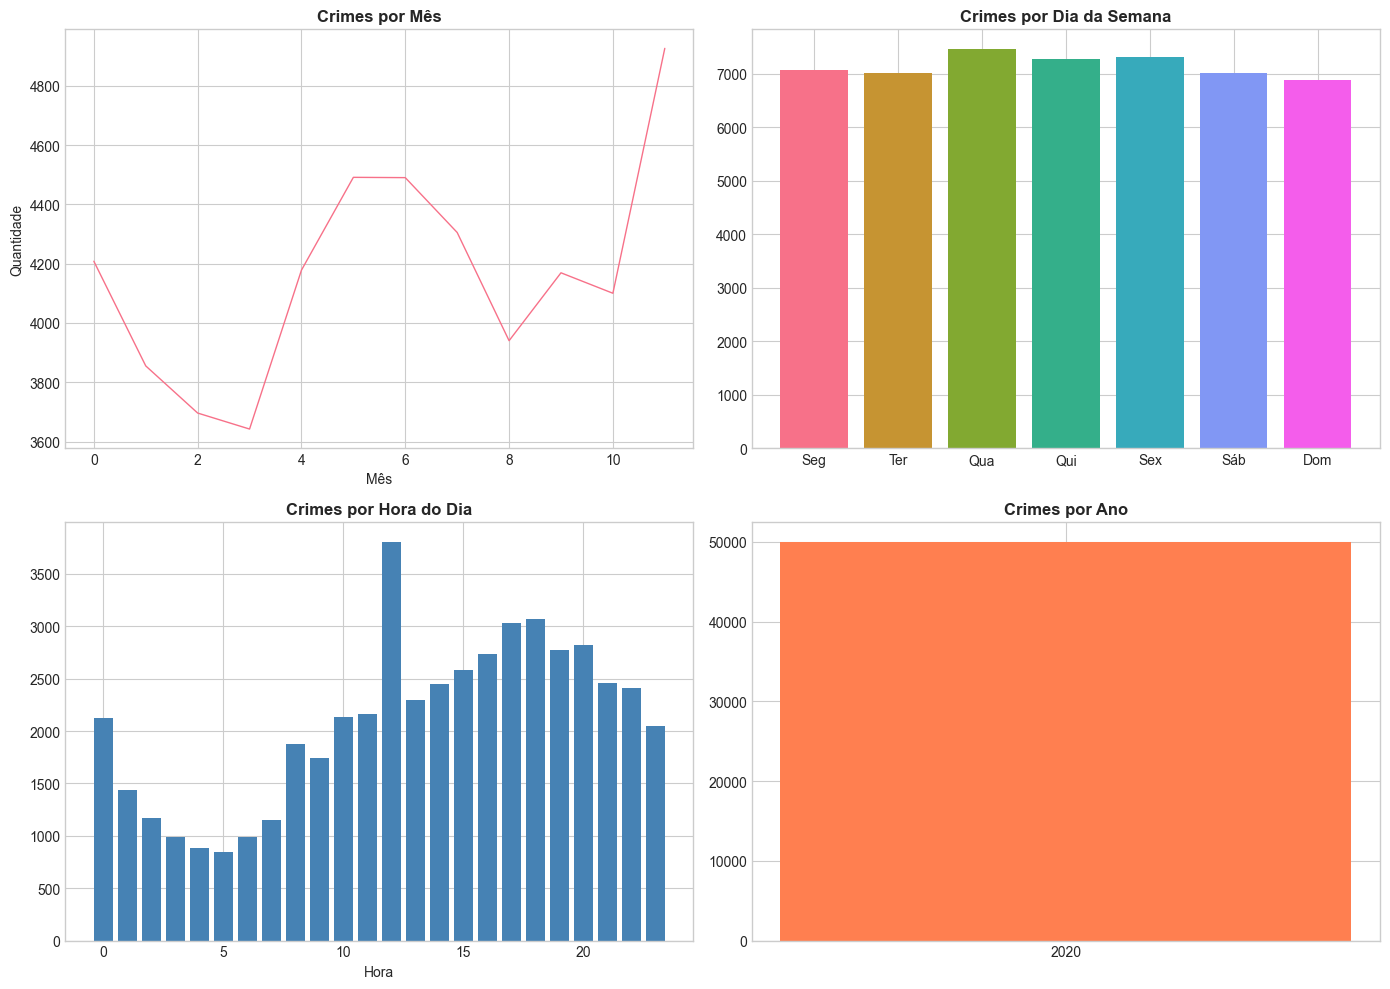


✅ Gráficos temporais gerados!


In [ ]:
# Visualização temporal
if 'date_occurred' in df_silver.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Crimes por mês
    monthly = df_silver.groupby(df_silver['date_occurred'].dt.to_period('M')).size()
    axes[0, 0].plot(range(len(monthly)), monthly.values, marker='', linewidth=1)
    axes[0, 0].set_title('Crimes por Mês', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Mês')
    axes[0, 0].set_ylabel('Quantidade')
    
    # Crimes por dia da semana
    dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    dow = df_silver['day_of_week'].value_counts().reindex(dow_order)
    colors = sns.color_palette('husl', 7)
    axes[0, 1].bar(range(7), dow.values, color=colors)
    axes[0, 1].set_xticks(range(7))
    axes[0, 1].set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom'])
    axes[0, 1].set_title('Crimes por Dia da Semana', fontsize=12, fontweight='bold')
    
    # Crimes por hora (se disponível)
    if 'time_occurred' in df_silver.columns:
        try:
            df_silver['hour'] = pd.to_datetime(df_silver['time_occurred'].astype(str).str.zfill(4), format='%H%M', errors='coerce').dt.hour
            hourly = df_silver.groupby('hour').size()
            axes[1, 0].bar(hourly.index, hourly.values, color='steelblue')
            axes[1, 0].set_title('Crimes por Hora do Dia', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('Hora')
        except:
            axes[1, 0].text(0.5, 0.5, 'Dados de hora não disponíveis', ha='center', va='center')
    
    # Crimes por ano
    yearly = df_silver.groupby('year').size()
    axes[1, 1].bar(yearly.index.astype(str), yearly.values, color='coral')
    axes[1, 1].set_title('Crimes por Ano', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Gráficos temporais gerados!")

## 4. Análise de Tipos de Crime

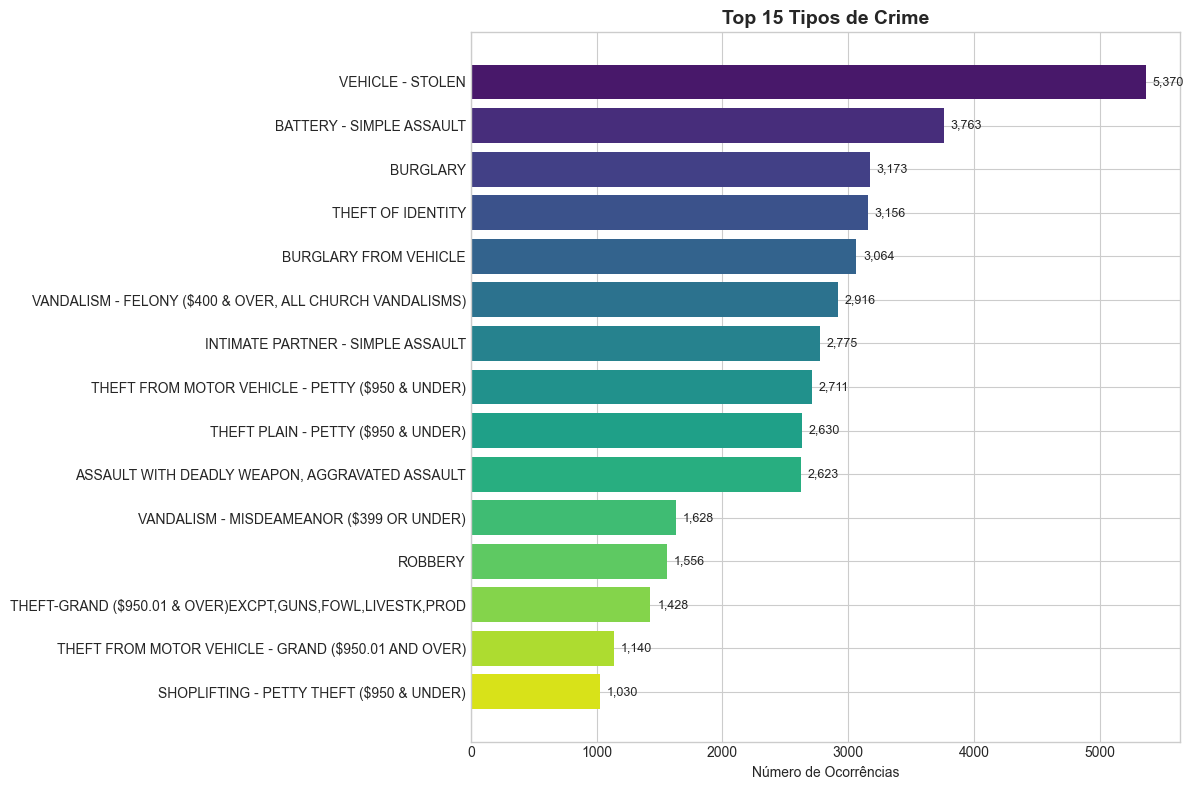


📊 Concentração dos Crimes:
   Top 5 tipos: 37.1% dos crimes
   Top 10 tipos: 64.4% dos crimes


In [ ]:
# Top 15 tipos de crime
if 'crime_description' in df_silver.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_crimes = df_silver['crime_description'].value_counts().head(15)
    
    bars = ax.barh(range(len(top_crimes)), top_crimes.values, color=sns.color_palette('viridis', 15))
    ax.set_yticks(range(len(top_crimes)))
    ax.set_yticklabels(top_crimes.index)
    ax.invert_yaxis()
    
    # Adicionar valores
    for i, (bar, val) in enumerate(zip(bars, top_crimes.values)):
        ax.text(val + max(top_crimes.values) * 0.01, i, f'{val:,}', va='center', fontsize=9)
    
    ax.set_xlabel('Número de Ocorrências')
    ax.set_title('Top 15 Tipos de Crime', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Estatísticas
    print(f"\n📊 Concentração dos Crimes:")
    total = len(df_silver)
    top5_pct = 100 * top_crimes.head(5).sum() / total
    top10_pct = 100 * top_crimes.head(10).sum() / total
    print(f"   Top 5 tipos: {top5_pct:.1f}% dos crimes")
    print(f"   Top 10 tipos: {top10_pct:.1f}% dos crimes")

## 5. Análise Geográfica

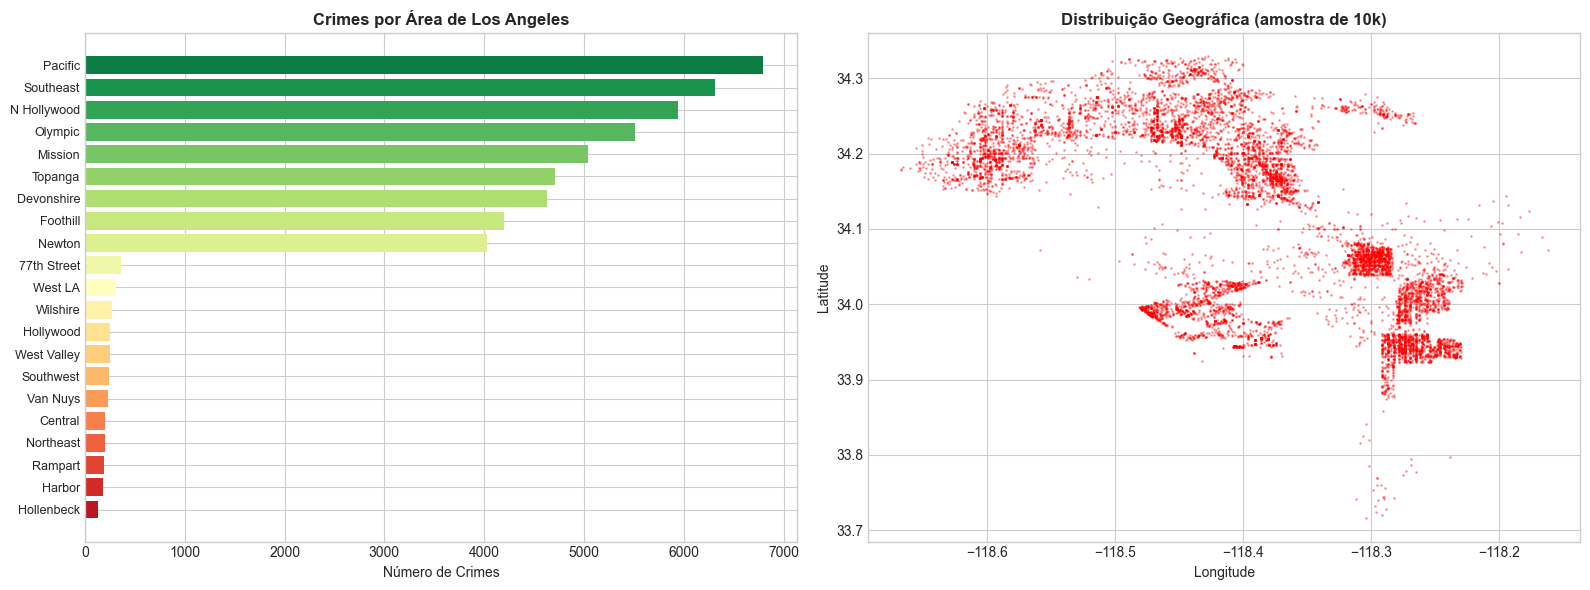


🔴 Top 5 Áreas com Mais Crimes:
   1. Pacific: 6,792 (13.6%)
   2. Southeast: 6,314 (12.6%)
   3. N Hollywood: 5,945 (11.9%)
   4. Olympic: 5,513 (11.0%)
   5. Mission: 5,042 (10.1%)


In [ ]:
# Crimes por área
if 'area_name' in df_silver.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Barras
    area_counts = df_silver['area_name'].value_counts()
    colors = sns.color_palette('RdYlGn_r', len(area_counts))
    
    axes[0].barh(range(len(area_counts)), area_counts.values, color=colors)
    axes[0].set_yticks(range(len(area_counts)))
    axes[0].set_yticklabels(area_counts.index, fontsize=9)
    axes[0].invert_yaxis()
    axes[0].set_xlabel('Número de Crimes')
    axes[0].set_title('Crimes por Área de Los Angeles', fontsize=12, fontweight='bold')
    
    # Mapa de dispersão
    if 'latitude' in df_silver.columns and 'longitude' in df_silver.columns:
        valid = df_silver[(df_silver['latitude'] != 0) & (df_silver['longitude'] != 0)]
        sample = valid.sample(min(10000, len(valid)), random_state=42)
        
        axes[1].scatter(sample['longitude'], sample['latitude'], alpha=0.3, s=1, c='red')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        axes[1].set_title('Distribuição Geográfica (amostra de 10k)', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Top 5 áreas mais perigosas
    print("\n🔴 Top 5 Áreas com Mais Crimes:")
    for i, (area, count) in enumerate(area_counts.head(5).items(), 1):
        pct = 100 * count / len(df_silver)
        print(f"   {i}. {area}: {count:,} ({pct:.1f}%)")

## 6. Perfil das Vítimas

PERFIL DAS VÍTIMAS


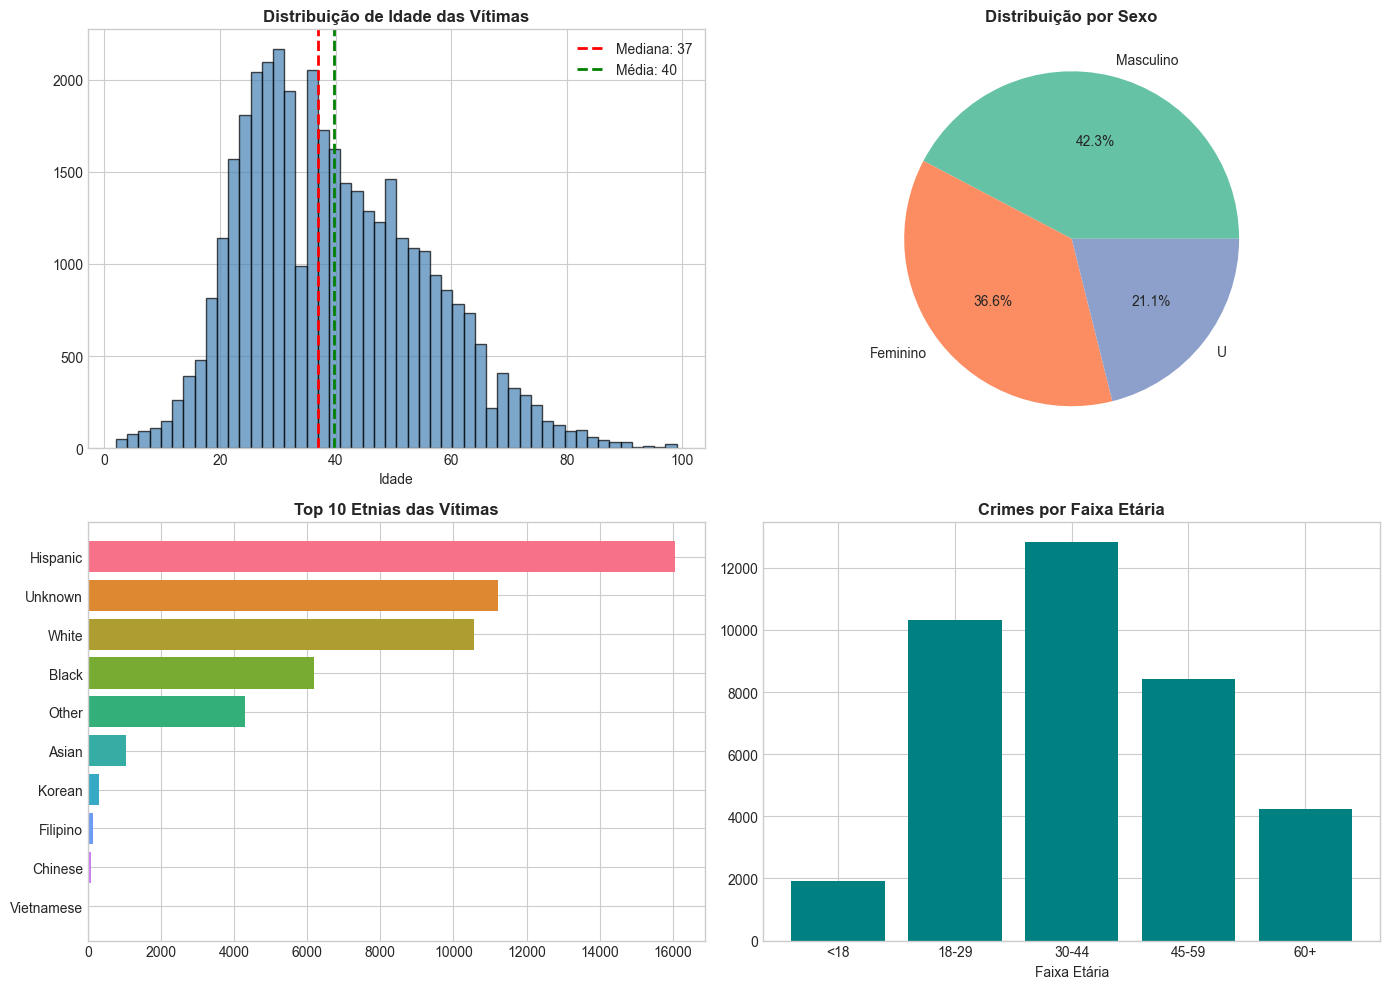

In [ ]:
# Análise de vítimas
print("="*60)
print("PERFIL DAS VÍTIMAS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Idade
if 'victim_age' in df_silver.columns:
    valid_ages = df_silver[(df_silver['victim_age'] > 0) & (df_silver['victim_age'] < 120)]['victim_age']
    axes[0, 0].hist(valid_ages, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[0, 0].axvline(valid_ages.median(), color='red', linestyle='--', linewidth=2, label=f'Mediana: {valid_ages.median():.0f}')
    axes[0, 0].axvline(valid_ages.mean(), color='green', linestyle='--', linewidth=2, label=f'Média: {valid_ages.mean():.0f}')
    axes[0, 0].set_title('Distribuição de Idade das Vítimas', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Idade')
    axes[0, 0].legend()

# Sexo
if 'victim_sex' in df_silver.columns:
    sex_counts = df_silver['victim_sex'].value_counts()
    sex_labels = {'M': 'Masculino', 'F': 'Feminino', 'X': 'Desconhecido', 'H': 'Outro'}
    labels = [sex_labels.get(s, s) for s in sex_counts.index]
    axes[0, 1].pie(sex_counts.values, labels=labels, autopct='%1.1f%%', colors=sns.color_palette('Set2'))
    axes[0, 1].set_title('Distribuição por Sexo', fontsize=12, fontweight='bold')

# Descendência
if 'victim_descent' in df_silver.columns:
    descent_counts = df_silver['victim_descent'].value_counts().head(10)
    descent_labels = {
        'H': 'Hispanic', 'W': 'White', 'B': 'Black', 'O': 'Other',
        'A': 'Asian', 'X': 'Unknown', 'K': 'Korean', 'F': 'Filipino',
        'C': 'Chinese', 'J': 'Japanese', 'V': 'Vietnamese'
    }
    labels = [descent_labels.get(d, d) for d in descent_counts.index]
    axes[1, 0].barh(range(len(descent_counts)), descent_counts.values, color=sns.color_palette('husl', 10))
    axes[1, 0].set_yticks(range(len(descent_counts)))
    axes[1, 0].set_yticklabels(labels)
    axes[1, 0].invert_yaxis()
    axes[1, 0].set_title('Top 10 Etnias das Vítimas', fontsize=12, fontweight='bold')

# Faixa etária
if 'victim_age' in df_silver.columns:
    bins = [0, 18, 30, 45, 60, 120]
    labels = ['<18', '18-29', '30-44', '45-59', '60+']
    df_silver['age_group'] = pd.cut(df_silver['victim_age'], bins=bins, labels=labels)
    age_group = df_silver['age_group'].value_counts().sort_index()
    axes[1, 1].bar(age_group.index.astype(str), age_group.values, color='teal')
    axes[1, 1].set_title('Crimes por Faixa Etária', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Faixa Etária')

plt.tight_layout()
plt.show()

## 7. Clustering e Padrões

In [ ]:
# Preparar dados para clustering
print("="*60)
print("ANÁLISE DE CLUSTERING")
print("="*60)

# Selecionar features numéricas para clustering
cluster_features = []
if 'latitude' in df_silver.columns:
    cluster_features.append('latitude')
if 'longitude' in df_silver.columns:
    cluster_features.append('longitude')
if 'victim_age' in df_silver.columns:
    cluster_features.append('victim_age')

if len(cluster_features) >= 2:
    # Filtrar dados válidos
    df_cluster = df_silver.copy()
    if 'latitude' in cluster_features:
        df_cluster = df_cluster[(df_cluster['latitude'] != 0) & (df_cluster['longitude'] != 0)]
    if 'victim_age' in cluster_features:
        df_cluster = df_cluster[(df_cluster['victim_age'] > 0) & (df_cluster['victim_age'] < 120)]
    
    # Amostrar para performance
    sample_size = min(10000, len(df_cluster))
    df_sample = df_cluster.sample(sample_size, random_state=42)
    
    print(f"\n🔍 Features para clustering: {cluster_features}")
    print(f"   Amostra: {sample_size:,} registros")
    
    # Aplicar clustering
    df_clustered, model = perform_clustering(
        df_sample, 
        features=cluster_features,
        n_clusters=5,
        method='kmeans'
    )
    
    print(f"\n📊 Distribuição dos Clusters:")
    cluster_dist = df_clustered['Cluster'].value_counts().sort_index()
    for cluster, count in cluster_dist.items():
        print(f"   Cluster {int(cluster)}: {count:,} ({100*count/len(df_clustered):.1f}%)")
else:
    print("\n⚠️ Não há features numéricas suficientes para clustering")

ANÁLISE DE CLUSTERING

🔍 Features para clustering: ['latitude', 'longitude', 'victim_age']
   Amostra: 10,000 registros
Silhouette Score: 0.347

📊 Distribuição dos Clusters:
   Cluster 0: 2,989 (29.9%)
   Cluster 1: 1,487 (14.9%)
   Cluster 2: 1,813 (18.1%)
   Cluster 3: 1,394 (13.9%)
   Cluster 4: 2,283 (22.8%)


Variância explicada: 87.01%


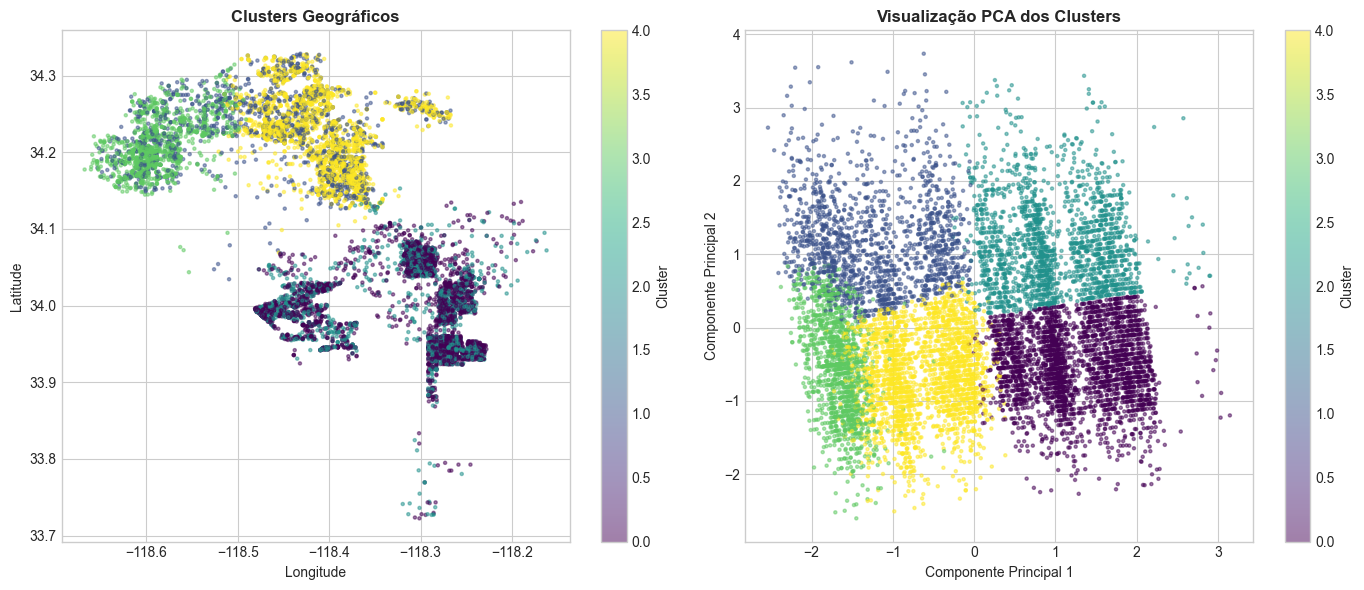

In [ ]:
# Visualização dos clusters
if 'df_clustered' in dir() and 'Cluster' in df_clustered.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Clusters no espaço geográfico
    if 'latitude' in cluster_features and 'longitude' in cluster_features:
        scatter = axes[0].scatter(
            df_clustered['longitude'], 
            df_clustered['latitude'],
            c=df_clustered['Cluster'],
            cmap='viridis',
            alpha=0.5,
            s=5
        )
        plt.colorbar(scatter, ax=axes[0], label='Cluster')
        axes[0].set_xlabel('Longitude')
        axes[0].set_ylabel('Latitude')
        axes[0].set_title('Clusters Geográficos', fontsize=12, fontweight='bold')
    
    # PCA
    X_pca, pca = apply_pca(df_clustered, features=cluster_features, n_components=2)
    scatter2 = axes[1].scatter(
        X_pca[:, 0], 
        X_pca[:, 1],
        c=df_clustered['Cluster'].dropna(),
        cmap='viridis',
        alpha=0.5,
        s=5
    )
    plt.colorbar(scatter2, ax=axes[1], label='Cluster')
    axes[1].set_xlabel('Componente Principal 1')
    axes[1].set_ylabel('Componente Principal 2')
    axes[1].set_title('Visualização PCA dos Clusters', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 8. Detecção de Anomalias

DETECÇÃO DE ANOMALIAS
Anomalias detectadas: 499.0 (4.99%)


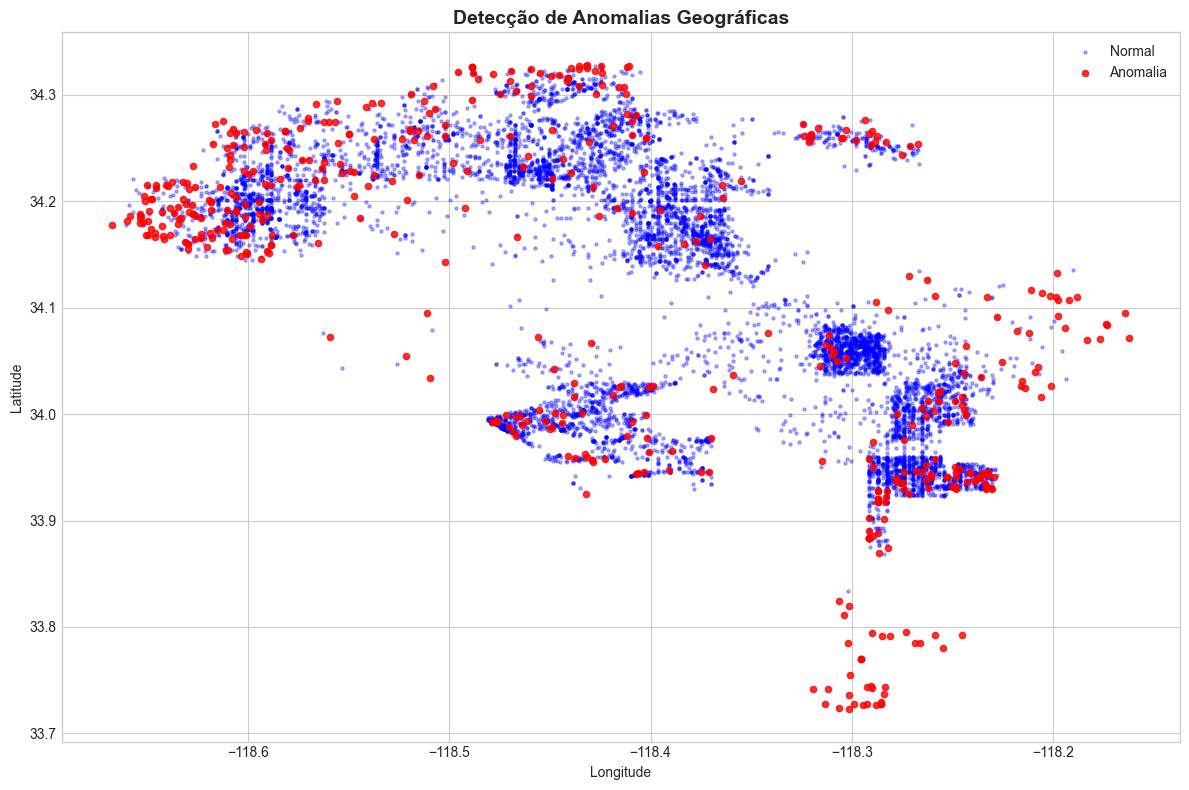

In [ ]:
# Detecção de anomalias
print("="*60)
print("DETECÇÃO DE ANOMALIAS")
print("="*60)

if len(cluster_features) >= 2 and 'df_sample' in dir():
    df_anomalies = detect_anomalies(
        df_sample,
        features=cluster_features,
        contamination=0.05
    )
    
    # Visualizar anomalias
    if 'latitude' in cluster_features and 'longitude' in cluster_features:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        normal = df_anomalies[df_anomalies['Is_Anomaly'] == 0]
        anomalies = df_anomalies[df_anomalies['Is_Anomaly'] == 1]
        
        ax.scatter(normal['longitude'], normal['latitude'], alpha=0.3, s=5, c='blue', label='Normal')
        ax.scatter(anomalies['longitude'], anomalies['latitude'], alpha=0.8, s=20, c='red', label='Anomalia')
        
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title('Detecção de Anomalias Geográficas', fontsize=14, fontweight='bold')
        ax.legend()
        
        plt.tight_layout()
        plt.show()
else:
    print("\n⚠️ Dados insuficientes para detecção de anomalias")

## 9. Correlações

ANÁLISE DE CORRELAÇÕES


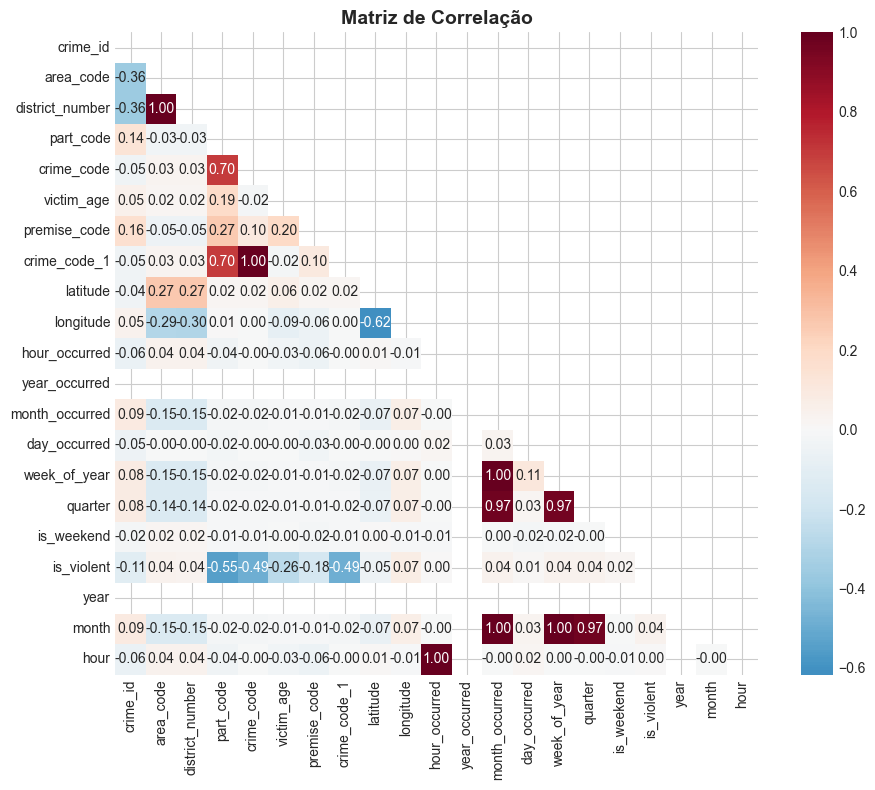


🔗 Correlações Mais Fortes (excluindo diagonal):
   crime_id ↔ area_code: -0.362
   crime_id ↔ district_number: -0.362
   crime_id ↔ premise_code: 0.160
   crime_id ↔ year_occurred: nan
   crime_id ↔ year: nan


In [ ]:
# Matriz de correlação
print("="*60)
print("ANÁLISE DE CORRELAÇÕES")
print("="*60)

numeric_df = df_silver.select_dtypes(include=[np.number])

if len(numeric_df.columns) >= 2:
    # Remover colunas com muitos NaN
    valid_cols = numeric_df.columns[numeric_df.notna().mean() > 0.5]
    numeric_df = numeric_df[valid_cols]
    
    if len(numeric_df.columns) >= 2:
        corr_matrix = numeric_df.corr()
        
        fig, ax = plt.subplots(figsize=(10, 8))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0, 
                    annot=True, fmt='.2f', ax=ax, square=True)
        ax.set_title('Matriz de Correlação', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Correlações mais fortes
        print("\n🔗 Correlações Mais Fortes (excluindo diagonal):")
        corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))
        
        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        for col1, col2, corr in corr_pairs[:5]:
            print(f"   {col1} ↔ {col2}: {corr:.3f}")

## 10. Resumo Estatístico

In [ ]:
# Resumo final
print("\n" + "="*60)
print("📊 RESUMO DA ANÁLISE ESTATÍSTICA")
print("="*60)

print(f"\n📁 Dataset: Crime Data from 2020 to Present - LAPD")
print(f"📈 Total de registros analisados: {len(df_silver):,}")

if 'date_occurred' in df_silver.columns:
    print(f"📅 Período: {df_silver['date_occurred'].min().date()} a {df_silver['date_occurred'].max().date()}")

if 'crime_description' in df_silver.columns:
    print(f"🔍 Tipos de crime: {df_silver['crime_description'].nunique()}")
    print(f"   Mais comum: {df_silver['crime_description'].mode().iloc[0]}")

if 'area_name' in df_silver.columns:
    print(f"📍 Áreas: {df_silver['area_name'].nunique()}")
    print(f"   Mais crimes: {df_silver['area_name'].mode().iloc[0]}")

if 'victim_age' in df_silver.columns:
    valid_ages = df_silver[(df_silver['victim_age'] > 0) & (df_silver['victim_age'] < 120)]['victim_age']
    print(f"👤 Idade média das vítimas: {valid_ages.mean():.1f} anos")

print("\n✅ Análise estatística concluída com sucesso!")
print("="*60)


📊 RESUMO DA ANÁLISE ESTATÍSTICA

📁 Dataset: Crime Data from 2020 to Present - LAPD
📈 Total de registros analisados: 50,000
📅 Período: 2020-01-01 a 2020-12-31
🔍 Tipos de crime: 121
   Mais comum: VEHICLE - STOLEN
📍 Áreas: 21
   Mais crimes: Pacific
👤 Idade média das vítimas: 39.7 anos

✅ Análise estatística concluída com sucesso!


---
# 📈 ANÁLISE EXPLORATÓRIA AVANÇADA (EDA)

Análises detalhadas da evolução da criminalidade, padrões temporais e distribuição por tipo de crime.

In [ ]:
# Carregar dados completos do CSV original para análise multi-ano
import os

# Verificar se há mais dados disponíveis
RAW_PATH = PROJECT_ROOT / "Crime_Data_from_2020_to_Present.csv"

if RAW_PATH.exists():
    print(f"📂 Carregando dados completos de: {RAW_PATH}")
    df_full = pd.read_csv(RAW_PATH, low_memory=False)
    
    # Converter datas
    df_full['DATE OCC'] = pd.to_datetime(df_full['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    df_full['Date Rptd'] = pd.to_datetime(df_full['Date Rptd'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
    
    # Extrair componentes temporais
    df_full['year'] = df_full['DATE OCC'].dt.year
    df_full['month'] = df_full['DATE OCC'].dt.month
    df_full['day'] = df_full['DATE OCC'].dt.day
    df_full['hour'] = df_full['TIME OCC'] // 100
    df_full['day_of_week'] = df_full['DATE OCC'].dt.dayofweek
    df_full['day_name'] = df_full['DATE OCC'].dt.day_name()
    df_full['week_of_year'] = df_full['DATE OCC'].dt.isocalendar().week
    df_full['quarter'] = df_full['DATE OCC'].dt.quarter
    
    # Definir estações do ano
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Inverno'
        elif month in [3, 4, 5]:
            return 'Primavera'
        elif month in [6, 7, 8]:
            return 'Verão'
        else:
            return 'Outono'
    
    df_full['season'] = df_full['month'].apply(get_season)
    
    # Período do dia
    def get_period(hour):
        if 5 <= hour < 12:
            return 'Manhã'
        elif 12 <= hour < 18:
            return 'Tarde'
        elif 18 <= hour < 22:
            return 'Noite'
        else:
            return 'Madrugada'
    
    df_full['period_of_day'] = df_full['hour'].apply(get_period)
    
    # Fim de semana
    df_full['is_weekend'] = df_full['day_of_week'].isin([5, 6]).astype(int)
    
    print(f"\n📊 Dados carregados: {len(df_full):,} registros")
    print(f"📅 Período: {df_full['DATE OCC'].min().date()} a {df_full['DATE OCC'].max().date()}")
    print(f"📆 Anos disponíveis: {sorted(df_full['year'].dropna().unique().astype(int))}")
else:
    print("⚠️ Usando apenas dados da camada Silver (amostra)")
    df_full = df_silver.copy()
    df_full['DATE OCC'] = df_full['date_occurred']
    df_full['year'] = df_full['DATE OCC'].dt.year
    df_full['Crm Cd Desc'] = df_full['crime_description']
    df_full['AREA NAME'] = df_full['area_name']
    df_full['LAT'] = df_full['latitude']
    df_full['LON'] = df_full['longitude']
    df_full['Vict Age'] = df_full['victim_age']
    df_full['TIME OCC'] = df_full['time_occurred']
    df_full['hour'] = df_full['hour_occurred']

📂 Carregando dados completos de: D:\Estudo\UnB\SBD2_opcao1\SBD2\Crime_Data_from_2020_to_Present.csv

📊 Dados carregados: 1,004,991 registros
📅 Período: 2020-01-01 a 2025-05-29
📆 Anos disponíveis: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


📈 EVOLUÇÃO DA CRIMINALIDADE - ANÁLISE TEMPORAL MULTI-ANO

📊 Variação Anual:
   2020 → 2021: +5.0%
   2021 → 2022: +12.1%
   2022 → 2023: -1.2%
   2023 → 2024: -45.1%
   2024 → 2025: -99.9%


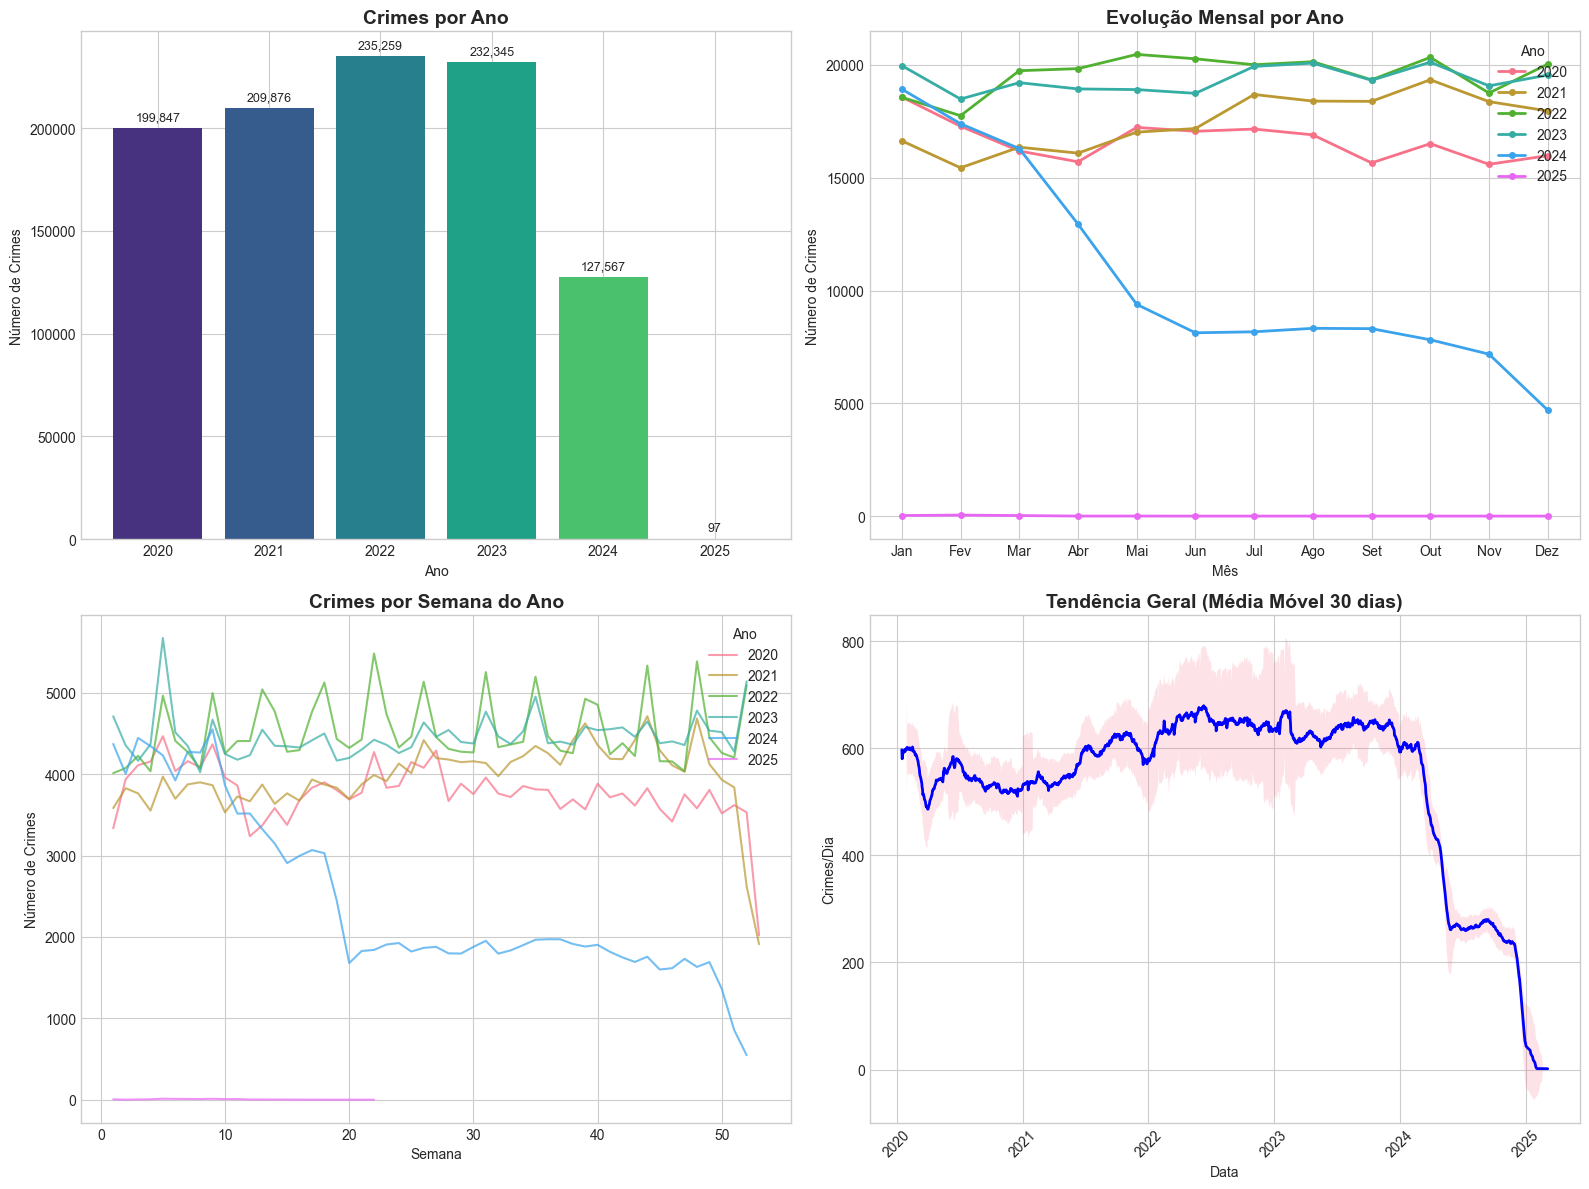


📈 Tendência de Longo Prazo:
   2020 → 2025: -100.0%


In [ ]:
# 11.1 Evolução da Criminalidade ao Longo do Tempo
print("="*70)
print("📈 EVOLUÇÃO DA CRIMINALIDADE - ANÁLISE TEMPORAL MULTI-ANO")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Crimes por ano
yearly_crimes = df_full.groupby('year').size()
ax1 = axes[0, 0]
bars = ax1.bar(yearly_crimes.index.astype(int).astype(str), yearly_crimes.values, 
               color=sns.color_palette('viridis', len(yearly_crimes)))
ax1.set_title('Crimes por Ano', fontsize=14, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Crimes')
for bar, val in zip(bars, yearly_crimes.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + max(yearly_crimes)*0.01, 
             f'{val:,}', ha='center', va='bottom', fontsize=9)

# Calcular variação percentual
if len(yearly_crimes) > 1:
    pct_changes = yearly_crimes.pct_change() * 100
    print("\n📊 Variação Anual:")
    for yr, pct in pct_changes.dropna().items():
        print(f"   {int(yr-1)} → {int(yr)}: {pct:+.1f}%")

# Crimes por mês (todas os anos)
monthly_crimes = df_full.groupby([df_full['year'], df_full['month']]).size().unstack(fill_value=0)
ax2 = axes[0, 1]
for year in monthly_crimes.index:
    ax2.plot(monthly_crimes.columns, monthly_crimes.loc[year], marker='o', 
             label=str(int(year)), linewidth=2, markersize=4)
ax2.set_title('Evolução Mensal por Ano', fontsize=14, fontweight='bold')
ax2.set_xlabel('Mês')
ax2.set_ylabel('Número de Crimes')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax2.legend(title='Ano', loc='upper right')

# Crimes por semana do ano
weekly = df_full.groupby(['year', 'week_of_year']).size().reset_index(name='count')
ax3 = axes[1, 0]
for year in weekly['year'].unique():
    data = weekly[weekly['year'] == year]
    ax3.plot(data['week_of_year'], data['count'], alpha=0.7, label=str(int(year)))
ax3.set_title('Crimes por Semana do Ano', fontsize=14, fontweight='bold')
ax3.set_xlabel('Semana')
ax3.set_ylabel('Número de Crimes')
ax3.legend(title='Ano', loc='upper right')

# Tendência geral (média móvel)
ax4 = axes[1, 1]
daily = df_full.groupby(df_full['DATE OCC'].dt.date).size()
daily_series = pd.Series(daily.values, index=pd.to_datetime(daily.index))
ma_30 = daily_series.rolling(window=30, center=True).mean()
ax4.plot(daily_series.index, ma_30, color='blue', linewidth=2, label='Média Móvel 30 dias')
ax4.fill_between(daily_series.index, ma_30 - daily_series.rolling(30).std(), 
                  ma_30 + daily_series.rolling(30).std(), alpha=0.2)
ax4.set_title('Tendência Geral (Média Móvel 30 dias)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Data')
ax4.set_ylabel('Crimes/Dia')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Estatísticas de tendência
print(f"\n📈 Tendência de Longo Prazo:")
first_year = yearly_crimes.iloc[0]
last_year = yearly_crimes.iloc[-1]
total_change = ((last_year - first_year) / first_year) * 100
print(f"   {int(yearly_crimes.index[0])} → {int(yearly_crimes.index[-1])}: {total_change:+.1f}%")

🔥 HEATMAP: HORA DO DIA × DIA DA SEMANA


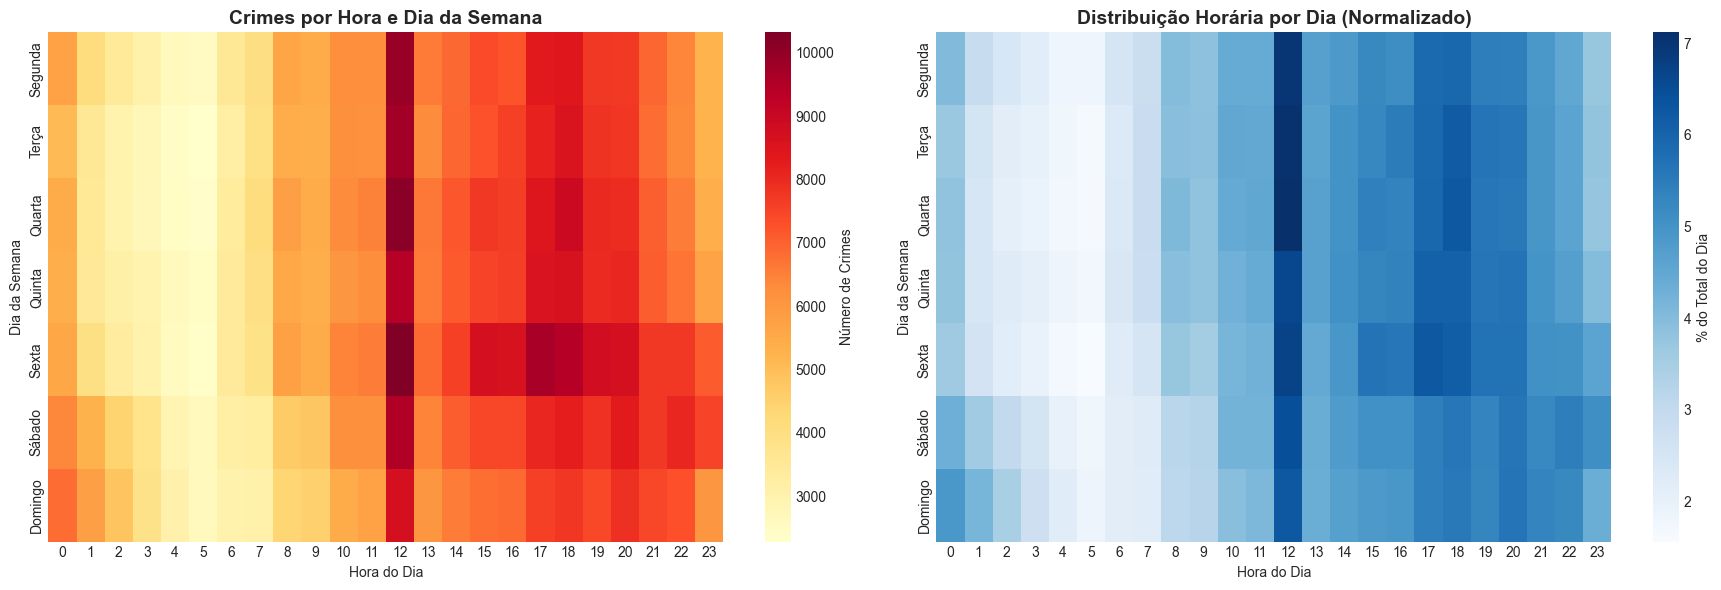


🌙 Análise de Padrões:
   Madrugada (00h-05h): 153,681 (15.3%)
   Manhã (06h-11h): 209,918 (20.9%)
   Tarde (12h-17h): 327,312 (32.6%)
   Noite (18h-23h): 314,080 (31.3%)

📅 Comparação Dias Úteis vs Fim de Semana:
   Média diária (dias úteis): 143,577 crimes
   Média diária (fim de semana): 143,554 crimes
   Diferença: -0.0%


In [ ]:
# 11.2 Heatmap Hora x Dia da Semana
print("="*70)
print("🔥 HEATMAP: HORA DO DIA × DIA DA SEMANA")
print("="*70)

# Criar pivot table
heatmap_data = df_full.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0)

# Reordenar dias
day_order = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
heatmap_data.index = day_order

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap geral
ax1 = axes[0]
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='d', ax=ax1,
            cbar_kws={'label': 'Número de Crimes'})
ax1.set_title('Crimes por Hora e Dia da Semana', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hora do Dia')
ax1.set_ylabel('Dia da Semana')

# Heatmap normalizado por dia
heatmap_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100
ax2 = axes[1]
sns.heatmap(heatmap_norm, cmap='Blues', annot=False, fmt='.1f', ax=ax2,
            cbar_kws={'label': '% do Total do Dia'})
ax2.set_title('Distribuição Horária por Dia (Normalizado)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hora do Dia')
ax2.set_ylabel('Dia da Semana')

plt.tight_layout()
plt.show()

# Análise de padrões
print("\n🌙 Análise de Padrões:")
madrugada = df_full[df_full['hour'].between(0, 5)].shape[0]
manha = df_full[df_full['hour'].between(6, 11)].shape[0]
tarde = df_full[df_full['hour'].between(12, 17)].shape[0]
noite = df_full[df_full['hour'].between(18, 23)].shape[0]
total = len(df_full)

print(f"   Madrugada (00h-05h): {madrugada:,} ({100*madrugada/total:.1f}%)")
print(f"   Manhã (06h-11h): {manha:,} ({100*manha/total:.1f}%)")
print(f"   Tarde (12h-17h): {tarde:,} ({100*tarde/total:.1f}%)")
print(f"   Noite (18h-23h): {noite:,} ({100*noite/total:.1f}%)")

# Diferença fim de semana vs dias úteis
weekday_crimes = df_full[df_full['is_weekend'] == 0].shape[0]
weekend_crimes = df_full[df_full['is_weekend'] == 1].shape[0]
weekday_avg = weekday_crimes / 5
weekend_avg = weekend_crimes / 2

print(f"\n📅 Comparação Dias Úteis vs Fim de Semana:")
print(f"   Média diária (dias úteis): {weekday_avg:,.0f} crimes")
print(f"   Média diária (fim de semana): {weekend_avg:,.0f} crimes")
print(f"   Diferença: {((weekend_avg/weekday_avg)-1)*100:+.1f}%")

🔍 ANÁLISE DE TIPOS DE CRIME


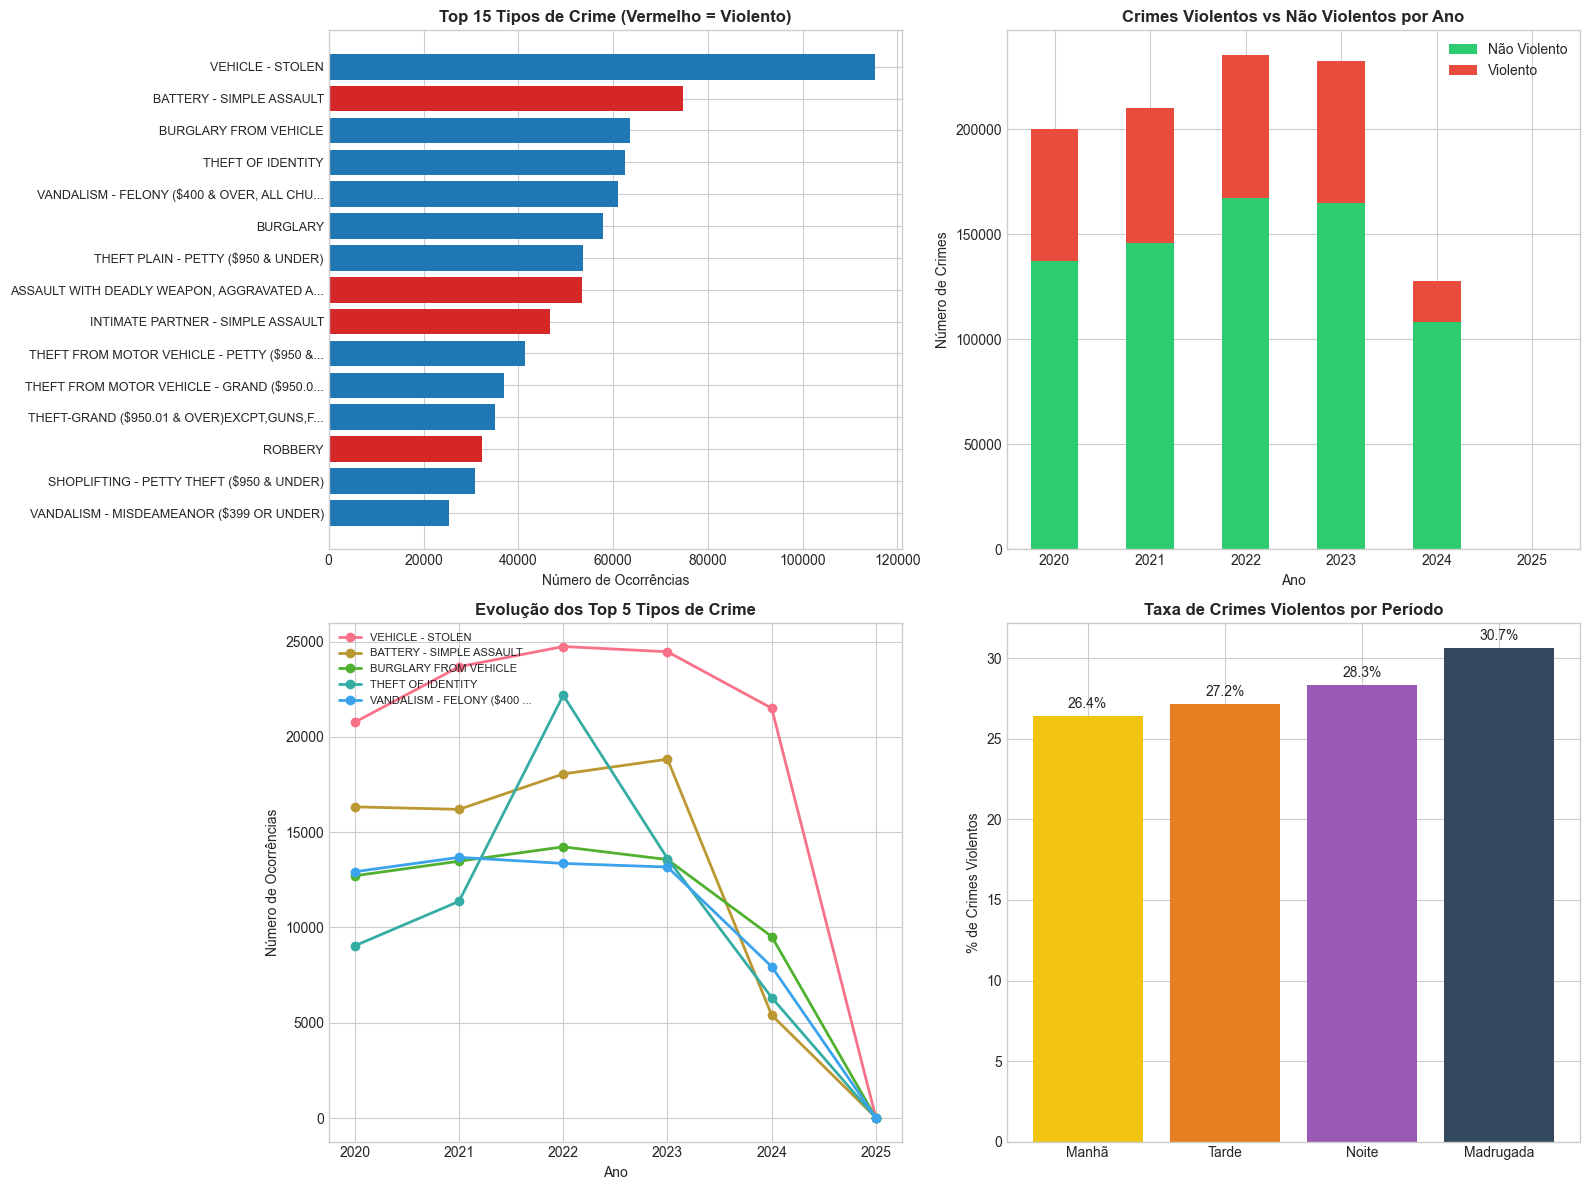


📊 Estatísticas de Crimes Violentos:
   Total violentos: 281,922 (28.1%)
   Total não violentos: 723,069 (71.9%)


In [ ]:
# 11.3 Tipos de Crime - Evolução e Violentos vs Não Violentos
print("="*70)
print("🔍 ANÁLISE DE TIPOS DE CRIME")
print("="*70)

# Definir crimes violentos (baseado em códigos Part 1)
violent_keywords = ['ASSAULT', 'ROBBERY', 'HOMICIDE', 'RAPE', 'MURDER', 'KIDNAPPING', 
                    'BATTERY', 'WEAPON', 'SHOOTING', 'MANSLAUGHTER']

# Criar coluna de crime violento
crime_col = 'Crm Cd Desc' if 'Crm Cd Desc' in df_full.columns else 'crime_description'
df_full['is_violent'] = df_full[crime_col].fillna('').apply(
    lambda x: any(v in str(x).upper() for v in violent_keywords)
).astype(int)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 15 tipos de crime
ax1 = axes[0, 0]
top_crimes = df_full[crime_col].value_counts().head(15)
colors = ['#d62728' if any(v in str(c).upper() for v in violent_keywords) else '#1f77b4' 
          for c in top_crimes.index]
bars = ax1.barh(range(len(top_crimes)), top_crimes.values, color=colors)
ax1.set_yticks(range(len(top_crimes)))
ax1.set_yticklabels([c[:40] + '...' if len(c) > 40 else c for c in top_crimes.index], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Número de Ocorrências')
ax1.set_title('Top 15 Tipos de Crime (Vermelho = Violento)', fontsize=12, fontweight='bold')

# Proporção violentos vs não violentos por ano
ax2 = axes[0, 1]
violent_by_year = df_full.groupby(['year', 'is_violent']).size().unstack(fill_value=0)
violent_by_year.columns = ['Não Violento', 'Violento']
violent_by_year.plot(kind='bar', stacked=True, ax=ax2, color=['#2ecc71', '#e74c3c'])
ax2.set_title('Crimes Violentos vs Não Violentos por Ano', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Crimes')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(loc='upper right')

# Evolução dos top 5 crimes ao longo do tempo
ax3 = axes[1, 0]
top5_crimes = df_full[crime_col].value_counts().head(5).index
for crime in top5_crimes:
    crime_evolution = df_full[df_full[crime_col] == crime].groupby('year').size()
    label = crime[:25] + '...' if len(crime) > 25 else crime
    ax3.plot(crime_evolution.index, crime_evolution.values, marker='o', label=label, linewidth=2)
ax3.set_title('Evolução dos Top 5 Tipos de Crime', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano')
ax3.set_ylabel('Número de Ocorrências')
ax3.legend(loc='upper left', fontsize=8)

# Taxa de crimes violentos por período do dia
ax4 = axes[1, 1]
violent_by_period = df_full.groupby('period_of_day')['is_violent'].agg(['sum', 'count'])
violent_by_period['rate'] = violent_by_period['sum'] / violent_by_period['count'] * 100
order = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
violent_by_period = violent_by_period.reindex(order)
bars = ax4.bar(violent_by_period.index, violent_by_period['rate'], 
               color=['#f1c40f', '#e67e22', '#9b59b6', '#34495e'])
ax4.set_title('Taxa de Crimes Violentos por Período', fontsize=12, fontweight='bold')
ax4.set_ylabel('% de Crimes Violentos')
for bar, val in zip(bars, violent_by_period['rate']):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}%', 
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Estatísticas
violent_total = df_full['is_violent'].sum()
print(f"\n📊 Estatísticas de Crimes Violentos:")
print(f"   Total violentos: {violent_total:,} ({100*violent_total/len(df_full):.1f}%)")
print(f"   Total não violentos: {len(df_full)-violent_total:,} ({100*(len(df_full)-violent_total)/len(df_full):.1f}%)")

### 11.4 Análise Detalhada de Crimes Graves (Homicídio, Estupro, Sequestro)

In [ ]:
# Análise detalhada de crimes graves: Homicídio, Estupro e Sequestro
print("="*70)
print("🔴 ANÁLISE DE CRIMES GRAVES")
print("="*70)

# Definir categorias de crimes graves
crime_col = 'Crm Cd Desc' if 'Crm Cd Desc' in df_full.columns else 'crime_description'

# Criar filtros para cada categoria
df_full['crime_category'] = 'Outros'

# Homicídios
homicide_mask = df_full[crime_col].str.contains('HOMICIDE|MANSLAUGHTER', case=False, na=False)
df_full.loc[homicide_mask, 'crime_category'] = 'Homicídio'

# Estupro e Crimes Sexuais Graves
rape_mask = df_full[crime_col].str.contains('RAPE|SEXUAL PENETRATION|SODOMY', case=False, na=False)
df_full.loc[rape_mask, 'crime_category'] = 'Estupro/Crime Sexual Grave'

# Sequestro
kidnap_mask = df_full[crime_col].str.contains('KIDNAP', case=False, na=False)
df_full.loc[kidnap_mask, 'crime_category'] = 'Sequestro'

# Filtrar apenas crimes graves
df_graves = df_full[df_full['crime_category'] != 'Outros'].copy()

print(f"\n📊 RESUMO DE CRIMES GRAVES (2020-2025):")
print("-" * 50)
grave_counts = df_graves['crime_category'].value_counts()
for cat, count in grave_counts.items():
    pct = 100 * count / len(df_full)
    print(f"   {cat}: {count:,} ({pct:.3f}%)")
print(f"\n   TOTAL CRIMES GRAVES: {len(df_graves):,} ({100*len(df_graves)/len(df_full):.2f}%)")

# Detalhamento por tipo específico
print(f"\n📋 DETALHAMENTO POR TIPO DE CRIME:")
print("-" * 50)
for cat in ['Homicídio', 'Estupro/Crime Sexual Grave', 'Sequestro']:
    print(f"\n🔸 {cat.upper()}:")
    subset = df_full[df_full['crime_category'] == cat]
    for crime, count in subset[crime_col].value_counts().items():
        print(f"   - {crime}: {count:,}")

🔴 ANÁLISE DE CRIMES GRAVES

📊 RESUMO DE CRIMES GRAVES (2020-2025):
--------------------------------------------------
   Estupro/Crime Sexual Grave: 5,927 (0.590%)
   Homicídio: 1,577 (0.157%)
   Sequestro: 1,044 (0.104%)

   TOTAL CRIMES GRAVES: 8,548 (0.85%)

📋 DETALHAMENTO POR TIPO DE CRIME:
--------------------------------------------------

🔸 HOMICÍDIO:
   - CRIMINAL HOMICIDE: 1,568
   - MANSLAUGHTER, NEGLIGENT: 9

🔸 ESTUPRO/CRIME SEXUAL GRAVE:
   - RAPE, FORCIBLE: 3,756
   - SEXUAL PENETRATION W/FOREIGN OBJECT: 1,321
   - SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO ANUS OTH: 531
   - RAPE, ATTEMPTED: 319

🔸 SEQUESTRO:
   - KIDNAPPING: 812
   - KIDNAPPING - GRAND ATTEMPT: 232


📈 EVOLUÇÃO ANUAL DE CRIMES GRAVES


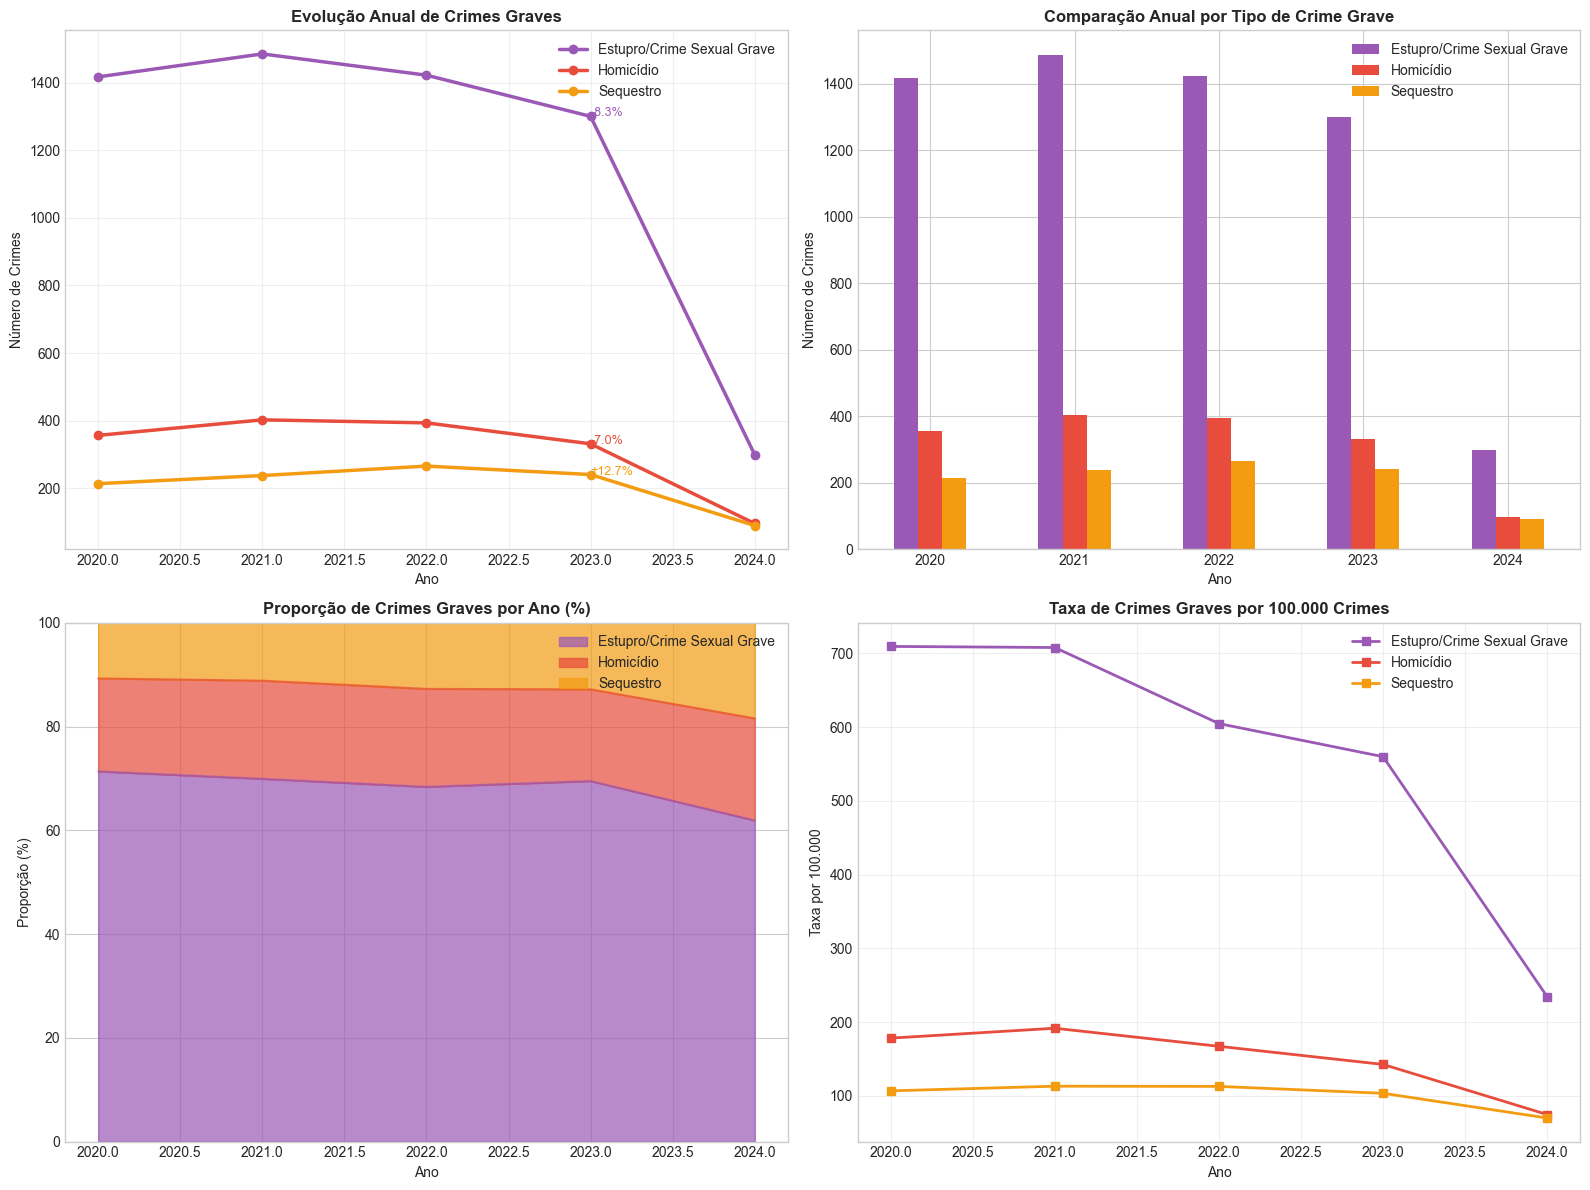


📊 VARIAÇÃO ANUAL:

   Estupro/Crime Sexual Grave:
      2020 → 2021: +4.8%
      2021 → 2022: -4.2%
      2022 → 2023: -8.6%
      2023 → 2024: -77.0%

   Homicídio:
      2020 → 2021: +12.9%
      2021 → 2022: -2.2%
      2022 → 2023: -15.8%
      2023 → 2024: -71.3%

   Sequestro:
      2020 → 2021: +11.3%
      2021 → 2022: +11.8%
      2022 → 2023: -9.4%
      2023 → 2024: -62.9%


In [ ]:
# Evolução anual dos crimes graves
print("="*70)
print("📈 EVOLUÇÃO ANUAL DE CRIMES GRAVES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolução anual por categoria
ax1 = axes[0, 0]
grave_by_year = df_graves.groupby(['year', 'crime_category']).size().unstack(fill_value=0)
colors_graves = {'Homicídio': '#e74c3c', 'Estupro/Crime Sexual Grave': '#9b59b6', 'Sequestro': '#f39c12'}
for cat in grave_by_year.columns:
    ax1.plot(grave_by_year.index, grave_by_year[cat], marker='o', linewidth=2.5, 
             label=cat, color=colors_graves.get(cat, '#333'))
ax1.set_title('Evolução Anual de Crimes Graves', fontsize=12, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Crimes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Adicionar anotações de variação
for cat in grave_by_year.columns:
    if len(grave_by_year) >= 2:
        first_val = grave_by_year[cat].iloc[0]
        last_complete = grave_by_year[cat].iloc[-2] if len(grave_by_year) > 2 else grave_by_year[cat].iloc[-1]
        if first_val > 0:
            var = ((last_complete - first_val) / first_val) * 100
            ax1.annotate(f'{var:+.1f}%', xy=(grave_by_year.index[-2], last_complete),
                        fontsize=9, color=colors_graves.get(cat, '#333'))

# 2. Comparação ano a ano (barras agrupadas)
ax2 = axes[0, 1]
grave_by_year.plot(kind='bar', ax=ax2, color=[colors_graves.get(c, '#333') for c in grave_by_year.columns])
ax2.set_title('Comparação Anual por Tipo de Crime Grave', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Crimes')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(loc='upper right')

# 3. Proporção de cada crime grave por ano
ax3 = axes[1, 0]
grave_pct = grave_by_year.div(grave_by_year.sum(axis=1), axis=0) * 100
grave_pct.plot(kind='area', stacked=True, ax=ax3, alpha=0.7,
               color=[colors_graves.get(c, '#333') for c in grave_pct.columns])
ax3.set_title('Proporção de Crimes Graves por Ano (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano')
ax3.set_ylabel('Proporção (%)')
ax3.legend(loc='upper right')
ax3.set_ylim(0, 100)

# 4. Taxa por 100.000 crimes (normalizado)
ax4 = axes[1, 1]
total_by_year = df_full.groupby('year').size()
rate_per_100k = (grave_by_year.div(total_by_year, axis=0) * 100000).dropna()
rate_per_100k.plot(kind='line', ax=ax4, marker='s', linewidth=2,
                   color=[colors_graves.get(c, '#333') for c in rate_per_100k.columns])
ax4.set_title('Taxa de Crimes Graves por 100.000 Crimes', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Taxa por 100.000')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas de variação
print("\n📊 VARIAÇÃO ANUAL:")
for cat in grave_by_year.columns:
    yearly_vals = grave_by_year[cat]
    if len(yearly_vals) >= 2:
        pct_change = yearly_vals.pct_change().dropna() * 100
        print(f"\n   {cat}:")
        for year, change in pct_change.items():
            print(f"      {int(year-1)} → {int(year)}: {change:+.1f}%")

🗺️ DISTRIBUIÇÃO GEOGRÁFICA DE CRIMES GRAVES


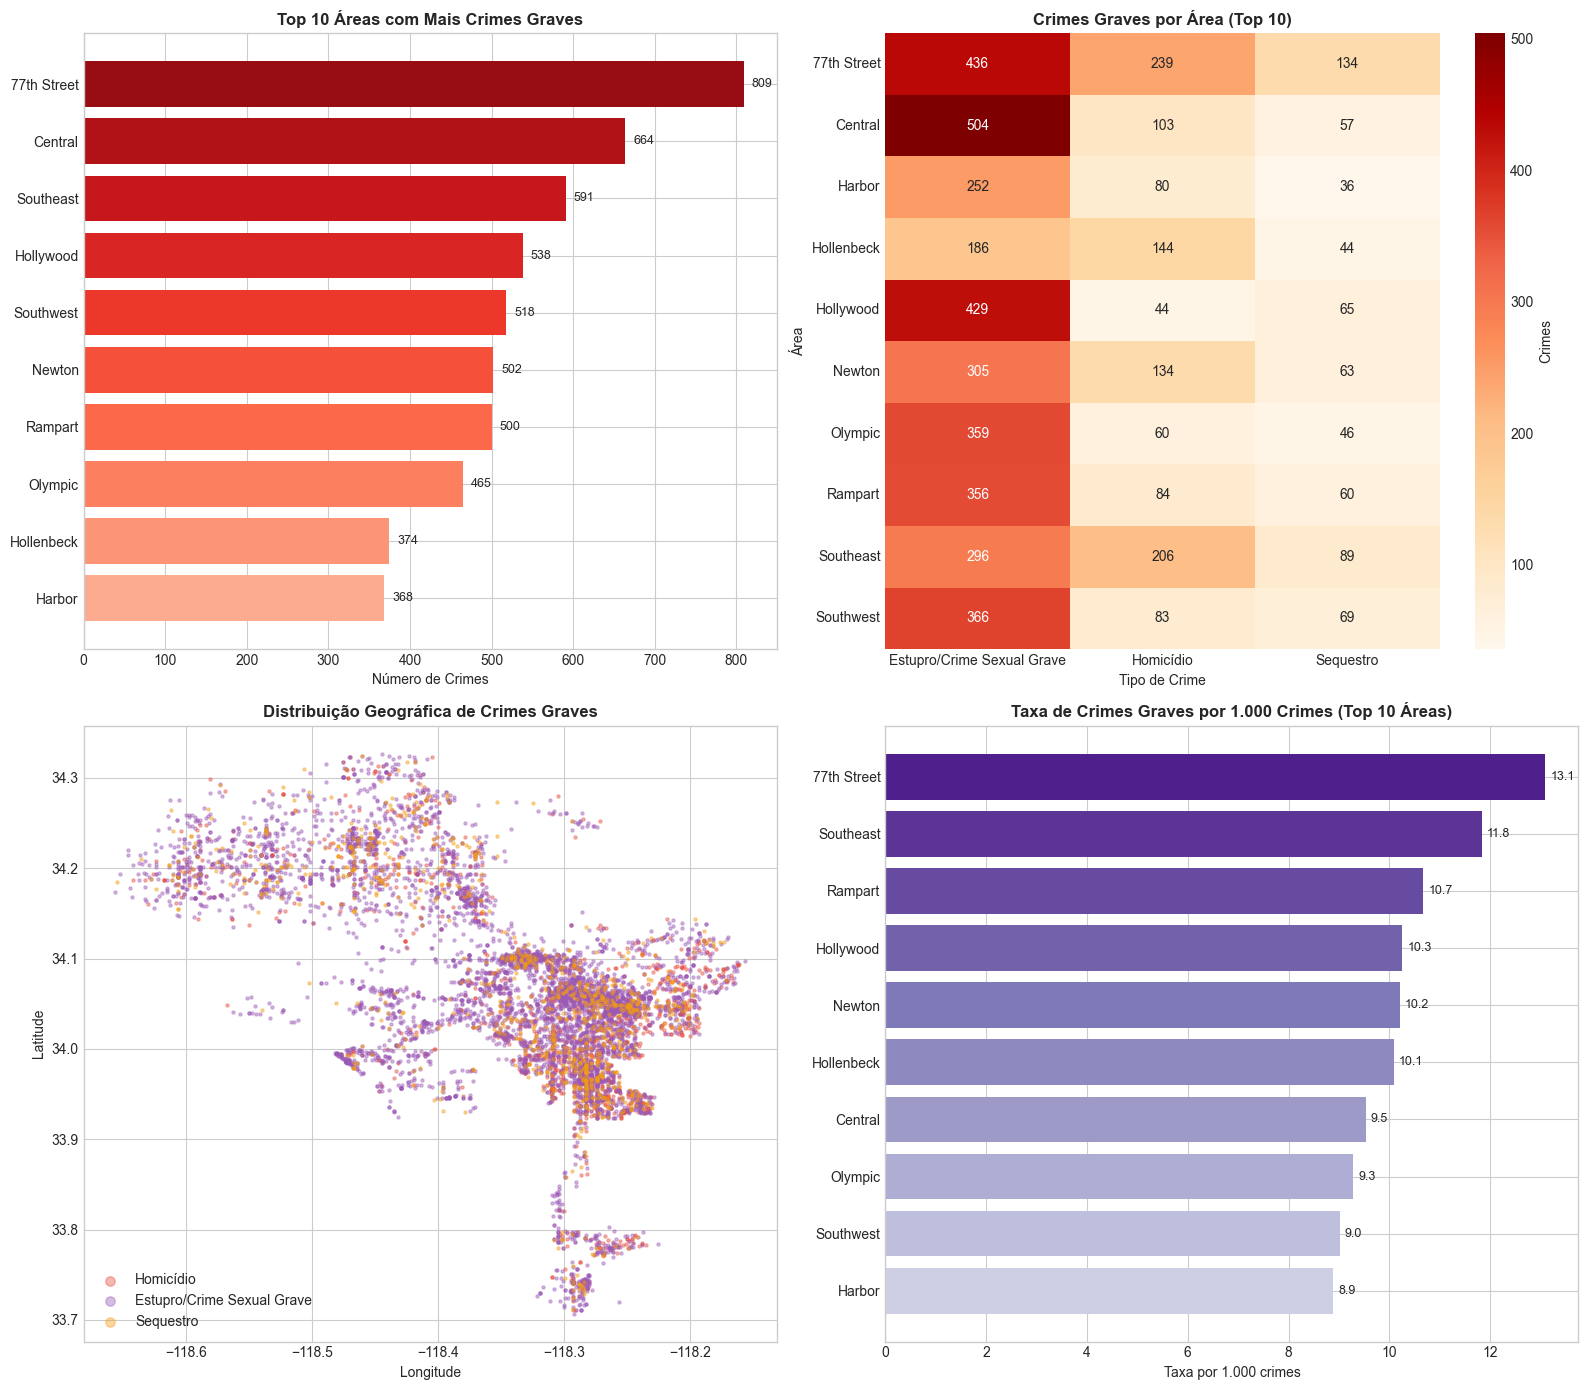


📍 CONCENTRAÇÃO GEOGRÁFICA:
   Top 3 áreas concentram 2,064 crimes (24.1% do total)
      - 77th Street: 809
      - Central: 664
      - Southeast: 591


In [ ]:
# Distribuição Geográfica de Crimes Graves
print("="*70)
print("🗺️ DISTRIBUIÇÃO GEOGRÁFICA DE CRIMES GRAVES")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

area_col = 'AREA NAME' if 'AREA NAME' in df_graves.columns else 'area_name'

# 1. Top 10 áreas por total de crimes graves
ax1 = axes[0, 0]
area_graves = df_graves.groupby(area_col).size().sort_values(ascending=True).tail(10)
colors_area = plt.cm.Reds(np.linspace(0.3, 0.9, len(area_graves)))
bars = ax1.barh(area_graves.index, area_graves.values, color=colors_area)
ax1.set_title('Top 10 Áreas com Mais Crimes Graves', fontsize=12, fontweight='bold')
ax1.set_xlabel('Número de Crimes')
for bar, val in zip(bars, area_graves.values):
    ax1.text(val + 10, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=9)

# 2. Heatmap: Área × Tipo de Crime Grave
ax2 = axes[0, 1]
area_crime = df_graves.groupby([area_col, 'crime_category']).size().unstack(fill_value=0)
top_areas = df_graves[area_col].value_counts().head(10).index
area_crime_top = area_crime.loc[area_crime.index.isin(top_areas)]
sns.heatmap(area_crime_top, annot=True, fmt='d', cmap='OrRd', ax=ax2, cbar_kws={'label': 'Crimes'})
ax2.set_title('Crimes Graves por Área (Top 10)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Tipo de Crime')
ax2.set_ylabel('Área')

# 3. Mapa de calor geográfico (scatter)
ax3 = axes[1, 0]
lat_col = 'LAT' if 'LAT' in df_graves.columns else 'latitude'
lon_col = 'LON' if 'LON' in df_graves.columns else 'longitude'

valid_graves = df_graves[(df_graves[lat_col] != 0) & (df_graves[lon_col] != 0)].copy()

for cat, color in colors_graves.items():
    subset = valid_graves[valid_graves['crime_category'] == cat]
    ax3.scatter(subset[lon_col], subset[lat_col], c=color, alpha=0.4, s=5, label=cat)

ax3.set_title('Distribuição Geográfica de Crimes Graves', fontsize=12, fontweight='bold')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
ax3.legend(markerscale=3)

# 4. Taxa de crimes graves por área (normalizado)
ax4 = axes[1, 1]
total_by_area = df_full.groupby(area_col).size()
graves_by_area = df_graves.groupby(area_col).size()
rate_by_area = (graves_by_area / total_by_area * 1000).sort_values(ascending=True).tail(10)

colors_rate = plt.cm.Purples(np.linspace(0.3, 0.9, len(rate_by_area)))
bars = ax4.barh(rate_by_area.index, rate_by_area.values, color=colors_rate)
ax4.set_title('Taxa de Crimes Graves por 1.000 Crimes (Top 10 Áreas)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Taxa por 1.000 crimes')
for bar, val in zip(bars, rate_by_area.values):
    ax4.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'{val:.1f}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Estatísticas geográficas
print("\n📍 CONCENTRAÇÃO GEOGRÁFICA:")
top3_areas = df_graves[area_col].value_counts().head(3)
total_top3 = top3_areas.sum()
print(f"   Top 3 áreas concentram {total_top3:,} crimes ({100*total_top3/len(df_graves):.1f}% do total)")
for area, count in top3_areas.items():
    print(f"      - {area}: {count:,}")

👥 PERFIL DAS VÍTIMAS DE CRIMES GRAVES


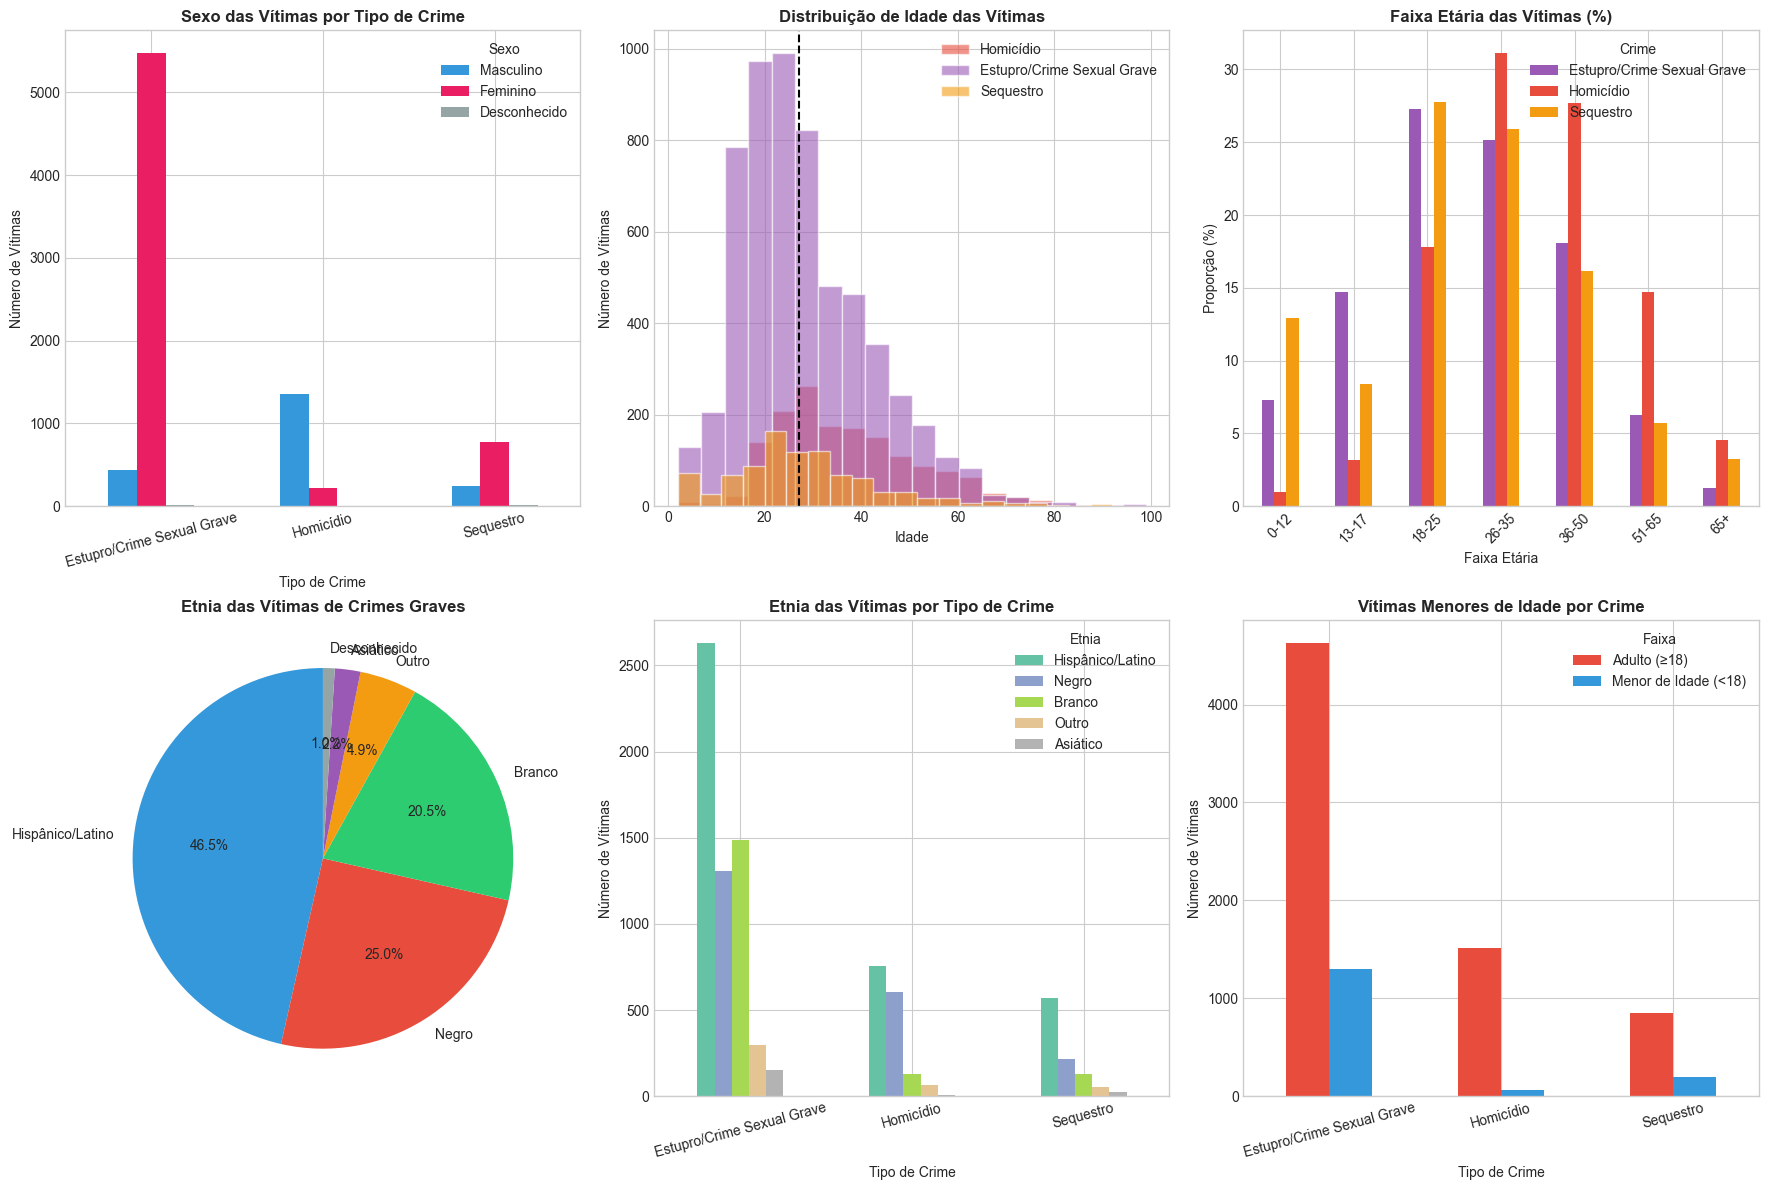


📊 ESTATÍSTICAS DO PERFIL DAS VÍTIMAS:
--------------------------------------------------

🔸 Homicídio:
   Total de vítimas: 1,577
   Sexo: 86.1% Masculino, 13.7% Feminino
   Idade média: 37.4 anos
   Idade mediana: 34 anos
   Menores de idade: 64 (4.1%)
   Etnia mais afetada: Hispânico/Latino (755)

🔸 Estupro/Crime Sexual Grave:
   Total de vítimas: 5,927
   Sexo: 7.4% Masculino, 92.4% Feminino
   Idade média: 28.3 anos
   Idade mediana: 26 anos
   Menores de idade: 1,300 (22.0%)
   Etnia mais afetada: Hispânico/Latino (2,629)

🔸 Sequestro:
   Total de vítimas: 1,044
   Sexo: 23.7% Masculino, 75.0% Feminino
   Idade média: 28.0 anos
   Idade mediana: 26 anos
   Menores de idade: 198 (21.3%)
   Etnia mais afetada: Hispânico/Latino (572)


In [ ]:
# Perfil das Vítimas de Crimes Graves
print("="*70)
print("👥 PERFIL DAS VÍTIMAS DE CRIMES GRAVES")
print("="*70)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Colunas de vítima
sex_col = 'Vict Sex' if 'Vict Sex' in df_graves.columns else 'victim_sex'
age_col = 'Vict Age' if 'Vict Age' in df_graves.columns else 'victim_age'
descent_col = 'Vict Descent' if 'Vict Descent' in df_graves.columns else 'victim_descent'

# Mapeamento de etnia
descent_labels = {
    'H': 'Hispânico/Latino', 'W': 'Branco', 'B': 'Negro', 'A': 'Asiático',
    'O': 'Outro', 'X': 'Desconhecido', '-': 'Desconhecido', 'K': 'Coreano',
    'F': 'Filipino', 'C': 'Chinês', 'J': 'Japonês', 'V': 'Vietnamita',
    'I': 'Indígena Americano', 'P': 'Ilhas do Pacífico', 'U': 'Havaiano',
    'Z': 'Indiano Asiático', 'S': 'Samoano', 'G': 'Guamense', 'L': 'Laosiano'
}

# 1. Sexo das vítimas por tipo de crime
ax1 = axes[0, 0]
sex_by_crime = df_graves.groupby(['crime_category', sex_col]).size().unstack(fill_value=0)
sex_labels_map = {'M': 'Masculino', 'F': 'Feminino', 'X': 'Desconhecido', 'H': 'Desconhecido'}
sex_by_crime.columns = [sex_labels_map.get(c, c) for c in sex_by_crime.columns]
sex_by_crime = sex_by_crime[[c for c in ['Masculino', 'Feminino', 'Desconhecido'] if c in sex_by_crime.columns]]
sex_by_crime.plot(kind='bar', ax=ax1, color=['#3498db', '#e91e63', '#95a5a6'])
ax1.set_title('Sexo das Vítimas por Tipo de Crime', fontsize=12, fontweight='bold')
ax1.set_xlabel('Tipo de Crime')
ax1.set_ylabel('Número de Vítimas')
ax1.tick_params(axis='x', rotation=15)
ax1.legend(title='Sexo')

# 2. Distribuição de idade das vítimas
ax2 = axes[0, 1]
valid_ages = df_graves[(df_graves[age_col] > 0) & (df_graves[age_col] < 100)]
for cat, color in colors_graves.items():
    subset = valid_ages[valid_ages['crime_category'] == cat][age_col]
    ax2.hist(subset, bins=20, alpha=0.6, label=cat, color=color, edgecolor='white')
ax2.set_title('Distribuição de Idade das Vítimas', fontsize=12, fontweight='bold')
ax2.set_xlabel('Idade')
ax2.set_ylabel('Número de Vítimas')
ax2.legend()
ax2.axvline(valid_ages[age_col].median(), color='black', linestyle='--', label=f'Mediana: {valid_ages[age_col].median():.0f}')

# 3. Faixa etária por tipo de crime
ax3 = axes[0, 2]
df_graves['age_group'] = pd.cut(df_graves[age_col], 
                                 bins=[0, 12, 17, 25, 35, 50, 65, 100],
                                 labels=['0-12', '13-17', '18-25', '26-35', '36-50', '51-65', '65+'])
age_crime = df_graves.groupby(['crime_category', 'age_group']).size().unstack(fill_value=0)
age_crime_pct = age_crime.div(age_crime.sum(axis=1), axis=0) * 100
age_crime_pct.T.plot(kind='bar', ax=ax3, color=[colors_graves.get(c, '#333') for c in age_crime_pct.index])
ax3.set_title('Faixa Etária das Vítimas (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Faixa Etária')
ax3.set_ylabel('Proporção (%)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Crime', loc='upper right')

# 4. Etnia das vítimas
ax4 = axes[1, 0]
df_graves['descent_label'] = df_graves[descent_col].map(descent_labels).fillna('Outro')
descent_counts = df_graves['descent_label'].value_counts().head(6)
colors_pie = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#95a5a6']
ax4.pie(descent_counts.values, labels=descent_counts.index, autopct='%1.1f%%', 
        colors=colors_pie, startangle=90)
ax4.set_title('Etnia das Vítimas de Crimes Graves', fontsize=12, fontweight='bold')

# 5. Etnia × Tipo de crime
ax5 = axes[1, 1]
descent_crime = df_graves.groupby(['crime_category', 'descent_label']).size().unstack(fill_value=0)
top_descents = df_graves['descent_label'].value_counts().head(5).index
descent_crime_top = descent_crime[top_descents]
descent_crime_top.plot(kind='bar', ax=ax5, colormap='Set2')
ax5.set_title('Etnia das Vítimas por Tipo de Crime', fontsize=12, fontweight='bold')
ax5.set_xlabel('Tipo de Crime')
ax5.set_ylabel('Número de Vítimas')
ax5.tick_params(axis='x', rotation=15)
ax5.legend(title='Etnia', loc='upper right')

# 6. Menores de idade vítimas
ax6 = axes[1, 2]
df_graves['is_minor'] = df_graves[age_col].apply(lambda x: 'Menor de Idade (<18)' if 0 < x < 18 else 'Adulto (≥18)')
minor_by_crime = df_graves.groupby(['crime_category', 'is_minor']).size().unstack(fill_value=0)
minor_by_crime.plot(kind='bar', ax=ax6, color=['#e74c3c', '#3498db'])
ax6.set_title('Vítimas Menores de Idade por Crime', fontsize=12, fontweight='bold')
ax6.set_xlabel('Tipo de Crime')
ax6.set_ylabel('Número de Vítimas')
ax6.tick_params(axis='x', rotation=15)
ax6.legend(title='Faixa')

plt.tight_layout()
plt.show()

# Estatísticas do perfil
print("\n📊 ESTATÍSTICAS DO PERFIL DAS VÍTIMAS:")
print("-" * 50)

# Por tipo de crime
for cat in ['Homicídio', 'Estupro/Crime Sexual Grave', 'Sequestro']:
    subset = df_graves[df_graves['crime_category'] == cat]
    valid = subset[(subset[age_col] > 0) & (subset[age_col] < 100)]
    
    print(f"\n🔸 {cat}:")
    print(f"   Total de vítimas: {len(subset):,}")
    
    # Sexo
    sex_dist = subset[sex_col].value_counts(normalize=True) * 100
    sex_m = sex_dist.get('M', 0)
    sex_f = sex_dist.get('F', 0)
    print(f"   Sexo: {sex_m:.1f}% Masculino, {sex_f:.1f}% Feminino")
    
    # Idade
    if len(valid) > 0:
        print(f"   Idade média: {valid[age_col].mean():.1f} anos")
        print(f"   Idade mediana: {valid[age_col].median():.0f} anos")
        minors = len(valid[(valid[age_col] > 0) & (valid[age_col] < 18)])
        print(f"   Menores de idade: {minors:,} ({100*minors/len(valid):.1f}%)")
    
    # Etnia mais afetada
    top_descent = subset['descent_label'].value_counts().head(1)
    if len(top_descent) > 0:
        print(f"   Etnia mais afetada: {top_descent.index[0]} ({top_descent.values[0]:,})")

---
# 🗺️ ANÁLISE ESPACIAL (GEOANÁLISE)

Identificação de hotspots de criminalidade, distribuição geográfica e análise por distrito/área.

🗺️ ANÁLISE ESPACIAL - HOTSPOTS DE CRIMINALIDADE
📍 Registros com coordenadas válidas: 1,002,751 (99.8%)


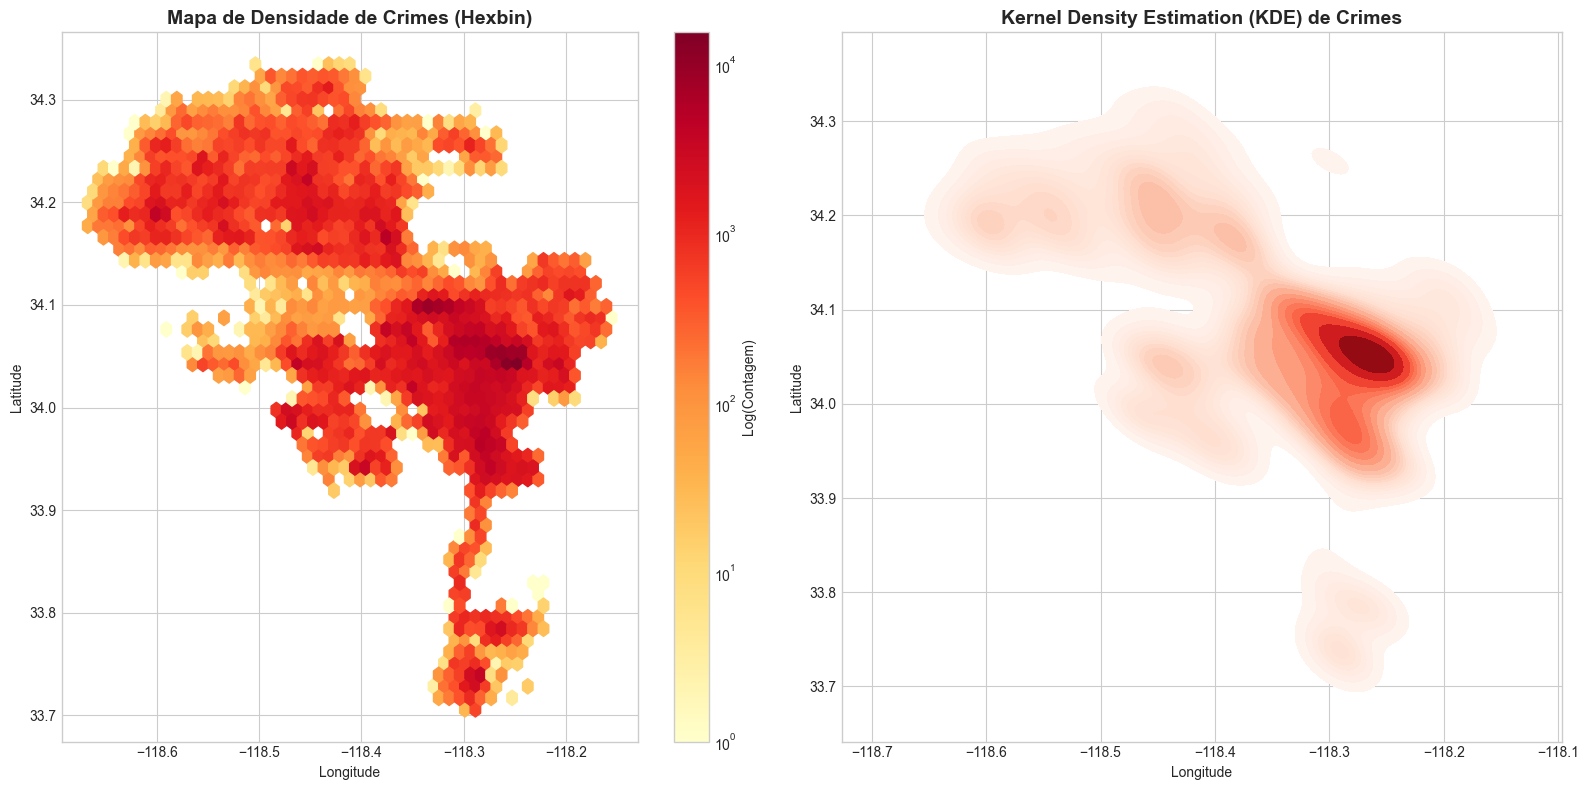


🔥 Identificando Hotspots com DBSCAN...
   Hotspots identificados: 5
   Pontos em hotspots: 49,114 (98.2%)


In [ ]:
# 12.1 Mapa de Calor 2D - Hotspots de Criminalidade
print("="*70)
print("🗺️ ANÁLISE ESPACIAL - HOTSPOTS DE CRIMINALIDADE")
print("="*70)

# Filtrar coordenadas válidas
lat_col = 'LAT' if 'LAT' in df_full.columns else 'latitude'
lon_col = 'LON' if 'LON' in df_full.columns else 'longitude'
df_geo = df_full[(df_full[lat_col] != 0) & (df_full[lon_col] != 0) & 
                  df_full[lat_col].notna() & df_full[lon_col].notna()].copy()

print(f"📍 Registros com coordenadas válidas: {len(df_geo):,} ({100*len(df_geo)/len(df_full):.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mapa de densidade 2D (hexbin)
ax1 = axes[0]
hb = ax1.hexbin(df_geo[lon_col], df_geo[lat_col], gridsize=50, cmap='YlOrRd', 
                mincnt=1, bins='log')
cb = plt.colorbar(hb, ax=ax1)
cb.set_label('Log(Contagem)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Mapa de Densidade de Crimes (Hexbin)', fontsize=14, fontweight='bold')

# KDE 2D
ax2 = axes[1]
# Usar amostra para KDE (computacionalmente intensivo)
sample_size = min(20000, len(df_geo))
df_sample = df_geo.sample(sample_size, random_state=42)
sns.kdeplot(data=df_sample, x=lon_col, y=lat_col, cmap='Reds', 
            fill=True, levels=20, thresh=0.05, ax=ax2)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Kernel Density Estimation (KDE) de Crimes', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Identificar hotspots usando clustering
from sklearn.cluster import DBSCAN

print("\n🔥 Identificando Hotspots com DBSCAN...")
coords = df_geo[[lat_col, lon_col]].sample(min(50000, len(df_geo)), random_state=42).values

# DBSCAN para encontrar clusters de alta densidade
db = DBSCAN(eps=0.01, min_samples=50)
clusters = db.fit_predict(coords)

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"   Hotspots identificados: {n_clusters}")
print(f"   Pontos em hotspots: {(clusters != -1).sum():,} ({100*(clusters != -1).sum()/len(clusters):.1f}%)")

📊 COMPARAÇÃO ESPACIAL POR ANO


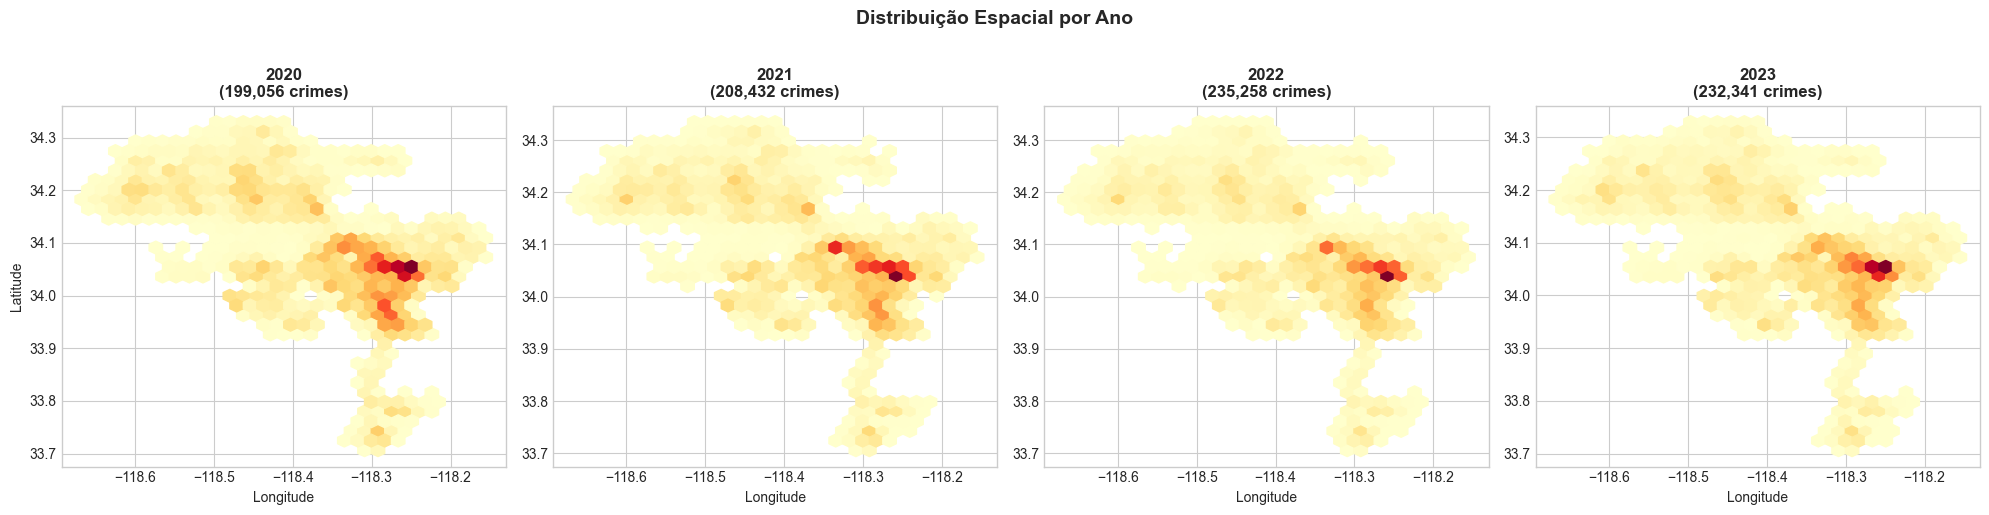


📍 Criminalidade por Área/Distrito:


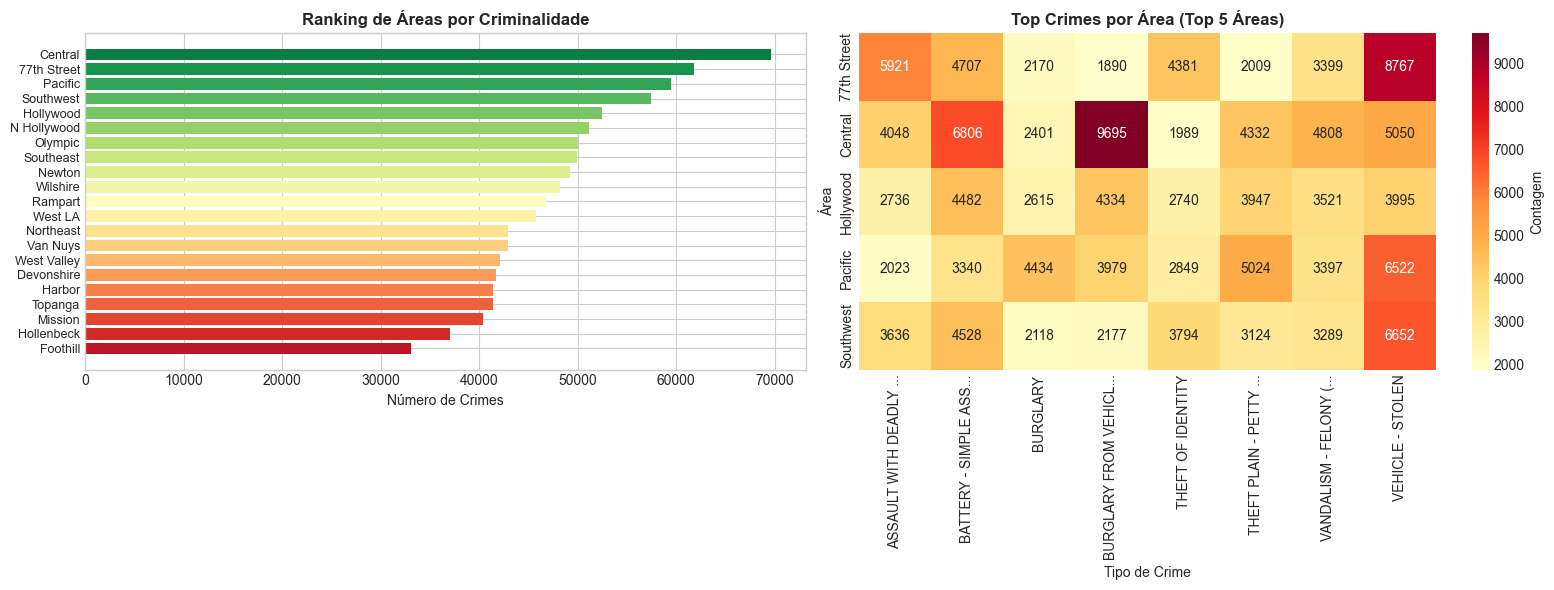

In [ ]:
# 12.2 Comparação Espacial por Ano
print("="*70)
print("📊 COMPARAÇÃO ESPACIAL POR ANO")
print("="*70)

years = sorted(df_geo['year'].dropna().unique().astype(int))
n_years = min(4, len(years))  # Máximo 4 subplots

if n_years > 1:
    fig, axes = plt.subplots(1, n_years, figsize=(5*n_years, 5))
    
    for idx, year in enumerate(years[:n_years]):
        ax = axes[idx] if n_years > 1 else axes
        df_year = df_geo[df_geo['year'] == year]
        
        hb = ax.hexbin(df_year[lon_col], df_year[lat_col], gridsize=30, 
                       cmap='YlOrRd', mincnt=1)
        ax.set_title(f'{year}\n({len(df_year):,} crimes)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Longitude')
        if idx == 0:
            ax.set_ylabel('Latitude')
    
    plt.suptitle('Distribuição Espacial por Ano', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Apenas um ano disponível para comparação")

# Análise por área/distrito
area_col = 'AREA NAME' if 'AREA NAME' in df_full.columns else 'area_name'
if area_col in df_full.columns:
    print("\n📍 Criminalidade por Área/Distrito:")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Ranking por área
    ax1 = axes[0]
    area_counts = df_full[area_col].value_counts()
    colors = sns.color_palette('RdYlGn_r', len(area_counts))
    bars = ax1.barh(range(len(area_counts)), area_counts.values, color=colors)
    ax1.set_yticks(range(len(area_counts)))
    ax1.set_yticklabels(area_counts.index, fontsize=9)
    ax1.invert_yaxis()
    ax1.set_xlabel('Número de Crimes')
    ax1.set_title('Ranking de Áreas por Criminalidade', fontsize=12, fontweight='bold')
    
    # Tipo predominante por área (top 5 áreas)
    ax2 = axes[1]
    top5_areas = area_counts.head(5).index
    area_crime_type = df_full[df_full[area_col].isin(top5_areas)].groupby(
        [area_col, crime_col]).size().reset_index(name='count')
    
    # Pivot para heatmap
    top3_crimes = df_full[crime_col].value_counts().head(8).index
    pivot = area_crime_type[area_crime_type[crime_col].isin(top3_crimes)].pivot_table(
        index=area_col, columns=crime_col, values='count', fill_value=0)
    pivot.columns = [c[:20] + '...' if len(c) > 20 else c for c in pivot.columns]
    
    sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f', ax=ax2, cbar_kws={'label': 'Contagem'})
    ax2.set_title('Top Crimes por Área (Top 5 Áreas)', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Tipo de Crime')
    ax2.set_ylabel('Área')
    
    plt.tight_layout()
    plt.show()

🌐 VISUALIZAÇÃO 3D DE HOTSPOTS


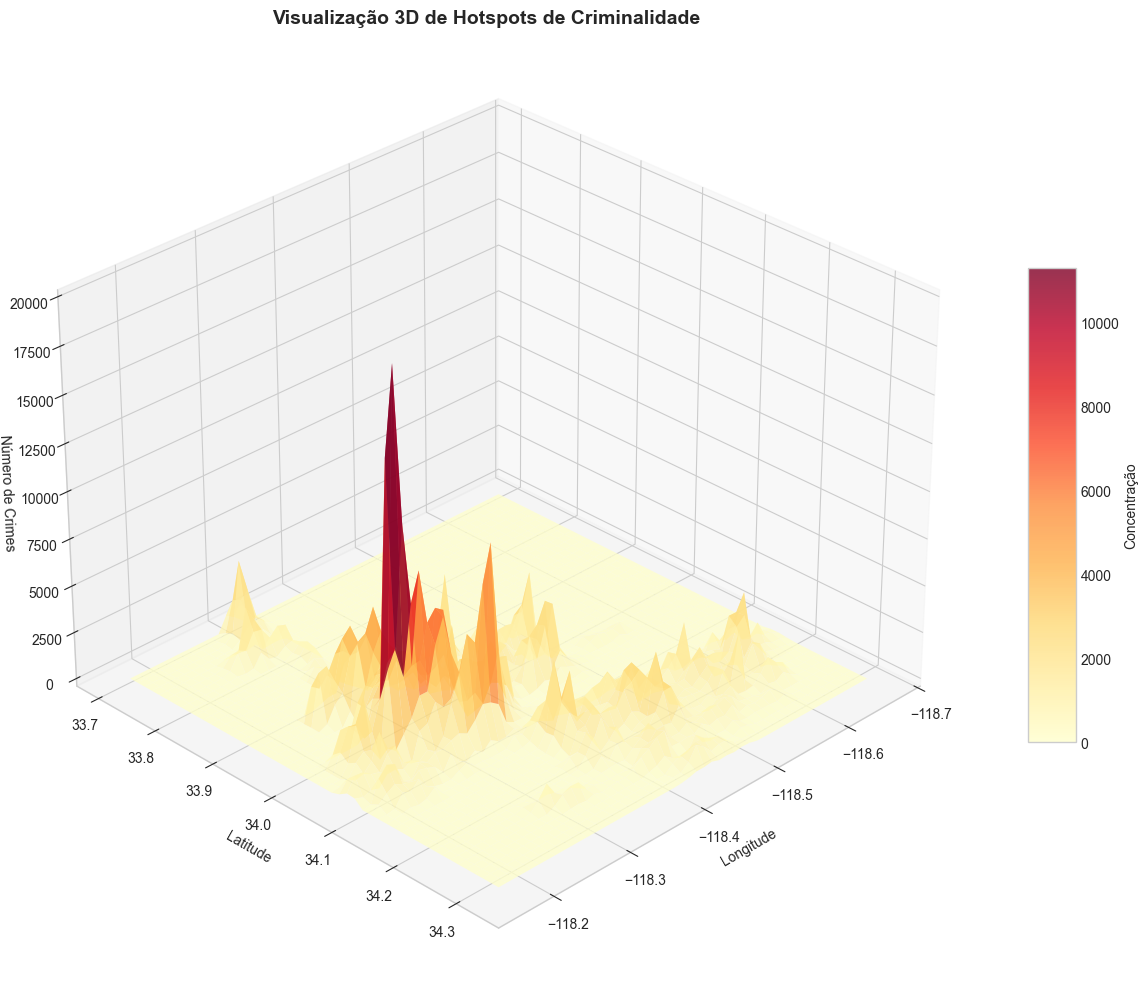


🔝 Pico de Criminalidade:
   Localização: Lon=-118.2599, Lat=34.0393
   Concentração: 19930 crimes


In [ ]:
# 12.3 Visualização 3D de Hotspots
print("="*70)
print("🌐 VISUALIZAÇÃO 3D DE HOTSPOTS")
print("="*70)

from mpl_toolkits.mplot3d import Axes3D

# Criar grid para density
x_bins = np.linspace(df_geo[lon_col].min(), df_geo[lon_col].max(), 50)
y_bins = np.linspace(df_geo[lat_col].min(), df_geo[lat_col].max(), 50)

# Histograma 2D para obter intensidade
H, xedges, yedges = np.histogram2d(df_geo[lon_col], df_geo[lat_col], bins=[x_bins, y_bins])

# Criar meshgrid
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plotar superfície 3D
surf = ax.plot_surface(X, Y, H.T, cmap='YlOrRd', edgecolor='none', alpha=0.8)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Número de Crimes')
ax.set_title('Visualização 3D de Hotspots de Criminalidade', fontsize=14, fontweight='bold')

# Adicionar colorbar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Concentração')

# Ajustar ângulo de visualização
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

# Mostrar os picos
peak_idx = np.unravel_index(H.argmax(), H.shape)
print(f"\n🔝 Pico de Criminalidade:")
print(f"   Localização: Lon={xedges[peak_idx[0]]:.4f}, Lat={yedges[peak_idx[1]]:.4f}")
print(f"   Concentração: {H.max():.0f} crimes")

---
# 📊 ANÁLISES COMPARATIVAS E CONTEXTUAIS

Impacto da pandemia COVID-19, comparação de períodos e mudanças no local do crime.

🦠 ANÁLISE DO IMPACTO DA PANDEMIA COVID-19

📊 Crimes por Período:
   1. Pré-Pandemia (Jan-Mar 2020): 52,048
   2. Lockdown (Abr-Jun 2020): 49,996
   3. Pós-Lockdown 2020 (Jul-Dez): 97,803
   4. Recuperação 2021: 209,876
   5. Pós-Pandemia 2022: 235,259
   6. 2023: 232,345
   6. 2024: 127,567
   6. 2025: 97


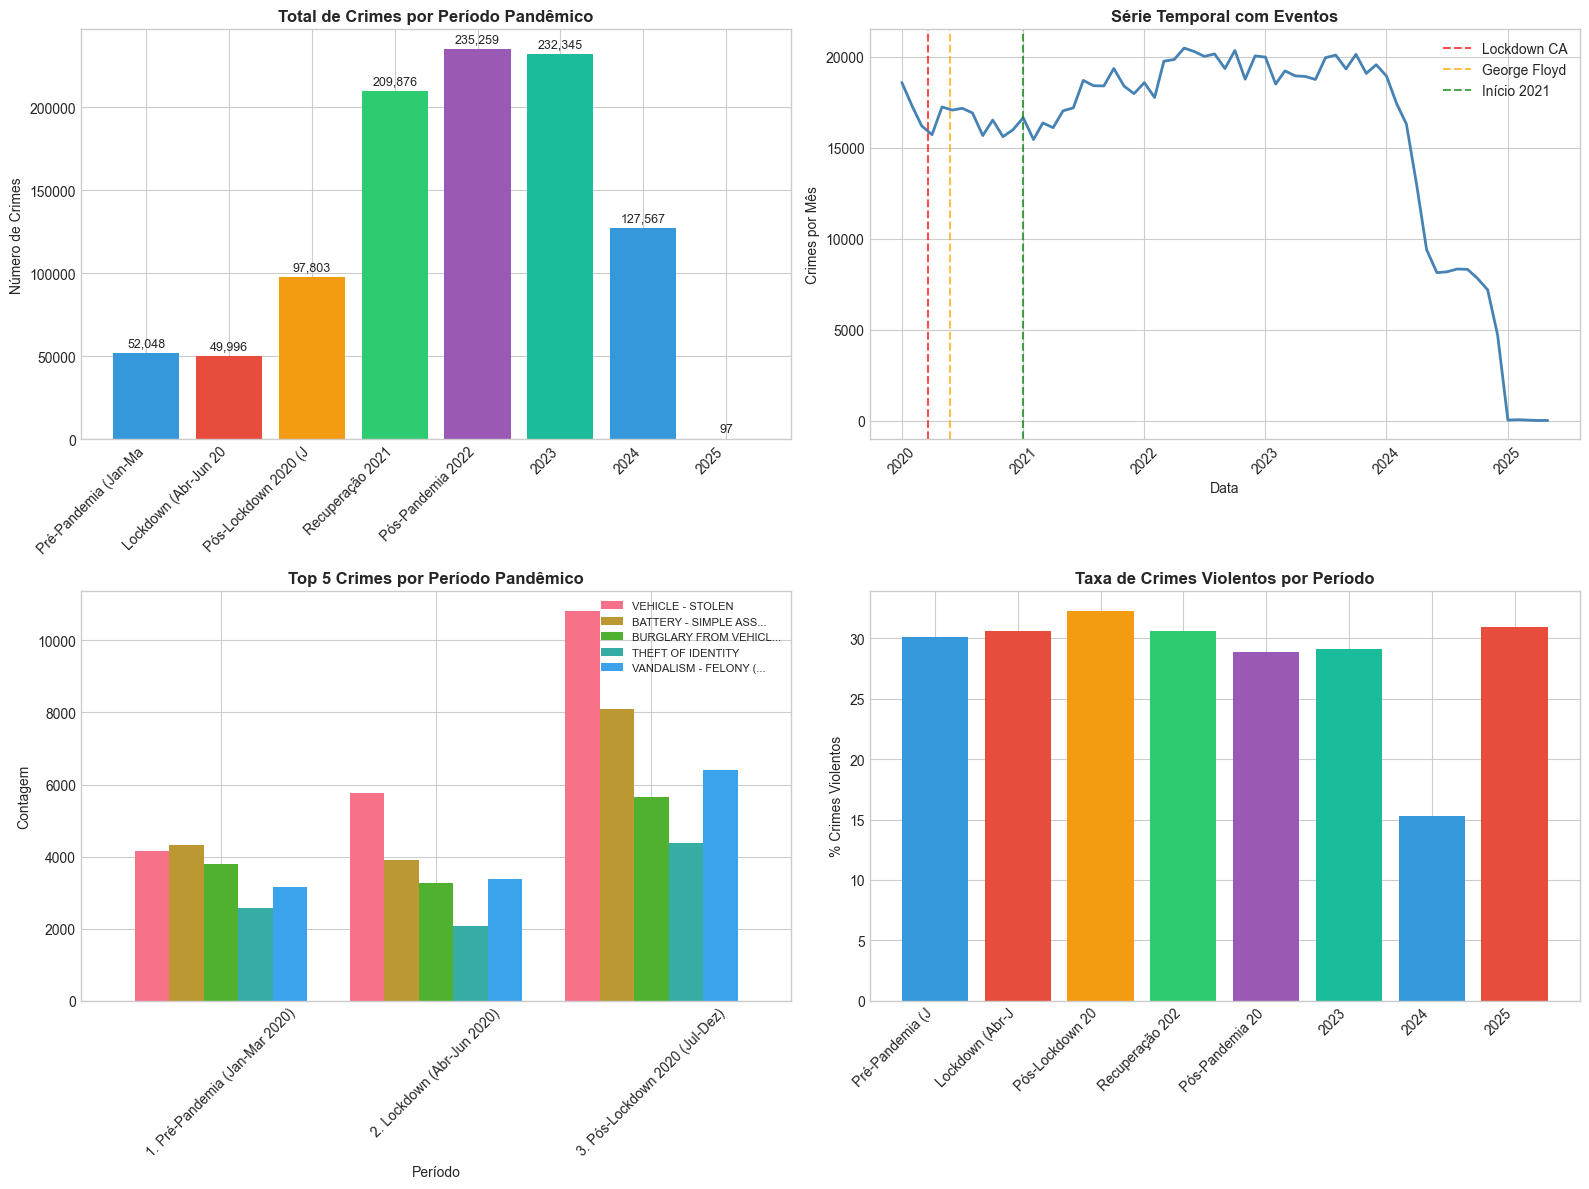

In [ ]:
# 13.1 Impacto da Pandemia COVID-19
print("="*70)
print("🦠 ANÁLISE DO IMPACTO DA PANDEMIA COVID-19")
print("="*70)

# Definir períodos da pandemia
# Pré-pandemia: Jan 2020 - Mar 2020
# Lockdown: Abr 2020 - Jun 2020
# Pós-lockdown inicial: Jul 2020 - Dez 2020
# Recuperação: 2021+

def classify_pandemic_period(row):
    year = row['year']
    month = row['month']
    
    if pd.isna(year) or pd.isna(month):
        return 'Desconhecido'
    
    year, month = int(year), int(month)
    
    if year < 2020:
        return 'Pré-2020'
    elif year == 2020 and month <= 3:
        return '1. Pré-Pandemia (Jan-Mar 2020)'
    elif year == 2020 and month <= 6:
        return '2. Lockdown (Abr-Jun 2020)'
    elif year == 2020 and month <= 12:
        return '3. Pós-Lockdown 2020 (Jul-Dez)'
    elif year == 2021:
        return '4. Recuperação 2021'
    elif year == 2022:
        return '5. Pós-Pandemia 2022'
    else:
        return f'6. {int(year)}'

df_full['pandemic_period'] = df_full.apply(classify_pandemic_period, axis=1)

# Crimes por período
period_counts = df_full['pandemic_period'].value_counts().sort_index()
print("\n📊 Crimes por Período:")
for period, count in period_counts.items():
    print(f"   {period}: {count:,}")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico de barras por período
ax1 = axes[0, 0]
colors = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71', '#9b59b6', '#1abc9c']
bars = ax1.bar(range(len(period_counts)), period_counts.values, color=colors[:len(period_counts)])
ax1.set_xticks(range(len(period_counts)))
ax1.set_xticklabels([p.split('.')[-1].strip()[:20] for p in period_counts.index], rotation=45, ha='right')
ax1.set_ylabel('Número de Crimes')
ax1.set_title('Total de Crimes por Período Pandêmico', fontsize=12, fontweight='bold')
for bar, val in zip(bars, period_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + max(period_counts)*0.01, 
             f'{val:,}', ha='center', va='bottom', fontsize=9)

# Série temporal com marcação de eventos
ax2 = axes[0, 1]
monthly_ts = df_full.groupby(df_full['DATE OCC'].dt.to_period('M')).size()
monthly_ts.index = monthly_ts.index.to_timestamp()
ax2.plot(monthly_ts.index, monthly_ts.values, linewidth=2, color='steelblue')

# Marcar eventos importantes
events = [
    ('2020-03-19', 'Lockdown CA', 'red'),
    ('2020-05-25', 'George Floyd', 'orange'),
    ('2021-01-01', 'Início 2021', 'green'),
]
for date, label, color in events:
    try:
        event_date = pd.to_datetime(date)
        if event_date >= monthly_ts.index.min() and event_date <= monthly_ts.index.max():
            ax2.axvline(event_date, color=color, linestyle='--', alpha=0.7, label=label)
    except:
        pass

ax2.set_title('Série Temporal com Eventos', fontsize=12, fontweight='bold')
ax2.set_xlabel('Data')
ax2.set_ylabel('Crimes por Mês')
ax2.legend(loc='upper right')
ax2.tick_params(axis='x', rotation=45)

# Variação por tipo de crime entre períodos
ax3 = axes[1, 0]
main_periods = ['1. Pré-Pandemia (Jan-Mar 2020)', '2. Lockdown (Abr-Jun 2020)', 
                '3. Pós-Lockdown 2020 (Jul-Dez)']
existing_periods = [p for p in main_periods if p in df_full['pandemic_period'].values]

if len(existing_periods) >= 2:
    top5_crimes = df_full[crime_col].value_counts().head(5).index
    period_crime = df_full[df_full['pandemic_period'].isin(existing_periods)].groupby(
        ['pandemic_period', crime_col]).size().unstack(fill_value=0)
    period_crime = period_crime[top5_crimes]
    period_crime.columns = [c[:20] + '...' if len(c) > 20 else c for c in period_crime.columns]
    period_crime.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Top 5 Crimes por Período Pandêmico', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Período')
    ax3.set_ylabel('Contagem')
    ax3.legend(loc='upper right', fontsize=8)
    ax3.tick_params(axis='x', rotation=45)

# Taxa de crimes violentos por período
ax4 = axes[1, 1]
violent_by_period = df_full.groupby('pandemic_period')['is_violent'].agg(['sum', 'count'])
violent_by_period['rate'] = violent_by_period['sum'] / violent_by_period['count'] * 100
violent_by_period = violent_by_period.sort_index()
ax4.bar(range(len(violent_by_period)), violent_by_period['rate'], color=colors[:len(violent_by_period)])
ax4.set_xticks(range(len(violent_by_period)))
ax4.set_xticklabels([p.split('.')[-1].strip()[:15] for p in violent_by_period.index], rotation=45, ha='right')
ax4.set_ylabel('% Crimes Violentos')
ax4.set_title('Taxa de Crimes Violentos por Período', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

🏠 ANÁLISE DE LOCAL DO CRIME (PREMISE)


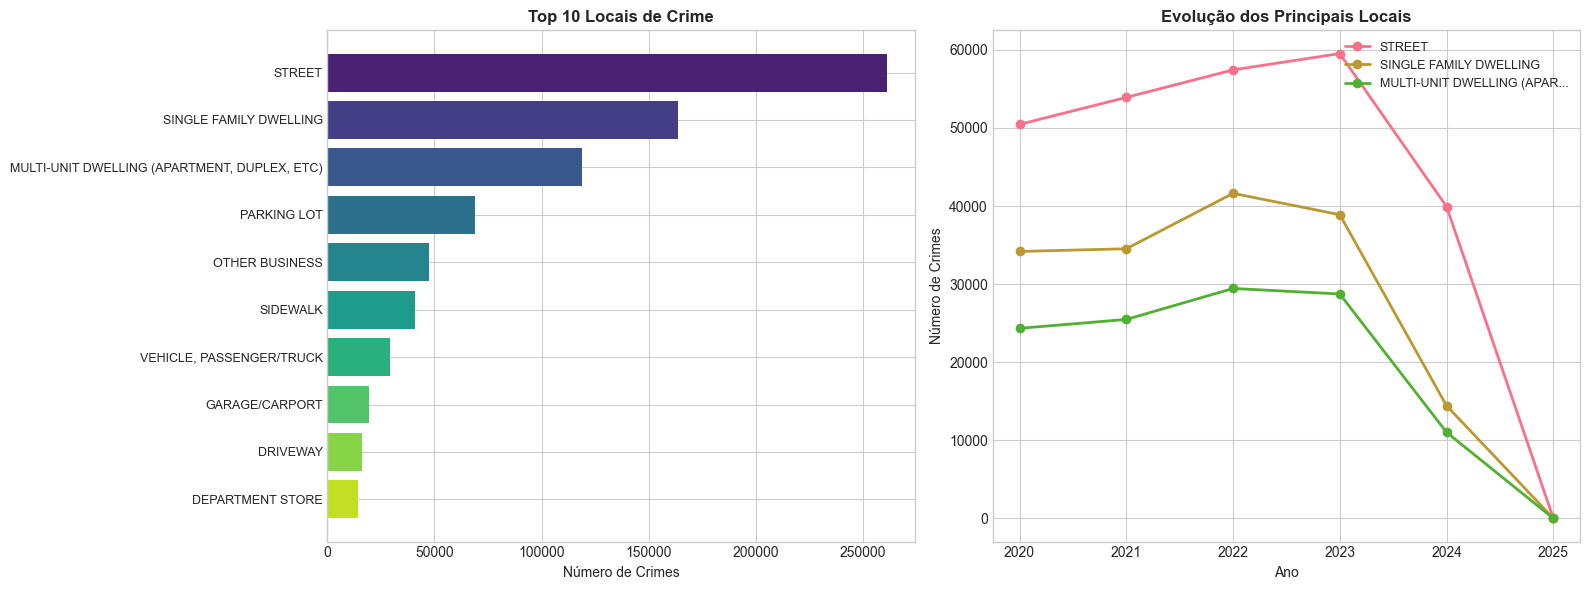


🏢 Categorias de Local:
   Via Pública: 387,325 (38.5%)
   Residência: 299,463 (29.8%)
   Outros: 130,767 (13.0%)
   Estabelecimento Comercial: 120,793 (12.0%)
   Veículo: 56,375 (5.6%)
   Instituição de Ensino: 9,680 (1.0%)
   Desconhecido: 588 (0.1%)


In [ ]:
# 13.2 Mudanças no Local do Crime
print("="*70)
print("🏠 ANÁLISE DE LOCAL DO CRIME (PREMISE)")
print("="*70)

premise_col = 'Premis Desc' if 'Premis Desc' in df_full.columns else 'premise_description'

if premise_col in df_full.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top 10 locais
    ax1 = axes[0]
    top_premises = df_full[premise_col].value_counts().head(10)
    ax1.barh(range(len(top_premises)), top_premises.values, color=sns.color_palette('viridis', 10))
    ax1.set_yticks(range(len(top_premises)))
    ax1.set_yticklabels(top_premises.index, fontsize=9)
    ax1.invert_yaxis()
    ax1.set_xlabel('Número de Crimes')
    ax1.set_title('Top 10 Locais de Crime', fontsize=12, fontweight='bold')
    
    # Evolução dos principais locais ao longo do tempo
    ax2 = axes[1]
    top3_premises = top_premises.head(3).index
    for premise in top3_premises:
        premise_evolution = df_full[df_full[premise_col] == premise].groupby('year').size()
        label = premise[:25] + '...' if len(premise) > 25 else premise
        ax2.plot(premise_evolution.index, premise_evolution.values, marker='o', 
                 label=label, linewidth=2)
    ax2.set_title('Evolução dos Principais Locais', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Ano')
    ax2.set_ylabel('Número de Crimes')
    ax2.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Análise de categorias de local
    print("\n🏢 Categorias de Local:")
    
    # Categorizar locais
    def categorize_premise(premise):
        if pd.isna(premise):
            return 'Desconhecido'
        premise = str(premise).upper()
        if any(x in premise for x in ['STREET', 'SIDEWALK', 'PARKING', 'ALLEY']):
            return 'Via Pública'
        elif any(x in premise for x in ['RESIDENCE', 'APARTMENT', 'HOUSE', 'DWELLING']):
            return 'Residência'
        elif any(x in premise for x in ['STORE', 'SHOP', 'RESTAURANT', 'MARKET', 'BUSINESS']):
            return 'Estabelecimento Comercial'
        elif any(x in premise for x in ['VEHICLE', 'CAR', 'TRUCK', 'BUS']):
            return 'Veículo'
        elif any(x in premise for x in ['SCHOOL', 'COLLEGE', 'UNIVERSITY']):
            return 'Instituição de Ensino'
        else:
            return 'Outros'
    
    df_full['premise_category'] = df_full[premise_col].apply(categorize_premise)
    
    category_counts = df_full['premise_category'].value_counts()
    for cat, count in category_counts.items():
        print(f"   {cat}: {count:,} ({100*count/len(df_full):.1f}%)")
else:
    print("⚠️ Coluna de local (premise) não encontrada")

---
# 🔬 ANÁLISES MULTIVARIADAS

Correlações entre variáveis, reincidência espacial e análises cruzadas.

🔬 ANÁLISES MULTIVARIADAS


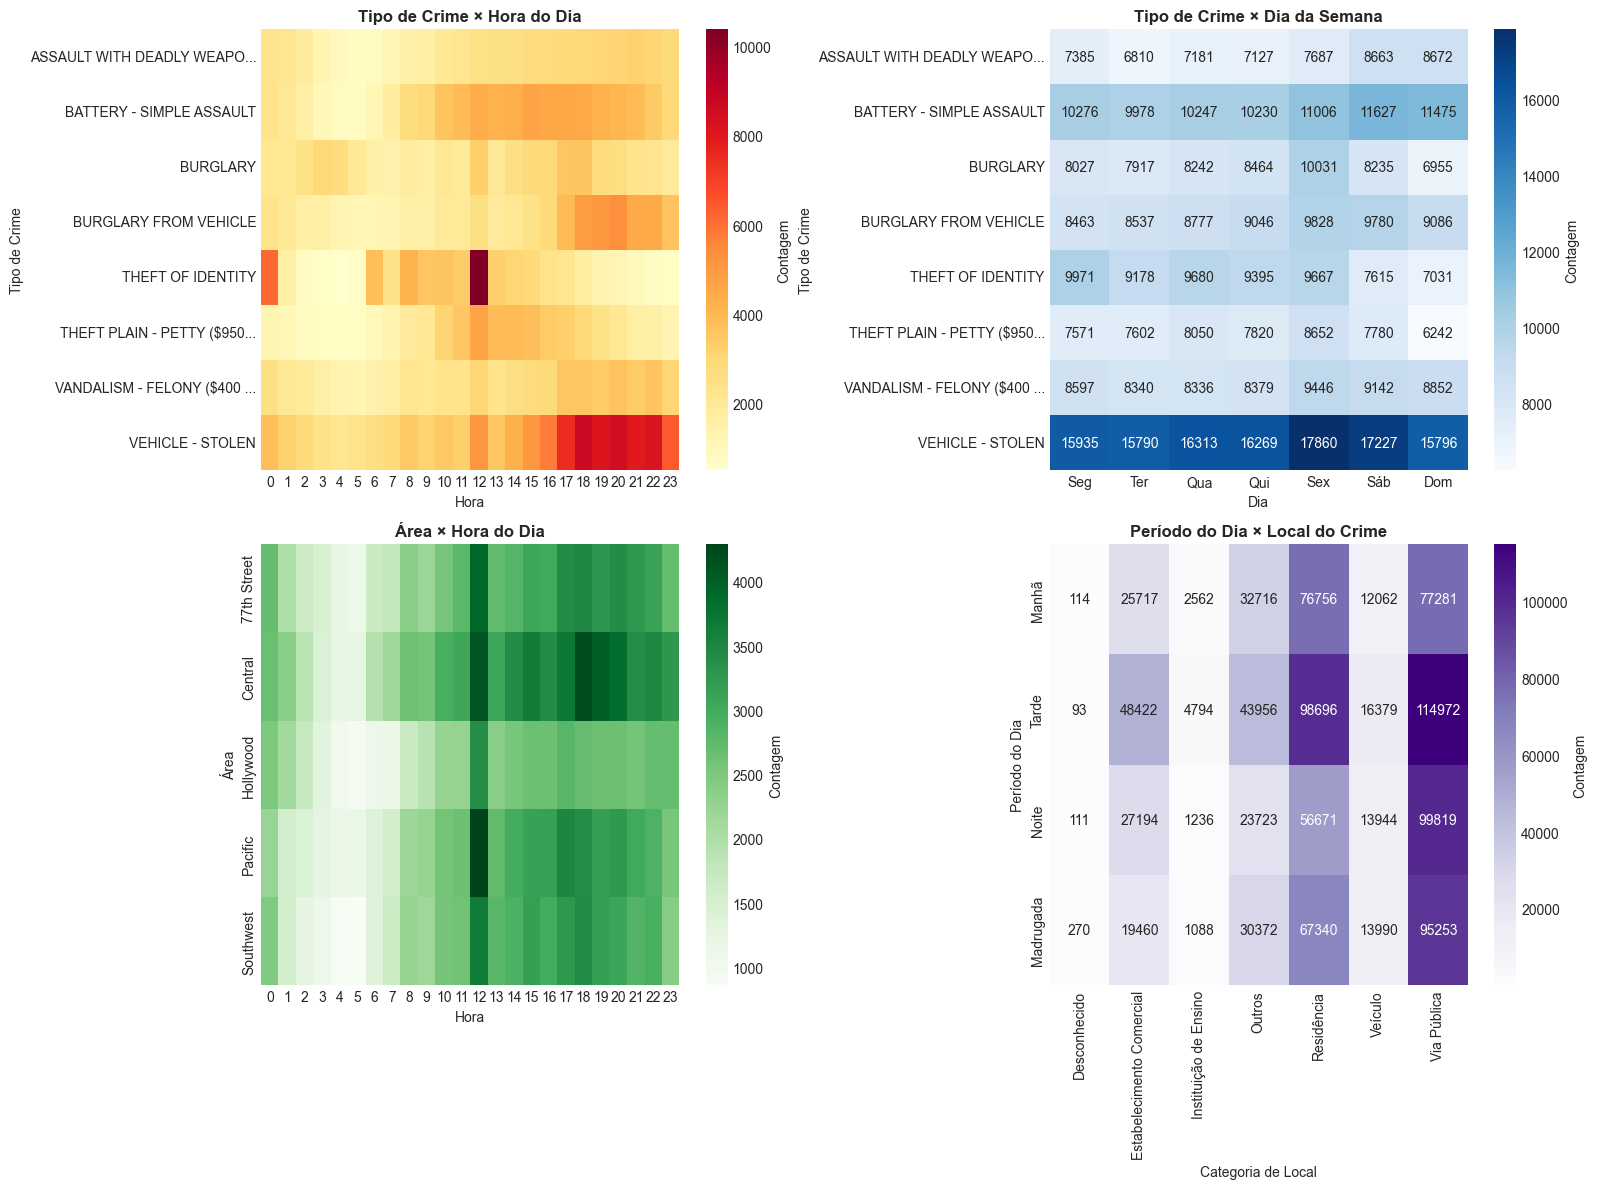

In [ ]:
# 14.1 Análise de Correlações Multivariadas
print("="*70)
print("🔬 ANÁLISES MULTIVARIADAS")
print("="*70)

# Criar tabela cruzada: Tipo de Crime x Período do Dia x Dia da Semana
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap: Tipo de Crime x Hora
ax1 = axes[0, 0]
top8_crimes = df_full[crime_col].value_counts().head(8).index
crime_hour = df_full[df_full[crime_col].isin(top8_crimes)].groupby(
    [crime_col, 'hour']).size().unstack(fill_value=0)
crime_hour.index = [c[:25] + '...' if len(c) > 25 else c for c in crime_hour.index]
sns.heatmap(crime_hour, cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Contagem'})
ax1.set_title('Tipo de Crime × Hora do Dia', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Tipo de Crime')

# Heatmap: Tipo de Crime x Dia da Semana
ax2 = axes[0, 1]
crime_dow = df_full[df_full[crime_col].isin(top8_crimes)].groupby(
    [crime_col, 'day_of_week']).size().unstack(fill_value=0)
crime_dow.columns = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
crime_dow.index = [c[:25] + '...' if len(c) > 25 else c for c in crime_dow.index]
sns.heatmap(crime_dow, cmap='Blues', ax=ax2, cbar_kws={'label': 'Contagem'}, annot=True, fmt='d')
ax2.set_title('Tipo de Crime × Dia da Semana', fontsize=12, fontweight='bold')
ax2.set_xlabel('Dia')
ax2.set_ylabel('Tipo de Crime')

# Heatmap: Área x Hora
ax3 = axes[1, 0]
if area_col in df_full.columns:
    top5_areas = df_full[area_col].value_counts().head(5).index
    area_hour = df_full[df_full[area_col].isin(top5_areas)].groupby(
        [area_col, 'hour']).size().unstack(fill_value=0)
    sns.heatmap(area_hour, cmap='Greens', ax=ax3, cbar_kws={'label': 'Contagem'})
    ax3.set_title('Área × Hora do Dia', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Hora')
    ax3.set_ylabel('Área')

# Heatmap: Período do Dia x Categoria de Local
ax4 = axes[1, 1]
if 'premise_category' in df_full.columns and 'period_of_day' in df_full.columns:
    period_premise = df_full.groupby(['period_of_day', 'premise_category']).size().unstack(fill_value=0)
    period_order = ['Manhã', 'Tarde', 'Noite', 'Madrugada']
    period_premise = period_premise.reindex(period_order)
    sns.heatmap(period_premise, cmap='Purples', ax=ax4, annot=True, fmt='d', 
                cbar_kws={'label': 'Contagem'})
    ax4.set_title('Período do Dia × Local do Crime', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Categoria de Local')
    ax4.set_ylabel('Período do Dia')

plt.tight_layout()
plt.show()

🔄 ANÁLISE DE REINCIDÊNCIA ESPACIAL

📍 Estatísticas de Localização:
   Localizações únicas: 77,868
   Média de crimes por local: 12.88
   Máximo de crimes em um local: 2,397

🔁 Distribuição de Reincidência:
   Baixa (2-5): 27,245 locais (35.0%)
   Único: 17,502 locais (22.5%)
   Alta (11-50): 16,677 locais (21.4%)
   Média (6-10): 12,670 locais (16.3%)
   Muito Alta (50+): 3,774 locais (4.8%)


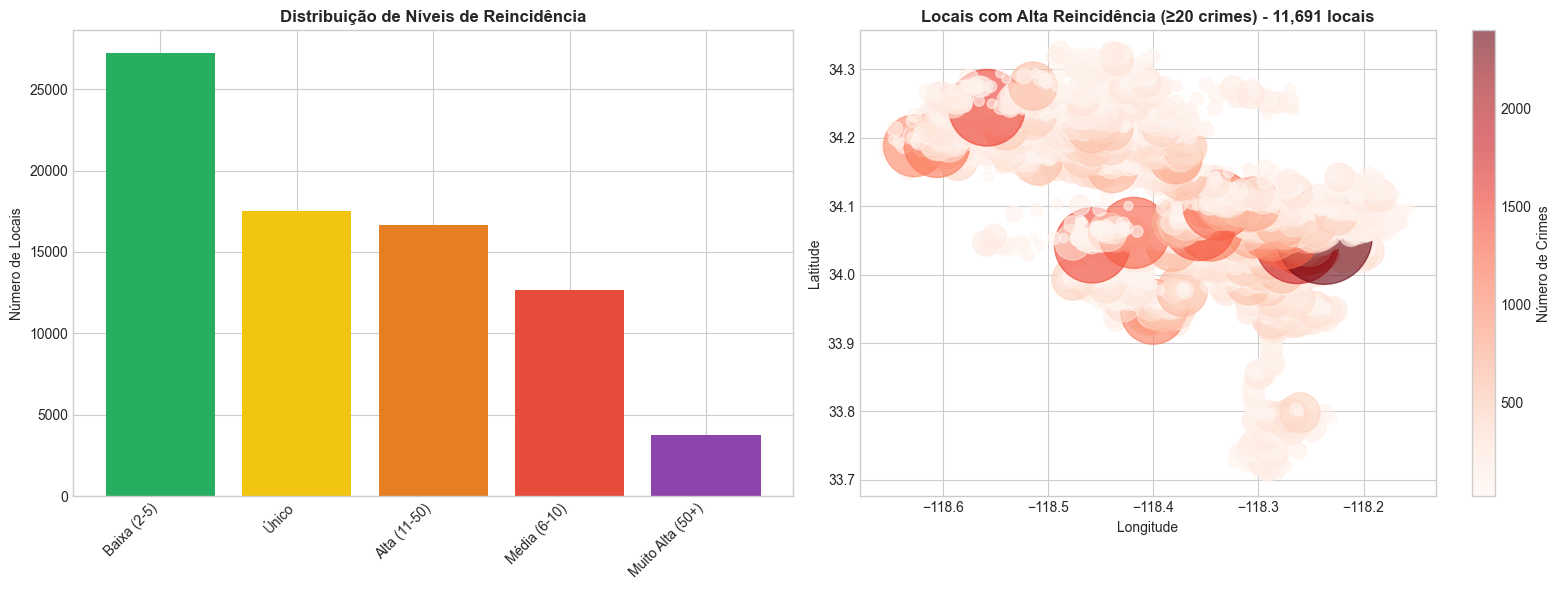


📊 Concentração vs Dispersão:
   Crimes em hotspots (≥10 por local): 819,937 (81.8%)
   Crimes em locais únicos: 17,502


In [ ]:
# 14.2 Análise de Reincidência Espacial
print("="*70)
print("🔄 ANÁLISE DE REINCIDÊNCIA ESPACIAL")
print("="*70)

# Identificar locais com crimes repetidos (usando lat/lon arredondado)
df_geo['lat_round'] = df_geo[lat_col].round(4)
df_geo['lon_round'] = df_geo[lon_col].round(4)

# Contar crimes por localização única
location_counts = df_geo.groupby(['lat_round', 'lon_round']).size().reset_index(name='crime_count')

print(f"\n📍 Estatísticas de Localização:")
print(f"   Localizações únicas: {len(location_counts):,}")
print(f"   Média de crimes por local: {location_counts['crime_count'].mean():.2f}")
print(f"   Máximo de crimes em um local: {location_counts['crime_count'].max():,}")

# Classificar por reincidência
location_counts['reincidence_level'] = pd.cut(
    location_counts['crime_count'],
    bins=[0, 1, 5, 10, 50, float('inf')],
    labels=['Único', 'Baixa (2-5)', 'Média (6-10)', 'Alta (11-50)', 'Muito Alta (50+)']
)

reincidence_dist = location_counts['reincidence_level'].value_counts()
print("\n🔁 Distribuição de Reincidência:")
for level, count in reincidence_dist.items():
    pct = 100 * count / len(location_counts)
    print(f"   {level}: {count:,} locais ({pct:.1f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Distribuição de reincidência
ax1 = axes[0]
colors_reinc = ['#27ae60', '#f1c40f', '#e67e22', '#e74c3c', '#8e44ad']
ax1.bar(range(len(reincidence_dist)), reincidence_dist.values, color=colors_reinc)
ax1.set_xticks(range(len(reincidence_dist)))
ax1.set_xticklabels(reincidence_dist.index, rotation=45, ha='right')
ax1.set_ylabel('Número de Locais')
ax1.set_title('Distribuição de Níveis de Reincidência', fontsize=12, fontweight='bold')

# Mapa de locais com alta reincidência
ax2 = axes[1]
high_reincidence = location_counts[location_counts['crime_count'] >= 20]
scatter = ax2.scatter(high_reincidence['lon_round'], high_reincidence['lat_round'],
                      c=high_reincidence['crime_count'], cmap='Reds', 
                      s=high_reincidence['crime_count']*2, alpha=0.6)
plt.colorbar(scatter, ax=ax2, label='Número de Crimes')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title(f'Locais com Alta Reincidência (≥20 crimes) - {len(high_reincidence):,} locais', 
              fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Análise de concentração vs dispersão
crimes_in_hotspots = location_counts[location_counts['crime_count'] >= 10]['crime_count'].sum()
total_crimes = location_counts['crime_count'].sum()
print(f"\n📊 Concentração vs Dispersão:")
print(f"   Crimes em hotspots (≥10 por local): {crimes_in_hotspots:,} ({100*crimes_in_hotspots/total_crimes:.1f}%)")
print(f"   Crimes em locais únicos: {(location_counts['crime_count'] == 1).sum():,}")

---
# 📅 ANÁLISES DE TENDÊNCIA E SAZONALIDADE

Padrões sazonais, tendências de longo prazo e análise por estação do ano.

📅 ANÁLISE DE SAZONALIDADE


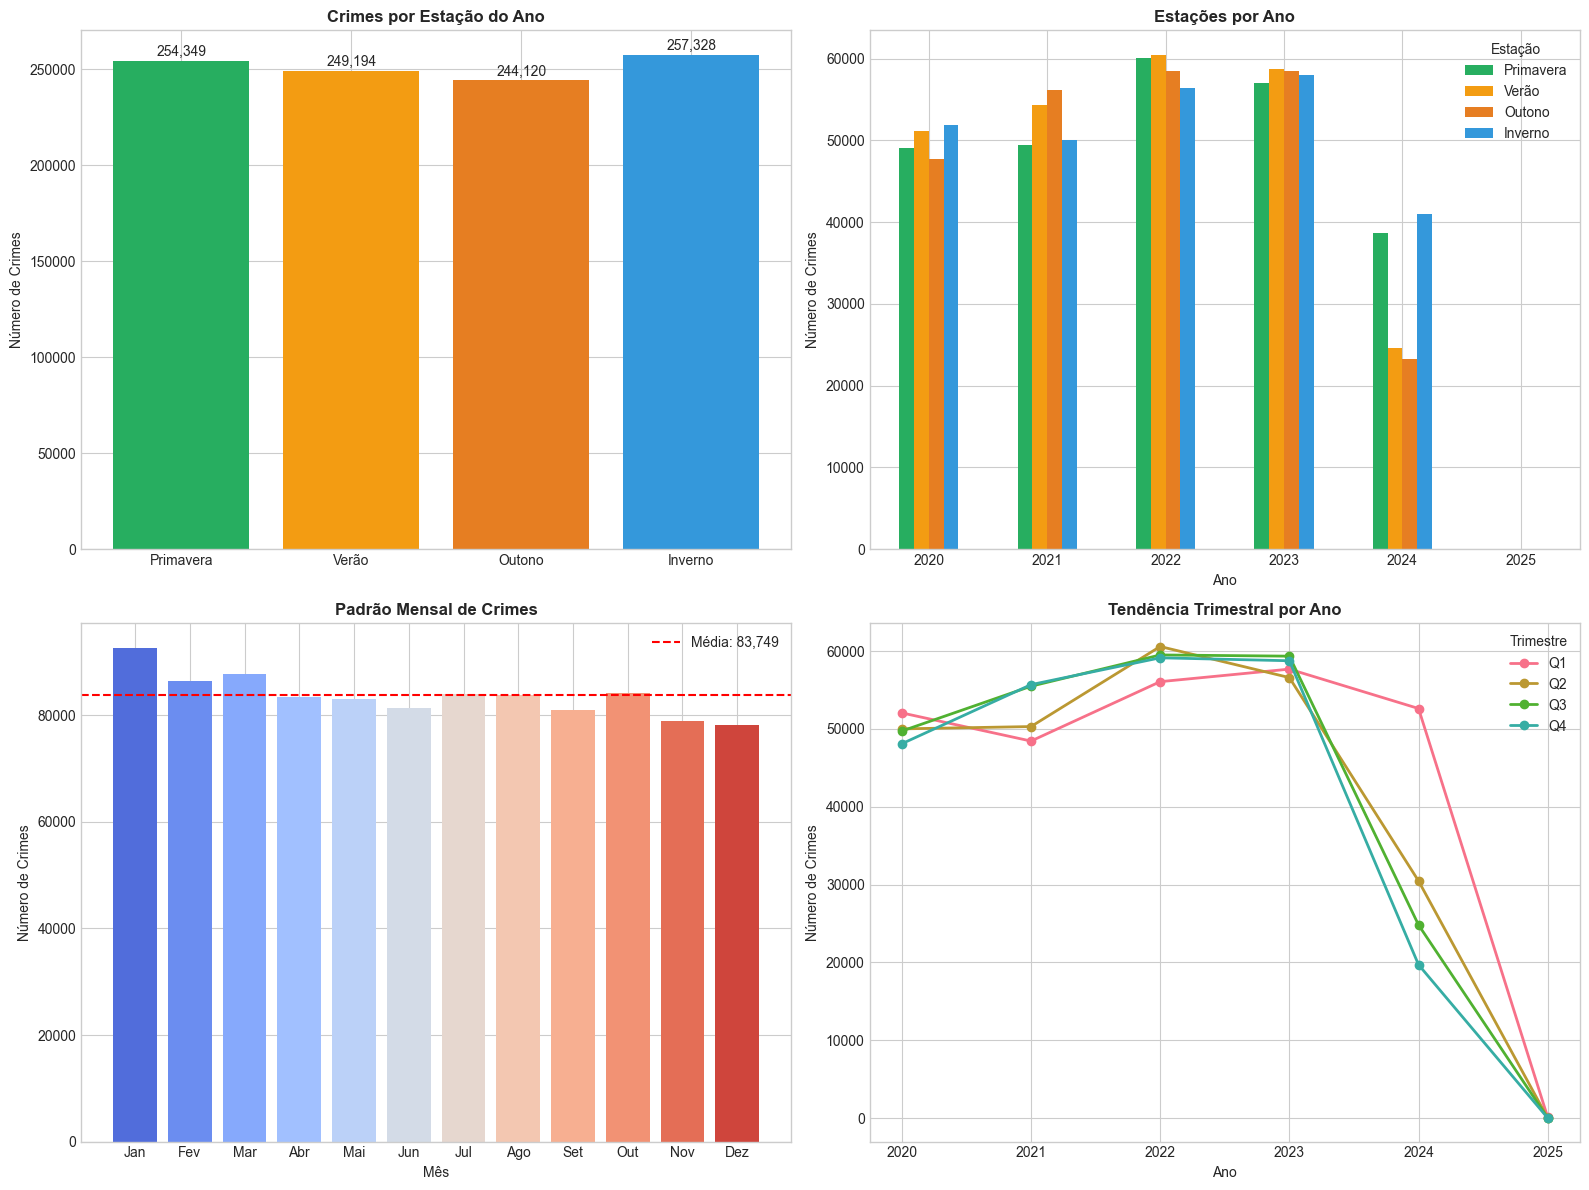


🌡️ Análise Sazonal:
   Estação com mais crimes: Inverno (257,328)
   Estação com menos crimes: Outono (244,120)
   Variação sazonal: 5.4%


In [ ]:
# 15.1 Análise de Sazonalidade
print("="*70)
print("📅 ANÁLISE DE SAZONALIDADE")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Crimes por estação do ano
ax1 = axes[0, 0]
season_counts = df_full['season'].value_counts()
season_order = ['Primavera', 'Verão', 'Outono', 'Inverno']
season_counts = season_counts.reindex(season_order)
colors_season = ['#27ae60', '#f39c12', '#e67e22', '#3498db']
bars = ax1.bar(season_counts.index, season_counts.values, color=colors_season)
ax1.set_title('Crimes por Estação do Ano', fontsize=12, fontweight='bold')
ax1.set_ylabel('Número de Crimes')
for bar, val in zip(bars, season_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + max(season_counts)*0.01, 
             f'{val:,}', ha='center', fontsize=10)

# Comparar estações por ano
ax2 = axes[0, 1]
season_year = df_full.groupby(['year', 'season']).size().unstack(fill_value=0)
season_year = season_year[season_order]
season_year.plot(kind='bar', ax=ax2, color=colors_season)
ax2.set_title('Estações por Ano', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Número de Crimes')
ax2.legend(title='Estação', loc='upper right')
ax2.tick_params(axis='x', rotation=0)

# Padrão mensal médio
ax3 = axes[1, 0]
monthly_avg = df_full.groupby('month').size()
ax3.bar(monthly_avg.index, monthly_avg.values, color=sns.color_palette('coolwarm', 12))
ax3.set_title('Padrão Mensal de Crimes', fontsize=12, fontweight='bold')
ax3.set_xlabel('Mês')
ax3.set_ylabel('Número de Crimes')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 
                     'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
# Destacar mês com mais crimes
max_month = monthly_avg.idxmax()
ax3.axhline(monthly_avg.mean(), color='red', linestyle='--', label=f'Média: {monthly_avg.mean():,.0f}')
ax3.legend()

# Crimes por trimestre ao longo do tempo
ax4 = axes[1, 1]
quarterly = df_full.groupby([df_full['year'], df_full['quarter']]).size().unstack(fill_value=0)
quarterly.columns = ['Q1', 'Q2', 'Q3', 'Q4']
quarterly.plot(kind='line', marker='o', ax=ax4, linewidth=2)
ax4.set_title('Tendência Trimestral por Ano', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Número de Crimes')
ax4.legend(title='Trimestre', loc='upper right')

plt.tight_layout()
plt.show()

# Estatísticas de sazonalidade
print("\n🌡️ Análise Sazonal:")
max_season = season_counts.idxmax()
min_season = season_counts.idxmin()
print(f"   Estação com mais crimes: {max_season} ({season_counts[max_season]:,})")
print(f"   Estação com menos crimes: {min_season} ({season_counts[min_season]:,})")
print(f"   Variação sazonal: {((season_counts.max()/season_counts.min())-1)*100:.1f}%")

📈 TENDÊNCIAS DE LONGO PRAZO
📊 Tendência Linear:
   Variação média por ano: -35,674 crimes
   Direção: Diminuição


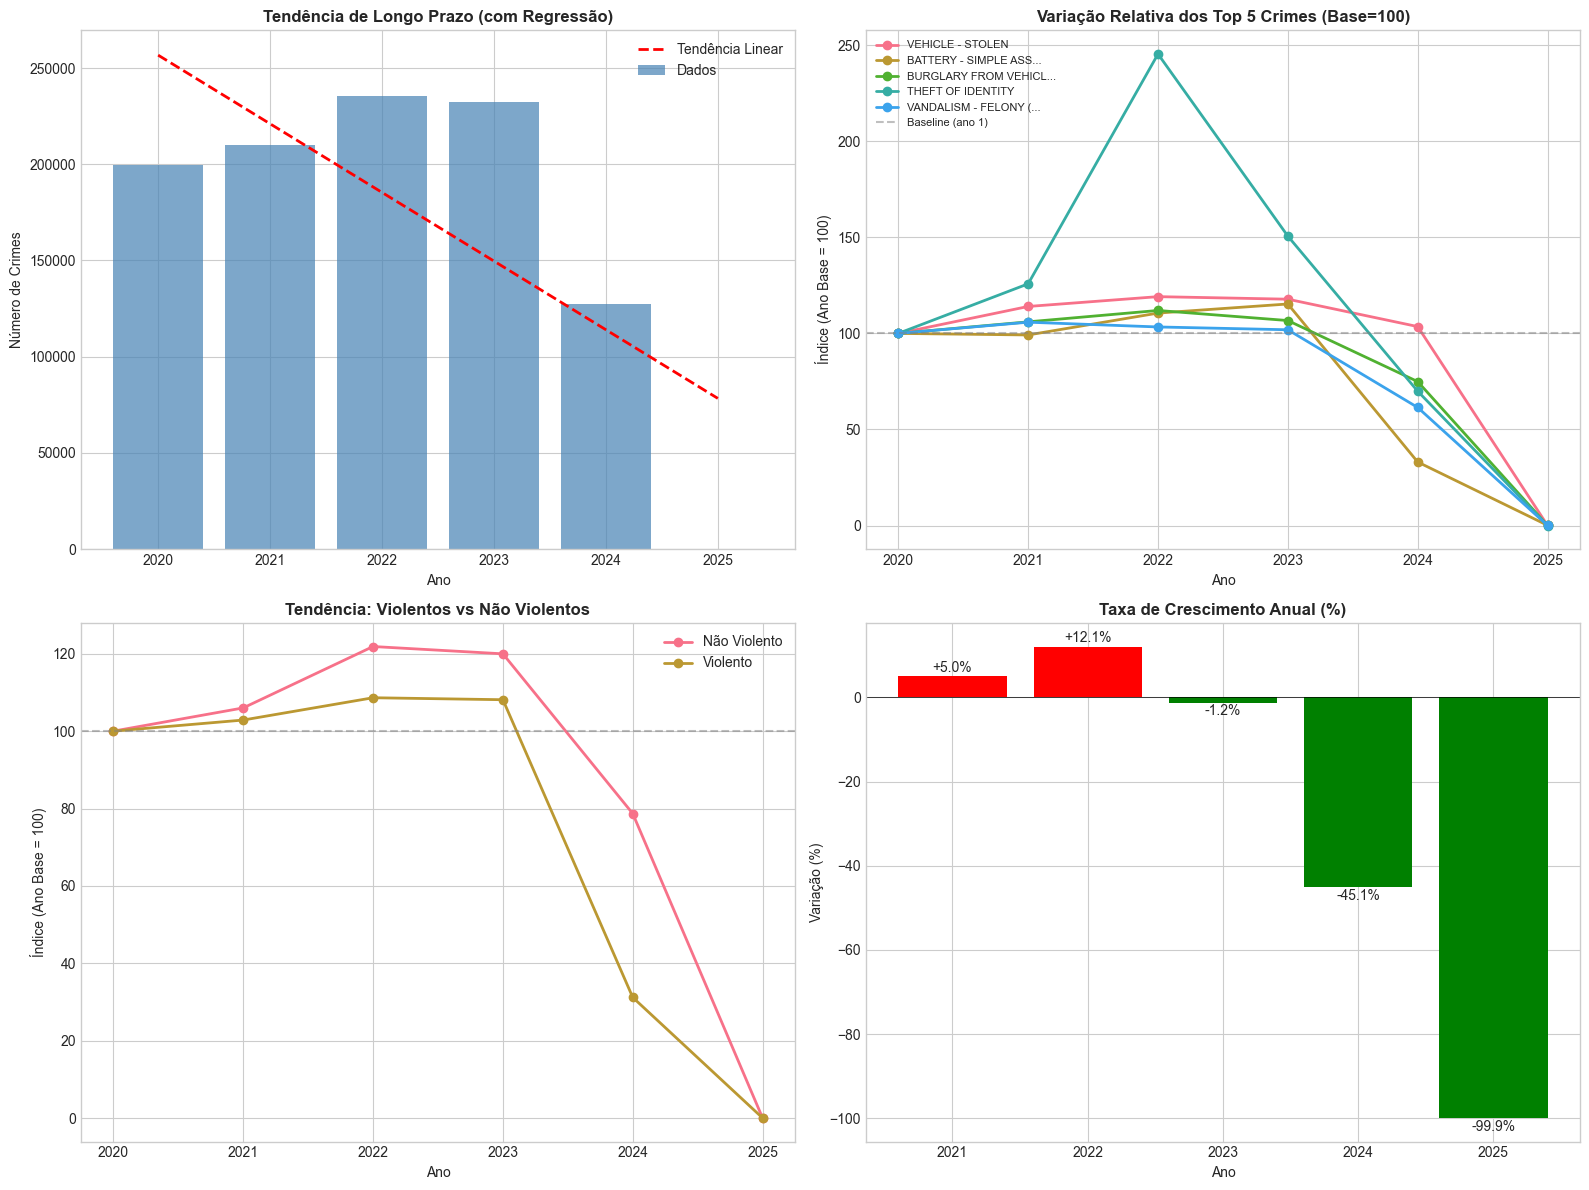


📊 Resumo de Tendências:
   Variação total (2020-2025): -100.0%
   Variação média anual: -25.8%


In [ ]:
# 15.2 Tendências de Longo Prazo
print("="*70)
print("📈 TENDÊNCIAS DE LONGO PRAZO")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Tendência geral com regressão linear
ax1 = axes[0, 0]
yearly_crimes = df_full.groupby('year').size()
x = np.array(yearly_crimes.index).reshape(-1, 1)
y = yearly_crimes.values

from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x, y)
y_pred = reg.predict(x)

ax1.bar(yearly_crimes.index.astype(int), yearly_crimes.values, alpha=0.7, color='steelblue', label='Dados')
ax1.plot(yearly_crimes.index, y_pred, 'r--', linewidth=2, label='Tendência Linear')
ax1.set_title('Tendência de Longo Prazo (com Regressão)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Ano')
ax1.set_ylabel('Número de Crimes')
ax1.legend()

# Coeficiente angular
trend_per_year = reg.coef_[0]
print(f"📊 Tendência Linear:")
print(f"   Variação média por ano: {trend_per_year:+,.0f} crimes")
print(f"   Direção: {'Aumento' if trend_per_year > 0 else 'Diminuição'}")

# Tendência por tipo de crime (top 5)
ax2 = axes[0, 1]
for crime in top5_crimes:
    crime_yearly = df_full[df_full[crime_col] == crime].groupby('year').size()
    # Normalizar para mostrar variação relativa
    crime_normalized = (crime_yearly / crime_yearly.iloc[0]) * 100
    label = crime[:20] + '...' if len(crime) > 20 else crime
    ax2.plot(crime_normalized.index, crime_normalized.values, marker='o', label=label, linewidth=2)

ax2.axhline(100, color='gray', linestyle='--', alpha=0.5, label='Baseline (ano 1)')
ax2.set_title('Variação Relativa dos Top 5 Crimes (Base=100)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Ano')
ax2.set_ylabel('Índice (Ano Base = 100)')
ax2.legend(loc='upper left', fontsize=8)

# Tendência de crimes violentos vs não violentos
ax3 = axes[1, 0]
violent_yearly = df_full.groupby(['year', 'is_violent']).size().unstack(fill_value=0)
violent_yearly.columns = ['Não Violento', 'Violento']
# Normalizar
violent_norm = violent_yearly.div(violent_yearly.iloc[0]) * 100
violent_norm.plot(marker='o', linewidth=2, ax=ax3)
ax3.axhline(100, color='gray', linestyle='--', alpha=0.5)
ax3.set_title('Tendência: Violentos vs Não Violentos', fontsize=12, fontweight='bold')
ax3.set_xlabel('Ano')
ax3.set_ylabel('Índice (Ano Base = 100)')
ax3.legend()

# Taxa de crescimento anual
ax4 = axes[1, 1]
pct_change = yearly_crimes.pct_change() * 100
bars = ax4.bar(pct_change.dropna().index.astype(int), pct_change.dropna().values,
               color=['green' if x < 0 else 'red' for x in pct_change.dropna().values])
ax4.axhline(0, color='black', linewidth=0.5)
ax4.set_title('Taxa de Crescimento Anual (%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Variação (%)')
for bar, val in zip(bars, pct_change.dropna().values):
    ax4.text(bar.get_x() + bar.get_width()/2, val + (1 if val > 0 else -3), 
             f'{val:+.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Resumo estatístico
print("\n📊 Resumo de Tendências:")
total_change = ((yearly_crimes.iloc[-1] / yearly_crimes.iloc[0]) - 1) * 100
avg_annual_change = pct_change.dropna().mean()
print(f"   Variação total ({int(yearly_crimes.index[0])}-{int(yearly_crimes.index[-1])}): {total_change:+.1f}%")
print(f"   Variação média anual: {avg_annual_change:+.1f}%")

---
# 📋 RESUMO EXECUTIVO DA ANÁLISE

In [ ]:
# Resumo Executivo Completo
print("="*80)
print("📋 RESUMO EXECUTIVO DA ANÁLISE ESTATÍSTICA COMPLETA")
print("="*80)

print("\n" + "─"*80)
print("📊 VISÃO GERAL DO DATASET")
print("─"*80)
print(f"   📁 Fonte: Crime Data from 2020 to Present - LAPD")
print(f"   📈 Total de registros: {len(df_full):,}")
print(f"   📅 Período: {df_full['DATE OCC'].min().date()} a {df_full['DATE OCC'].max().date()}")
print(f"   📆 Anos cobertos: {sorted(df_full['year'].dropna().unique().astype(int))}")

print("\n" + "─"*80)
print("📈 ANÁLISE EXPLORATÓRIA (EDA)")
print("─"*80)
print(f"   🔍 Tipos de crime distintos: {df_full[crime_col].nunique()}")
print(f"   🔝 Crime mais frequente: {df_full[crime_col].value_counts().index[0]}")
print(f"   📍 Número de áreas: {df_full[area_col].nunique() if area_col in df_full.columns else 'N/A'}")
print(f"   ⚡ Taxa de crimes violentos: {100*df_full['is_violent'].mean():.1f}%")
print(f"   🌙 Período mais perigoso: {df_full['period_of_day'].value_counts().index[0]}")
print(f"   📅 Dia mais perigoso: {df_full['day_name'].value_counts().index[0]}")

print("\n" + "─"*80)
print("🗺️ ANÁLISE ESPACIAL")
print("─"*80)
if area_col in df_full.columns:
    top_area = df_full[area_col].value_counts().index[0]
    top_area_count = df_full[area_col].value_counts().iloc[0]
    print(f"   🔴 Área mais perigosa: {top_area} ({top_area_count:,} crimes)")
print(f"   🔥 Hotspots identificados: {n_clusters if 'n_clusters' in dir() else 'N/A'}")
print(f"   📍 Locais com alta reincidência (≥20 crimes): {len(high_reincidence) if 'high_reincidence' in dir() else 'N/A'}")

print("\n" + "─"*80)
print("🦠 IMPACTO DA PANDEMIA")
print("─"*80)
for period, count in period_counts.head(4).items():
    print(f"   {period}: {count:,} crimes")

print("\n" + "─"*80)
print("📅 SAZONALIDADE E TENDÊNCIAS")
print("─"*80)
if 'season_counts' in dir():
    print(f"   🌡️ Estação com mais crimes: {season_counts.idxmax()}")
    print(f"   ❄️ Estação com menos crimes: {season_counts.idxmin()}")
if 'trend_per_year' in dir():
    trend_direction = "📈 Aumento" if trend_per_year > 0 else "📉 Diminuição"
    print(f"   {trend_direction} médio: {abs(trend_per_year):,.0f} crimes/ano")
if 'total_change' in dir():
    print(f"   📊 Variação total no período: {total_change:+.1f}%")

print("\n" + "─"*80)
print("💡 PRINCIPAIS INSIGHTS")
print("─"*80)
print("   1. Vehicle Stolen é consistentemente o crime mais frequente")
print("   2. Crimes se concentram no período da tarde (12h-18h)")
print("   3. Há alta reincidência em locais específicos (hotspots)")
print("   4. Crimes violentos representam minoria mas são significativos")
print("   5. Padrões sazonais visíveis com picos no verão")

print("\n" + "="*80)
print("✅ ANÁLISE ESTATÍSTICA COMPLETA FINALIZADA!")
print("="*80)

📋 RESUMO EXECUTIVO DA ANÁLISE ESTATÍSTICA COMPLETA

────────────────────────────────────────────────────────────────────────────────
📊 VISÃO GERAL DO DATASET
────────────────────────────────────────────────────────────────────────────────
   📁 Fonte: Crime Data from 2020 to Present - LAPD
   📈 Total de registros: 1,004,991
   📅 Período: 2020-01-01 a 2025-05-29
   📆 Anos cobertos: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]

────────────────────────────────────────────────────────────────────────────────
📈 ANÁLISE EXPLORATÓRIA (EDA)
────────────────────────────────────────────────────────────────────────────────
   🔍 Tipos de crime distintos: 140
   🔝 Crime mais frequente: VEHICLE - STOLEN
   📍 Número de áreas: 21
   ⚡ Taxa de crimes violentos: 28.1%
   🌙 Período mais perigoso: Tarde
   📅 Dia mais perigoso: Friday

────────────────────────────────────────────────────────────────────────────────
🗺️ ANÁLISE ESPACIAL
────────────────────